# Morph2REP Estrous Cycle Detection via Wavelet Analysis
## Calendar Day Alignment (No Time Shift)

### Overview

This notebook applies the Smarr et al. (2017) wavelet-based estrous detection method to Morph2REP Study 1001 vehicle-treated female mice.

### Time Alignment Decision

Smarr et al. aligned their analysis to circadian time (CT), starting each day at lights-off (6PM). However, we chose to use **calendar day alignment** (midnight to midnight) for the following reasons:

1. **Simplicity**: Direct mapping between analysis days and calendar dates makes interpretation straightforward
2. **Treatment alignment**: Dosing and cage changes are recorded in calendar time, making it easier to relate findings to experimental events
3. **Daily averaging**: Since we compute daily mean ultradian power (averaging across 24h), the specific hour boundaries matter less than for hour-by-hour analyses
4. **Data preservation**: Time shifting created artificial "empty" days due to recording end times, losing usable data

### Analysis Pipeline
1. **Data Loading** - Load locomotion bout data from S3
2. **Data Quality EDA** - Identify incomplete recording days
3. **Wavelet Analysis** - Compute ultradian power and detect LOW days
4. **Visualization** - Display results with treatment schedule overlay

---
## Section 1: Configuration and Setup

In [1]:
# =============================================================================
# IMPORTS
# =============================================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import duckdb
from datetime import date, datetime, timedelta
from scipy.signal import cwt, morlet2
from scipy.stats import wilcoxon, chisquare
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# Plot settings
plt.rcParams['figure.dpi'] = 150
plt.rcParams['font.size'] = 10

# Constants
MINUTES_PER_DAY = 1440
PERIODS_MINUTES = np.logspace(np.log10(60), np.log10(39*60), 50)
PERIODS_HOURS = PERIODS_MINUTES / 60

print("Setup complete.")

Setup complete.


In [2]:
# =============================================================================
# STUDY CONFIGURATION - CALENDAR DAY ALIGNMENT
# =============================================================================

S3_BASE = "s3://jax-envision-public-data/study_1001/2025v3.3/tabular"

# Vehicle-treated cages with full experimental timeline
# Using CALENDAR DAYS (midnight to midnight)
VEHICLE_CAGES = {
    "Rep1": {
        "cages": [4918, 4922, 4923],
        "analysis_start": "2025-01-07",
        "analysis_end": "2025-01-22",
        "n_days": 16,
        "valid_days": (2, 16),  # Day 1 partial (starts 22:00), Day 16 partial but usable (13h)
        # Treatment schedule
        "dose_1": datetime(2025, 1, 14, 6, 0),
        "dose_2": datetime(2025, 1, 17, 17, 0),
        "cage_change": datetime(2025, 1, 15, 12, 0),
    },
    "Rep2": {
        "cages": [4928, 4929, 4934],
        "analysis_start": "2025-01-22",
        "analysis_end": "2025-02-04",
        "n_days": 14,
        "valid_days": (2, 14),  # Day 1 partial (starts 14:00), Day 14 complete
        # Treatment schedule
        "dose_1": datetime(2025, 1, 28, 17, 0),
        "dose_2": datetime(2025, 1, 31, 6, 0),
        "cage_change": datetime(2025, 1, 29, 12, 0),
    },
}

# Calculate day numbers for treatment events (calendar days)
for rep, cfg in VEHICLE_CAGES.items():
    start = pd.to_datetime(cfg['analysis_start'])
    cfg['dose_1_day'] = (cfg['dose_1'].date() - start.date()).days + 1
    cfg['dose_2_day'] = (cfg['dose_2'].date() - start.date()).days + 1
    cfg['cage_change_day'] = (cfg['cage_change'].date() - start.date()).days + 1

print("Study Configuration (Calendar Day Alignment):")
print("="*60)
for rep, cfg in VEHICLE_CAGES.items():
    print(f"\n{rep}:")
    print(f"  Date range: {cfg['analysis_start']} to {cfg['analysis_end']}")
    print(f"  Total days: {cfg['n_days']}, Valid for analysis: Days {cfg['valid_days'][0]}-{cfg['valid_days'][1]}")
    print(f"  Cages: {cfg['cages']}")
    print(f"  Dose 1: Day {cfg['dose_1_day']} ({cfg['dose_1'].strftime('%b %d, %I:%M %p')})")
    print(f"  Dose 2: Day {cfg['dose_2_day']} ({cfg['dose_2'].strftime('%b %d, %I:%M %p')})")
    print(f"  Cage change: Day {cfg['cage_change_day']} ({cfg['cage_change'].strftime('%b %d, %I:%M %p')})")

Study Configuration (Calendar Day Alignment):

Rep1:
  Date range: 2025-01-07 to 2025-01-22
  Total days: 16, Valid for analysis: Days 2-16
  Cages: [4918, 4922, 4923]
  Dose 1: Day 8 (Jan 14, 06:00 AM)
  Dose 2: Day 11 (Jan 17, 05:00 PM)
  Cage change: Day 9 (Jan 15, 12:00 PM)

Rep2:
  Date range: 2025-01-22 to 2025-02-04
  Total days: 14, Valid for analysis: Days 2-14
  Cages: [4928, 4929, 4934]
  Dose 1: Day 7 (Jan 28, 05:00 PM)
  Dose 2: Day 10 (Jan 31, 06:00 AM)
  Cage change: Day 8 (Jan 29, 12:00 PM)


In [3]:
# =============================================================================
# WAVELET FUNCTIONS
# =============================================================================

def compute_wavelet_transform(data, periods_minutes=None, w=5):
    """
    Compute continuous wavelet transform using Morlet wavelet.
    """
    data = pd.Series(data).interpolate().bfill().ffill().fillna(0).values
    
    if periods_minutes is None:
        periods_minutes = PERIODS_MINUTES
    
    fs = 1
    scales = periods_minutes * fs * w / (2 * np.pi)
    
    coeffs = cwt(data, morlet2, scales, w=w)
    power = np.abs(coeffs)**2
    
    return power, periods_minutes


def extract_band_power(power, periods_minutes, band_hours):
    """
    Extract MAX power in a frequency band.
    """
    periods_hours = periods_minutes / 60
    band_mask = (periods_hours >= band_hours[0]) & (periods_hours <= band_hours[1])
    
    if not np.any(band_mask):
        return np.zeros(power.shape[1])
    
    band_power = np.max(power[band_mask, :], axis=0)
    return band_power


def bouts_to_minute_counts_calendar(bout_df, start_date, n_days):
    """
    Convert bout data to minute-level counts using CALENDAR days.
    Start time = midnight on start_date.
    """
    bout_df = bout_df.copy()
    start_time = pd.to_datetime(start_date + " 00:00:00")  # Midnight
    n_minutes = n_days * MINUTES_PER_DAY
    
    bout_df['minutes_from_start'] = (bout_df['start_time'] - start_time).dt.total_seconds() / 60
    bout_df = bout_df[(bout_df['minutes_from_start'] >= 0) & (bout_df['minutes_from_start'] < n_minutes)]
    bout_df['minute_bin'] = bout_df['minutes_from_start'].astype(int)
    
    counts = bout_df.groupby('minute_bin').size()
    
    full_series = pd.Series(index=range(n_minutes), dtype=float).fillna(0)
    full_series.update(counts)
    
    return full_series.values


print("Wavelet functions defined (using calendar day alignment).")

Wavelet functions defined (using calendar day alignment).


---
## Section 2: Data Loading

In [4]:
# =============================================================================
# DATA LOADING FUNCTION
# =============================================================================

def load_parquet_s3(cage_id, start_date, end_date, table_name):
    """Load parquet data from S3 for a specific cage and date range."""
    conn = duckdb.connect()
    conn.execute("INSTALL httpfs; LOAD httpfs;")
    conn.execute("SET s3_region='us-east-1';")
    
    dates = pd.date_range(start_date, end_date, freq='D')
    all_data = []
    
    for d in dates:
        date_str = d.strftime('%Y-%m-%d')
        path = f"{S3_BASE}/cage_id={cage_id}/date={date_str}/{table_name}"
        try:
            df = conn.execute(f"SELECT * FROM read_parquet('{path}')").fetchdf()
            df['cage_id'] = cage_id
            df['date'] = date_str
            all_data.append(df)
        except:
            continue
    
    conn.close()
    return pd.concat(all_data, ignore_index=True) if all_data else pd.DataFrame()

print("Load function defined.")

Load function defined.


In [5]:
# =============================================================================
# LOAD LOCOMOTION BOUT DATA
# =============================================================================
print("Loading Morph2REP Locomotion Bout Data...")
print("="*60)

all_bouts = []
for rep, cfg in VEHICLE_CAGES.items():
    print(f"\n{rep} ({cfg['n_days']} days):")
    for cage_id in cfg['cages']:
        print(f"  Cage {cage_id}...", end=" ")
        df = load_parquet_s3(cage_id, cfg['analysis_start'], cfg['analysis_end'], 'animal_bouts.parquet')
        if len(df) > 0:
            df['replicate'] = rep
            all_bouts.append(df)
            print(f"{len(df):,} rows")
        else:
            print("No data")

df_bouts = pd.concat(all_bouts, ignore_index=True)
print(f"\nTotal bout rows: {len(df_bouts):,}")

# Filter for locomotion bouts
df_loco = df_bouts[df_bouts['state_name'] == 'animal_bouts.locomotion'].copy()
df_loco['start_time'] = pd.to_datetime(df_loco['start_time'])

print(f"\nLocomotion bouts: {len(df_loco):,}")
for rep in ['Rep1', 'Rep2']:
    rep_df = df_loco[df_loco['replicate'] == rep]
    print(f"  {rep}: {len(rep_df):,} bouts, {rep_df['animal_id'].nunique()} animals")

Loading Morph2REP Locomotion Bout Data...

Rep1 (16 days):
  Cage 4918... 2,558,344 rows
  Cage 4922... 2,401,455 rows
  Cage 4923... 

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

2,458,754 rows

Rep2 (14 days):
  Cage 4928... 2,259,981 rows
  Cage 4929... 2,071,012 rows
  Cage 4934... 2,201,662 rows

Total bout rows: 13,951,208

Locomotion bouts: 564,486
  Rep1: 294,317 bouts, 9 animals
  Rep2: 270,169 bouts, 9 animals


---
## Section 3: Data Quality EDA

Check for incomplete recording days using calendar day boundaries.

In [6]:
# =============================================================================
# CHECK DATA COMPLETENESS BY CALENDAR DAY
# =============================================================================
print("="*70)
print("DATA COMPLETENESS CHECK (Calendar Days)")
print("="*70)

for rep, cfg in VEHICLE_CAGES.items():
    print(f"\n{rep}:")
    print("-"*70)
    
    rep_df = df_loco[df_loco['replicate'] == rep].copy()
    rep_df['calendar_date'] = rep_df['start_time'].dt.date
    
    # Count bouts per calendar day
    daily_counts = rep_df.groupby('calendar_date').agg({
        'start_time': ['count', 'min', 'max']
    })
    daily_counts.columns = ['bout_count', 'first_bout', 'last_bout']
    daily_counts = daily_counts.sort_index()
    
    median_count = daily_counts['bout_count'].median()
    
    print(f"\n{'Day':<5} {'Date':<12} {'Bouts':<10} {'First':<10} {'Last':<10} {'Hours':<8} {'Status'}")
    print("-"*75)
    
    for i, (date, row) in enumerate(daily_counts.iterrows()):
        day_num = i + 1
        first_hour = row['first_bout'].hour
        last_hour = row['last_bout'].hour
        hours_covered = last_hour - first_hour + 1
        
        # Determine status
        if row['bout_count'] < median_count * 0.5:
            status = "⚠️ LOW COUNT"
        elif first_hour > 6:
            status = f"⚠️ LATE START ({first_hour}:00)"
        elif last_hour < 18:
            status = f"⚠️ EARLY END ({last_hour}:00)"
        else:
            status = "✓ Complete"
            
        print(f"D{day_num:<4} {str(date):<12} {int(row['bout_count']):<10} {first_hour:02d}:00{'':<5} {last_hour:02d}:59{'':<5} ~{hours_covered:<6} {status}")
    
    print(f"\nMedian daily bout count: {median_count:,.0f}")

DATA COMPLETENESS CHECK (Calendar Days)

Rep1:
----------------------------------------------------------------------

Day   Date         Bouts      First      Last       Hours    Status
---------------------------------------------------------------------------
D1    2025-01-07   2403       22:00      23:59      ~2      ⚠️ LOW COUNT
D2    2025-01-08   22674      00:00      23:59      ~24     ✓ Complete
D3    2025-01-09   22265      00:00      23:59      ~24     ✓ Complete
D4    2025-01-10   21372      00:00      23:59      ~24     ✓ Complete
D5    2025-01-11   19327      00:00      23:59      ~24     ✓ Complete
D6    2025-01-12   19999      00:00      23:59      ~24     ✓ Complete
D7    2025-01-13   21767      00:00      23:59      ~24     ✓ Complete
D8    2025-01-14   16251      00:00      23:59      ~24     ✓ Complete
D9    2025-01-15   17347      00:00      23:59      ~24     ✓ Complete
D10   2025-01-16   18909      00:00      23:59      ~24     ✓ Complete
D11   2025-01-17   19996 

In [7]:
# =============================================================================
# CHECK CAGE-LEVEL DATA FOR PROBLEMATIC DAYS
# =============================================================================
print("\n" + "="*70)
print("CAGE-LEVEL CHECK FOR POTENTIALLY PROBLEMATIC DAYS")
print("="*70)

# Rep2 Day 14 - check for missing cage
print("\nRep2 - Checking all days by cage:")
rep2_df = df_loco[df_loco['replicate'] == 'Rep2'].copy()
rep2_df['calendar_date'] = rep2_df['start_time'].dt.date

dates = sorted(rep2_df['calendar_date'].unique())
cages = VEHICLE_CAGES['Rep2']['cages']

print(f"\n{'Day':<5}", end="")
for cage in cages:
    print(f"Cage {cage:<10}", end="")
print("Status")
print("-"*60)

for i, d in enumerate(dates):
    day_num = i + 1
    print(f"D{day_num:<4}", end="")
    cage_counts = []
    for cage in cages:
        count = len(rep2_df[(rep2_df['calendar_date'] == d) & (rep2_df['cage_id'] == cage)])
        cage_counts.append(count)
        flag = "⚠️" if count < 1000 else ""
        print(f"{count:<14}{flag}", end="")
    
    if any(c == 0 for c in cage_counts):
        print("MISSING CAGE")
    elif any(c < 1000 for c in cage_counts):
        print("LOW COUNT")
    else:
        print("OK")


CAGE-LEVEL CHECK FOR POTENTIALLY PROBLEMATIC DAYS

Rep2 - Checking all days by cage:

Day  Cage 4928      Cage 4929      Cage 4934      Status
------------------------------------------------------------
D1   1992          2130          2226          OK
D2   10024         9408          8351          OK
D3   9327          8669          7407          OK
D4   8245          7753          6598          OK
D5   8375          6913          6598          OK
D6   8401          7428          6624          OK
D7   7979          7610          6745          OK
D8   6098          5301          4791          OK
D9   6662          6843          5451          OK
D10  6106          5887          4959          OK
D11  6341          5654          5111          OK
D12  7309          7053          5559          OK
D13  7190          6908          5894          OK
D14  6653          0             ⚠️5596          MISSING CAGE


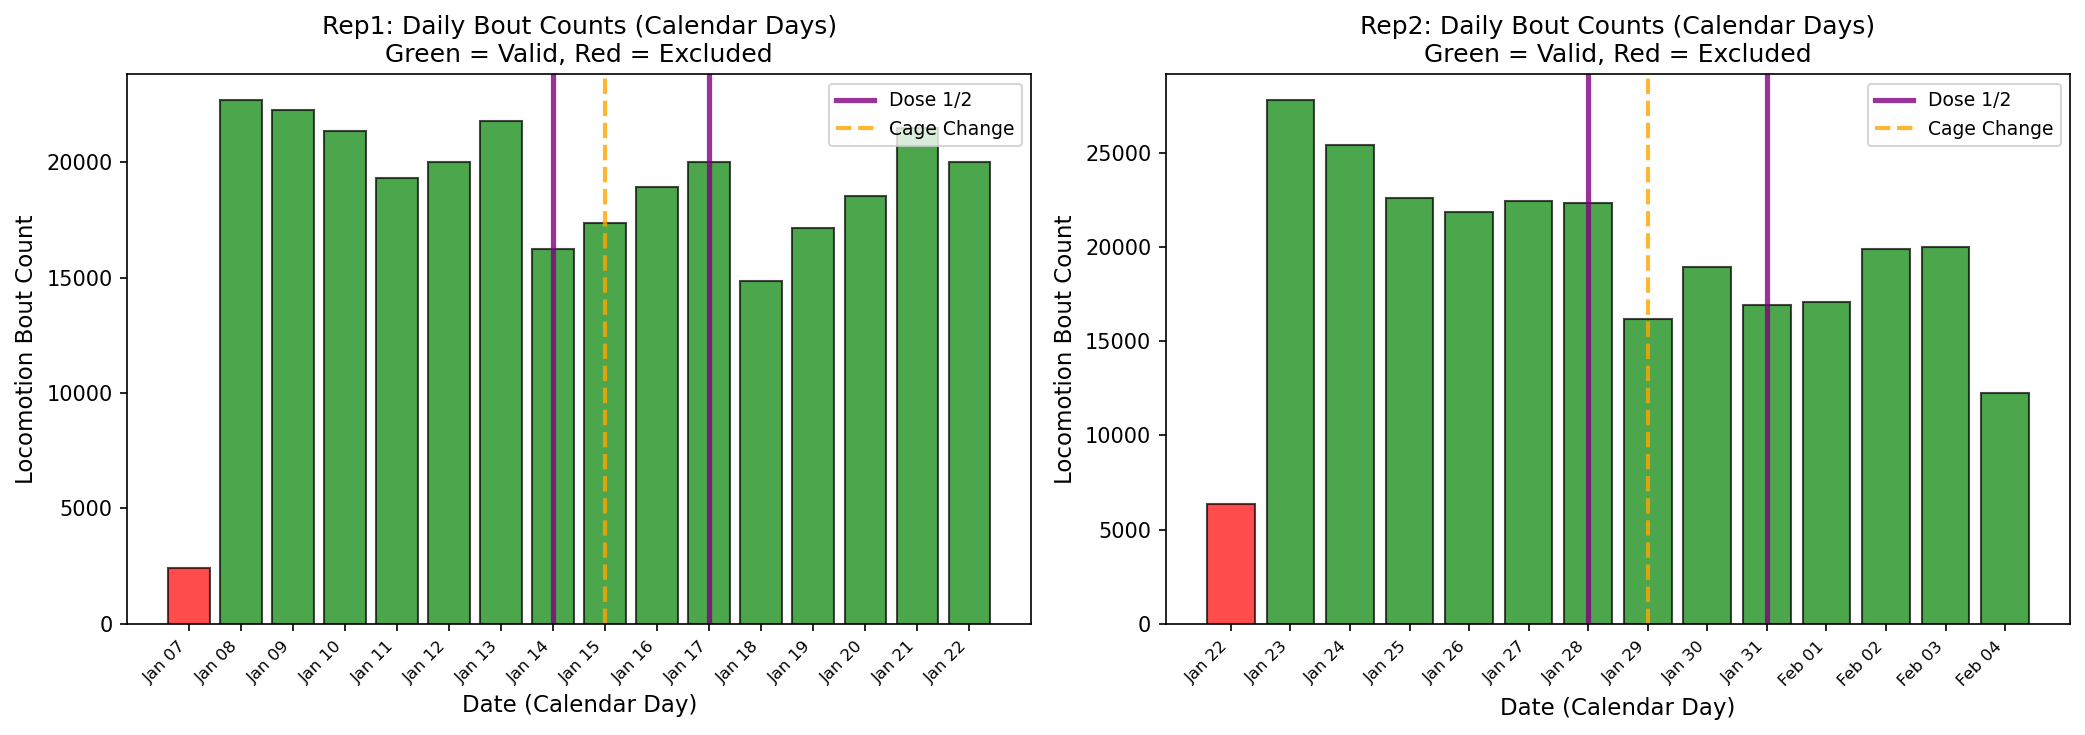

In [8]:
# =============================================================================
# VISUALIZE DATA COMPLETENESS
# =============================================================================

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for col, (rep, cfg) in enumerate(VEHICLE_CAGES.items()):
    ax = axes[col]
    
    rep_df = df_loco[df_loco['replicate'] == rep].copy()
    rep_df['calendar_date'] = rep_df['start_time'].dt.date
    
    daily_counts = rep_df.groupby('calendar_date').size()
    days = list(range(1, len(daily_counts) + 1))
    counts = daily_counts.values
    
    # Determine valid days
    valid_start, valid_end = cfg['valid_days']
    
    # Color bars based on validity
    colors = []
    for i, c in enumerate(counts):
        day_num = i + 1
        if day_num < valid_start:
            colors.append('red')  # Excluded (partial start)
        elif day_num > valid_end:
            colors.append('red')  # Excluded
        else:
            colors.append('green')  # Valid
    
    ax.bar(days, counts, color=colors, edgecolor='black', alpha=0.7)
    
    # Mark treatment days
    ax.axvline(x=cfg['dose_1_day'], color='purple', linestyle='-', linewidth=2.5, alpha=0.8, label='Dose 1/2')
    ax.axvline(x=cfg['dose_2_day'], color='purple', linestyle='-', linewidth=2.5, alpha=0.8)
    ax.axvline(x=cfg['cage_change_day'], color='orange', linestyle='--', linewidth=2, alpha=0.8, label='Cage Change')
    
    # Add date labels
    date_labels = [d.strftime('%b %d') for d in daily_counts.index]
    ax.set_xticks(days)
    ax.set_xticklabels(date_labels, rotation=45, ha='right', fontsize=8)
    
    ax.set_xlabel('Date (Calendar Day)', fontsize=11)
    ax.set_ylabel('Locomotion Bout Count', fontsize=11)
    ax.set_title(f'{rep}: Daily Bout Counts (Calendar Days)\nGreen = Valid, Red = Excluded', fontsize=12)
    ax.legend(loc='upper right', fontsize=9)

plt.tight_layout()
plt.savefig('morph2rep_calendar_data_completeness.png', dpi=150, bbox_inches='tight')
plt.show()

### Data Quality Summary

Using calendar day alignment:

**Rep1 (Jan 7-22):**
- **Day 1 (Jan 7):** Recording started at 22:00 - only 2 hours → **EXCLUDE**
- **Days 2-15 (Jan 8-21):** Complete 24-hour recordings → **VALID**
- **Day 16 (Jan 22):** Recording ended at 12:59 - 13 hours → **VALID** (sufficient for daily average)

**Rep2 (Jan 22 - Feb 4):**
- **Day 1 (Jan 22):** Recording started at 14:00 - only 10 hours → **EXCLUDE**
- **Days 2-14 (Jan 23 - Feb 4):** Complete recordings → **VALID**

**Note:** Unlike the time-shifted approach, we can include Day 16 for Rep1 since it has 13 hours of data, sufficient for computing daily mean ultradian power.

---
## Section 4: Wavelet Analysis

In [9]:
# =============================================================================
# WAVELET ANALYSIS - CALENDAR DAY ALIGNMENT
# =============================================================================

all_rep_results = {}

for rep, cfg in VEHICLE_CAGES.items():
    print(f"\n{'='*70}")
    print(f"{rep} WAVELET ANALYSIS (Calendar Days)")
    print(f"{'='*70}")
    
    rep_df = df_loco[df_loco['replicate'] == rep].copy()
    animals = sorted([a for a in rep_df['animal_id'].unique() if a != 0])
    valid_days = cfg['valid_days']
    
    print(f"Animals: {len(animals)}")
    print(f"Total days: {cfg['n_days']}, Valid for analysis: Days {valid_days[0]}-{valid_days[1]}")
    
    # Compute wavelet for each animal
    animal_results = []
    
    for animal_id in animals:
        animal_df = rep_df[rep_df['animal_id'] == animal_id].copy()
        cage_id = animal_df['cage_id'].iloc[0]
        
        # Convert bouts to minute counts (calendar alignment)
        animal_ts = bouts_to_minute_counts_calendar(animal_df, cfg['analysis_start'], cfg['n_days'])
        
        # Compute wavelet
        power, _ = compute_wavelet_transform(animal_ts, PERIODS_MINUTES)
        ultradian = extract_band_power(power, PERIODS_MINUTES, (1, 3))
        
        # Day-by-day power (calendar days)
        day_powers = []
        for day in range(1, cfg['n_days'] + 1):
            day_start = (day - 1) * MINUTES_PER_DAY
            day_end = day * MINUTES_PER_DAY
            if day_end <= len(ultradian):
                day_powers.append(np.nanmean(ultradian[day_start:day_end]))
            else:
                day_powers.append(np.nan)
        
        animal_results.append({
            'animal_id': animal_id,
            'cage_id': cage_id,
            'day_powers': day_powers,
            'n_days': cfg['n_days'],
            'ultradian_ts': ultradian
        })
    
    # =========================================================================
    # DAY-BY-DAY TABLE
    # =========================================================================
    print(f"\n--- Day-by-Day Ultradian Power ---")
    
    # Header
    header = f"{'Animal':<10} {'Cage':<8}"
    for d in range(1, cfg['n_days'] + 1):
        marker = "*" if d < valid_days[0] or d > valid_days[1] else ""
        header += f"D{d}{marker:<5}"
    print(header)
    print("-" * len(header))
    
    for r in animal_results:
        row = f"{r['animal_id']:<10} {r['cage_id']:<8}"
        for d in range(1, cfg['n_days'] + 1):
            val = r['day_powers'][d-1]
            row += f"{val:<7.1f}" if not np.isnan(val) else f"{'N/A':<7}"
        print(row)
    
    print(f"\n* = Excluded from analysis")
    
    # =========================================================================
    # LOW DAY DETECTION
    # =========================================================================
    print(f"\n--- LOW Days Detection (Days {valid_days[0]}-{valid_days[1]}) ---")
    
    threshold_pct = 0.80
    
    print(f"\n{'Animal':<10} {'Cage':<8} {'LOW days':<25} {'Spacings':<20} {'4-day cycle?'}")
    print("-"*90)
    
    cycle_results = []
    
    for r in animal_results:
        animal_id = r['animal_id']
        cage_id = r['cage_id']
        day_powers = r['day_powers']
        
        # Calculate median using only valid days
        valid_powers = [day_powers[i] for i in range(valid_days[0]-1, valid_days[1])
                        if i < len(day_powers) and not np.isnan(day_powers[i])]
        
        if not valid_powers:
            continue
        
        median_power = np.median(valid_powers)
        threshold = median_power * threshold_pct
        
        # Find LOW days (only within valid range)
        low_days = []
        for day in range(valid_days[0], valid_days[1] + 1):
            idx = day - 1
            if idx < len(day_powers) and not np.isnan(day_powers[idx]) and day_powers[idx] < threshold:
                low_days.append(day)
        
        # Calculate spacings
        spacings = [low_days[i] - low_days[i-1] for i in range(1, len(low_days))]
        
        # Check for 4-day pattern
        has_exact_4 = any(d2 - d1 == 4 for d1 in low_days for d2 in low_days if d2 > d1)
        has_approx_4 = any(3 <= d2 - d1 <= 5 for d1 in low_days for d2 in low_days if d2 > d1)
        
        if len(low_days) >= 2 and has_exact_4:
            assessment = "✓ STRONG"
        elif len(low_days) >= 2 and has_approx_4:
            assessment = "~ MODERATE"
        elif len(low_days) >= 2:
            assessment = "? IRREGULAR"
        else:
            assessment = "✗ INSUFFICIENT"
        
        cycle_results.append({
            'animal_id': animal_id,
            'cage_id': cage_id,
            'low_days': low_days,
            'spacings': spacings,
            'has_4day': has_exact_4,
            'assessment': assessment,
            'median_power': median_power,
            'threshold': threshold
        })
        
        print(f"{animal_id:<10} {cage_id:<8} {str(low_days):<25} {str(spacings):<20} {assessment}")
    
    # Summary
    n_strong = sum(1 for r in cycle_results if '✓' in r['assessment'])
    n_moderate = sum(1 for r in cycle_results if '~' in r['assessment'])
    n_total = len(cycle_results)
    
    print("-"*90)
    print(f"Strong 4-day cycling: {n_strong}/{n_total}")
    print(f"Moderate evidence: {n_moderate}/{n_total}")
    
    # =========================================================================
    # PHASE CONSISTENCY CHECK
    # =========================================================================
    all_low_days = []
    for r in cycle_results:
        all_low_days.extend(r['low_days'])
    
    if all_low_days:
        phases = [(d - 1) % 4 for d in all_low_days]
        phase_counts = Counter(phases)
        
        print(f"\n--- Phase Consistency Check ---")
        print(f"Phase 0 (Days 1,5,9,13...): {phase_counts.get(0, 0)}")
        print(f"Phase 1 (Days 2,6,10,14...): {phase_counts.get(1, 0)}")
        print(f"Phase 2 (Days 3,7,11,15...): {phase_counts.get(2, 0)}")
        print(f"Phase 3 (Days 4,8,12,16...): {phase_counts.get(3, 0)}")
        
        if sum(phase_counts.values()) >= 4:
            observed = [phase_counts.get(i, 0) for i in range(4)]
            expected = [len(all_low_days) / 4] * 4
            stat, p_chi = chisquare(observed, expected)
            print(f"\nChi-square test: χ²={stat:.2f}, p={p_chi:.4f}")
            if p_chi < 0.05:
                dominant = max(phase_counts, key=phase_counts.get)
                print(f"→ Significant clustering at Phase {dominant}")
            else:
                print(f"→ No significant phase clustering")
        else:
            p_chi = None
    else:
        phase_counts = Counter()
        p_chi = None
    
    # Store results
    all_rep_results[rep] = {
        'animal_results': animal_results,
        'cycle_results': cycle_results,
        'n_strong': n_strong,
        'n_moderate': n_moderate,
        'n_total': n_total,
        'phase_counts': phase_counts,
        'p_chi': p_chi,
        'valid_days': valid_days
    }


Rep1 WAVELET ANALYSIS (Calendar Days)
Animals: 9
Total days: 16, Valid for analysis: Days 2-16

--- Day-by-Day Ultradian Power ---
Animal     Cage    D1*    D2     D3     D4     D5     D6     D7     D8     D9     D10     D11     D12     D13     D14     D15     D16     
------------------------------------------------------------------------------------------------------------------------------------------
9257       4918    10.3   88.3   50.6   83.3   60.7   103.6  51.2   54.1   38.9   73.6   64.6   82.0   30.2   39.2   126.0  80.6   
9258       4918    28.0   323.7  247.9  179.0  164.3  249.8  183.7  124.4  256.8  335.2  232.5  170.5  287.6  90.8   251.6  119.2  
9259       4918    19.6   99.9   84.1   146.7  119.1  184.6  63.0   82.3   57.1   97.5   109.8  58.4   49.7   87.4   118.7  66.9   
9260       4922    7.1    110.2  80.3   82.2   88.8   68.6   75.0   49.1   39.0   83.4   72.3   54.0   42.8   38.6   79.1   61.3   
9261       4922    5.9    129.5  79.9   89.0   91.9   65.9   1

In [10]:
# =============================================================================
# EXPORT RESULTS TO CSV FOR GOOGLE DOCS
# =============================================================================

import pandas as pd

for rep, results in all_rep_results.items():
    cfg = VEHICLE_CAGES[rep]
    animal_results = results['animal_results']
    cycle_results = results['cycle_results']
    valid_days = cfg['valid_days']
    
    # ----- TABLE 1: Day-by-Day Ultradian Power -----
    power_data = []
    for r in animal_results:
        row = {
            'Animal': r['animal_id'],
            'Cage': r['cage_id'],
        }
        for day in range(1, cfg['n_days'] + 1):
            col_name = f'D{day}' if day >= valid_days[0] else f'D{day}*'
            row[col_name] = round(r['day_powers'][day-1], 1) if not np.isnan(r['day_powers'][day-1]) else ''
        power_data.append(row)
    
    power_df = pd.DataFrame(power_data)
    power_df.to_csv(f'{rep}_ultradian_power.csv', index=False)
    print(f"Saved: {rep}_ultradian_power.csv")
    
    # ----- TABLE 2: LOW Day Detection -----
    low_data = []
    for cr in cycle_results:
        low_data.append({
            'Animal': cr['animal_id'],
            'Cage': cr['cage_id'],
            'LOW Days': ', '.join(map(str, cr['low_days'])) if cr['low_days'] else '—',
            'Spacings': ', '.join(map(str, cr['spacings'])) if cr['spacings'] else '—',
            'Assessment': cr['assessment'].replace('✓', '').replace('~', '').replace('?', '').replace('✗', '').strip()
        })
    
    low_df = pd.DataFrame(low_data)
    low_df.to_csv(f'{rep}_low_days.csv', index=False)
    print(f"Saved: {rep}_low_days.csv")

# ----- TABLE 3: Summary Statistics -----
summary_data = []
for rep, results in all_rep_results.items():
    cfg = VEHICLE_CAGES[rep]
    summary_data.append({
        'Replicate': rep,
        'Date Range': f"{cfg['analysis_start']} to {cfg['analysis_end']}",
        'Valid Days': f"Days {cfg['valid_days'][0]}-{cfg['valid_days'][1]}",
        'Animals': results['n_total'],
        'Strong Cycling': f"{results['n_strong']}/{results['n_total']}",
        'Moderate': f"{results['n_moderate']}/{results['n_total']}",
        'Phase Clustering p': f"{results['p_chi']:.4f}" if results['p_chi'] else 'N/A',
        'Dose 1 Day': cfg['dose_1_day'],
        'Cage Change Day': cfg['cage_change_day'],
        'Dose 2 Day': cfg['dose_2_day'],
    })

summary_df = pd.DataFrame(summary_data)
summary_df.to_csv('estrous_summary.csv', index=False)
print(f"Saved: estrous_summary.csv")

print("\n✓ All CSVs saved! Import into Google Sheets, then copy-paste into Google Docs as tables.")

Saved: Rep1_ultradian_power.csv
Saved: Rep1_low_days.csv
Saved: Rep2_ultradian_power.csv
Saved: Rep2_low_days.csv
Saved: estrous_summary.csv

✓ All CSVs saved! Import into Google Sheets, then copy-paste into Google Docs as tables.


---
## Section 5: Visualizations

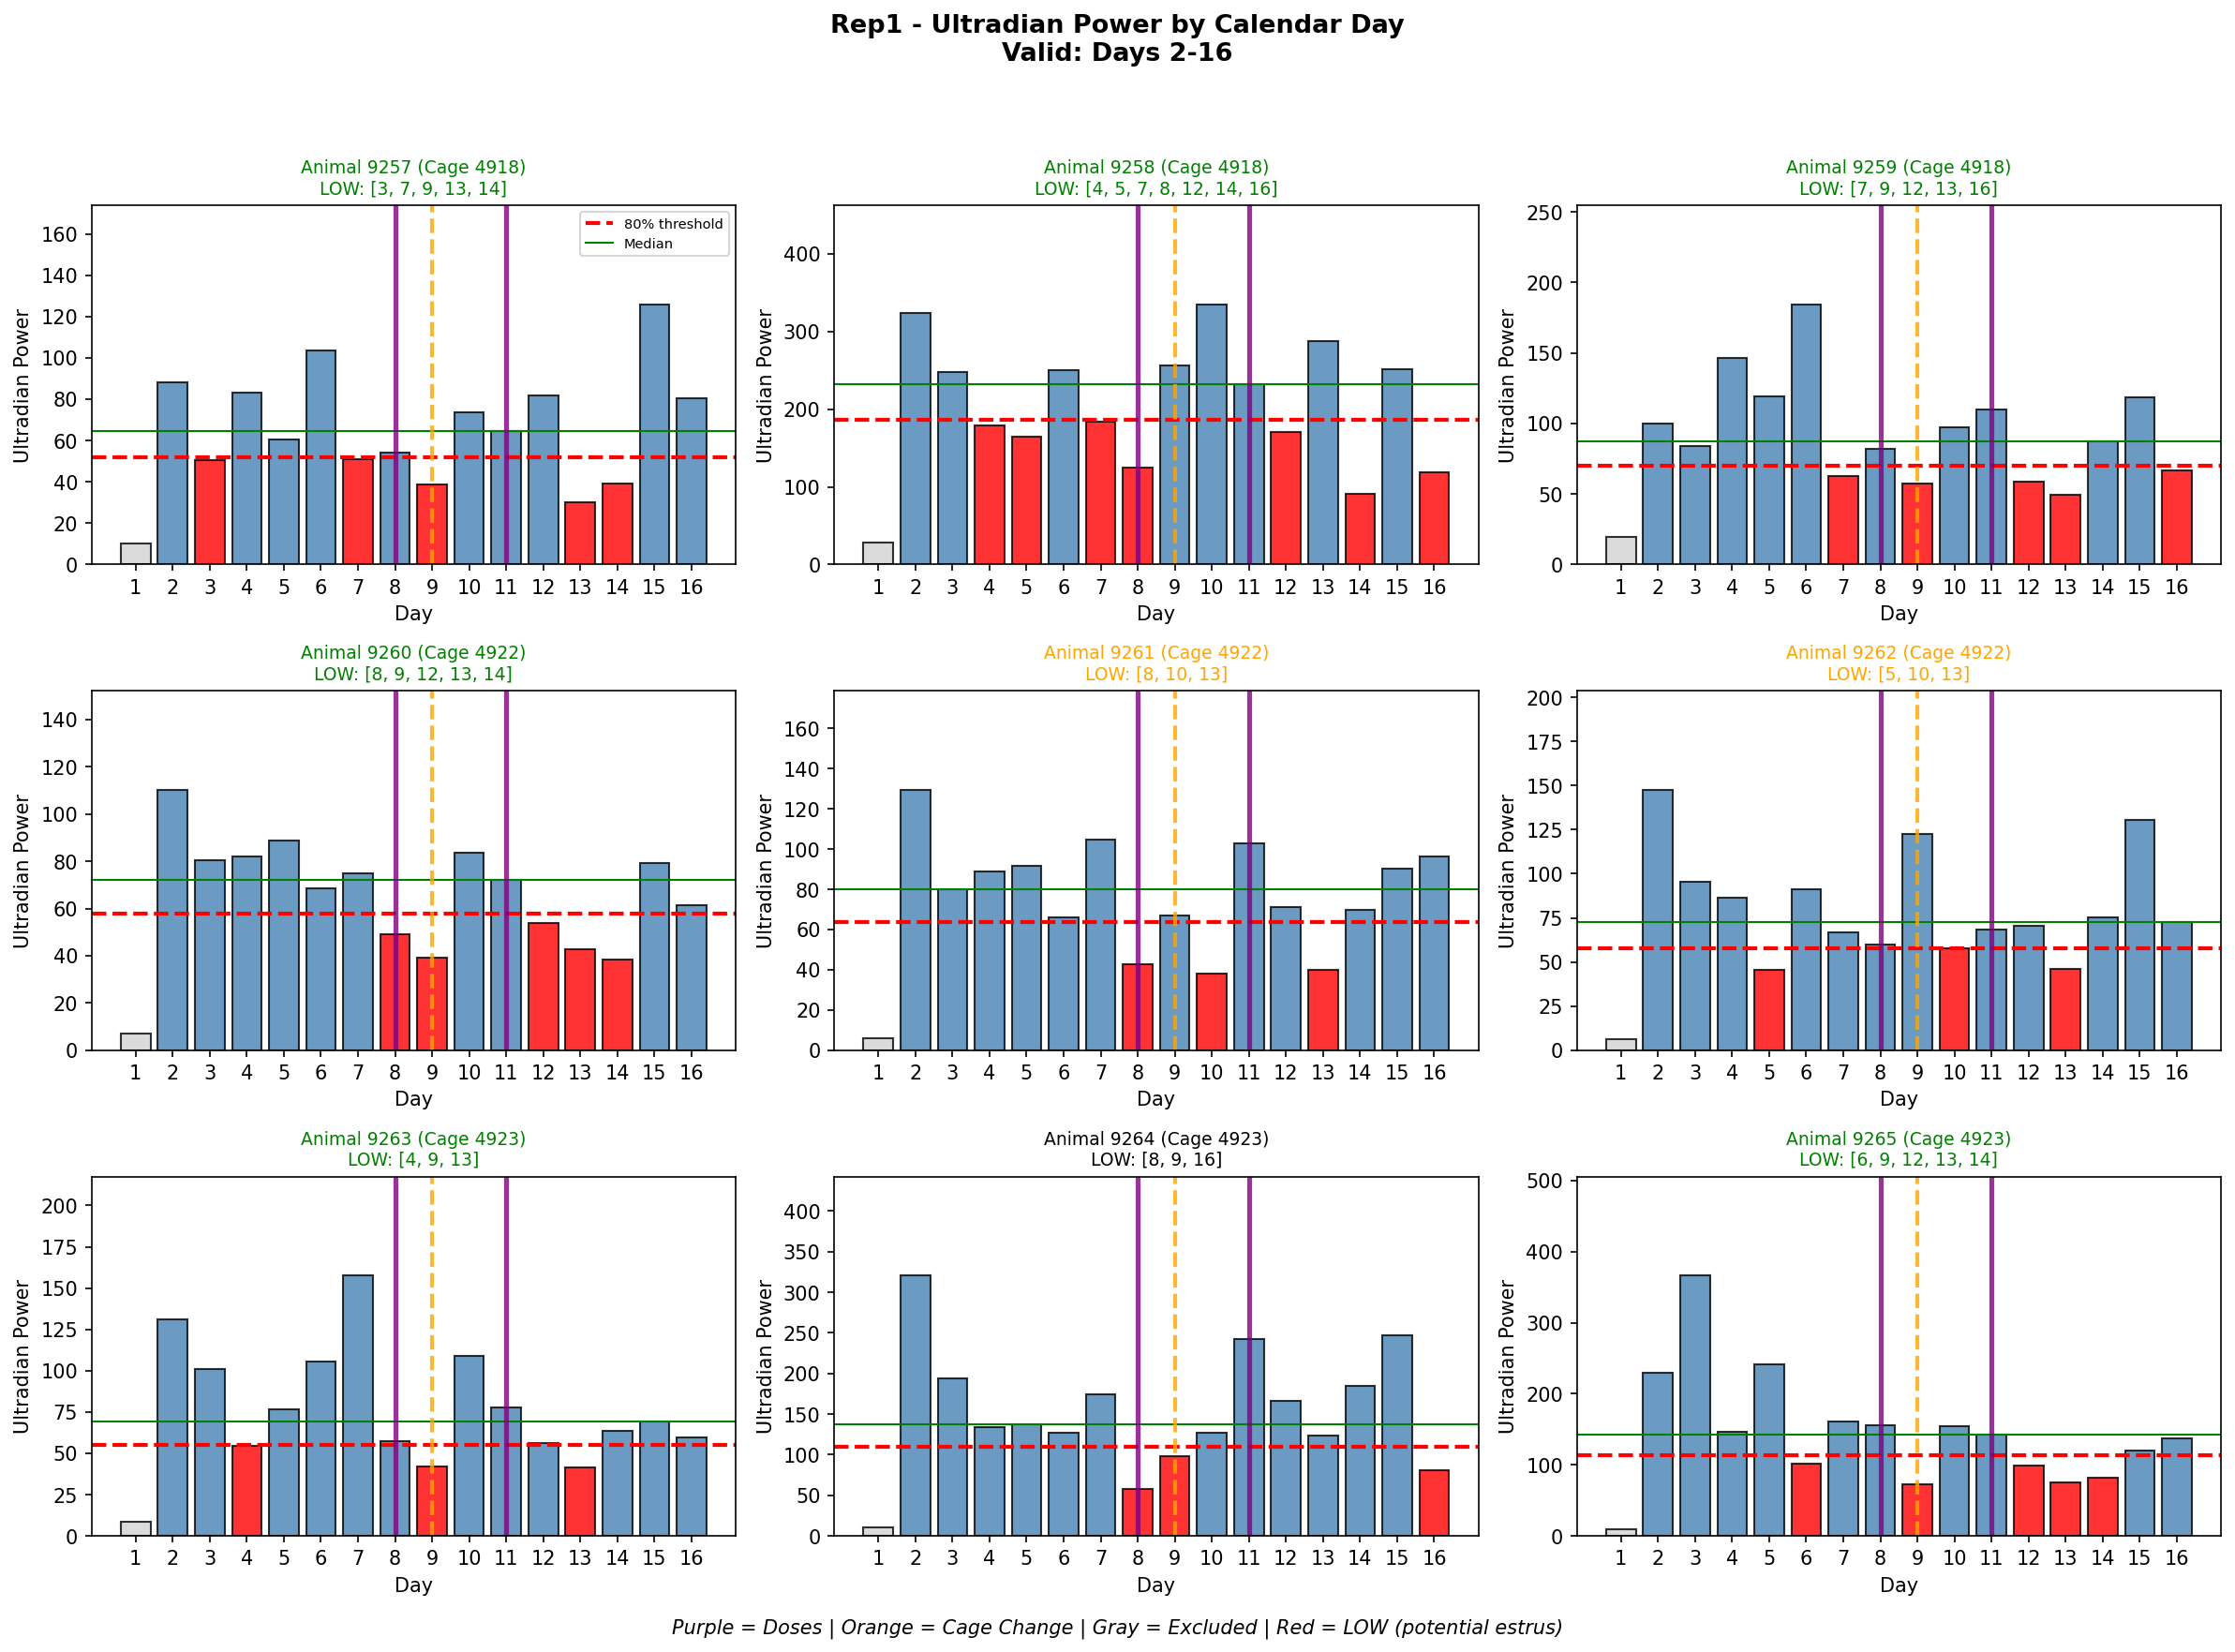

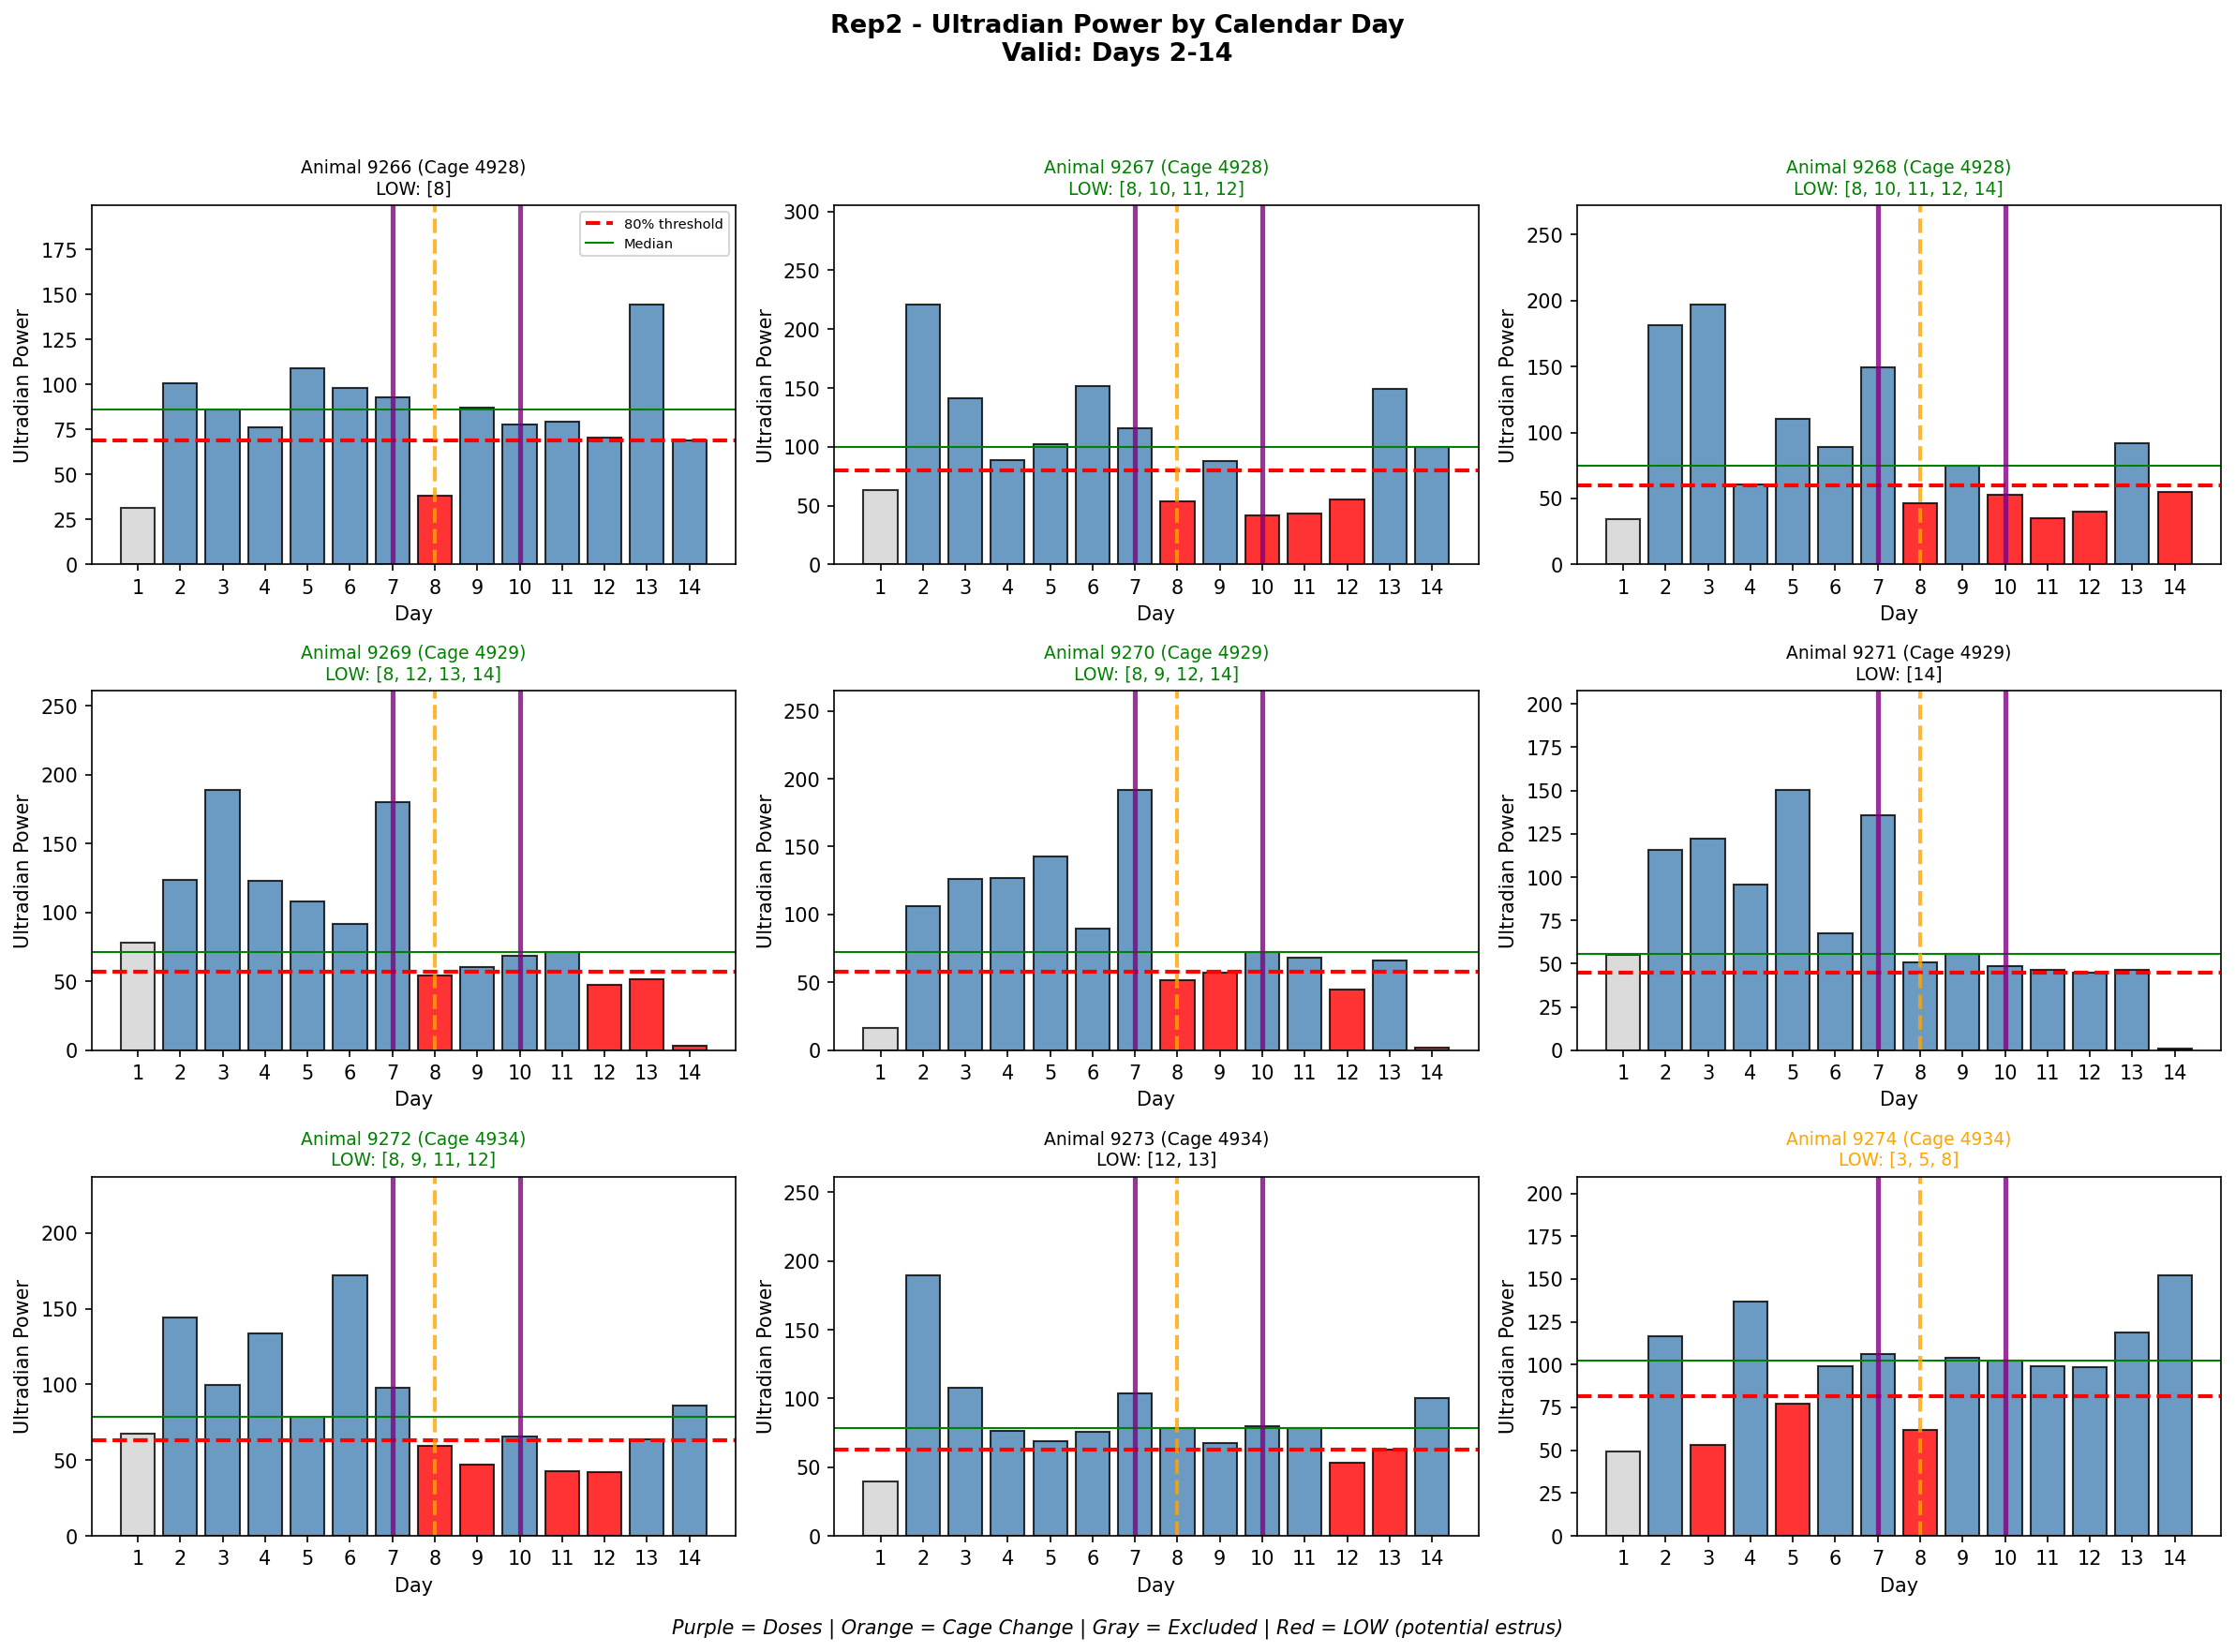

In [11]:
# =============================================================================
# FIGURE 1: INDIVIDUAL ANIMAL BAR PLOTS WITH TREATMENT MARKERS
# =============================================================================

for rep, results in all_rep_results.items():
    cfg = VEHICLE_CAGES[rep]
    animal_results = results['animal_results']
    cycle_results = results['cycle_results']
    valid_days = results['valid_days']
    
    n_animals = len(animal_results)
    n_cols = 3
    n_rows = (n_animals + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 4*n_rows))
    axes = axes.flatten()
    
    # Get calendar dates for x-axis
    start_date = pd.to_datetime(cfg['analysis_start'])
    dates = [(start_date + pd.Timedelta(days=i)).strftime('%b %d') for i in range(cfg['n_days'])]
    
    for idx, r in enumerate(animal_results):
        ax = axes[idx]
        day_powers = r['day_powers']
        days = list(range(1, len(day_powers) + 1))
        
        # Get threshold from cycle results
        cr = next((c for c in cycle_results if c['animal_id'] == r['animal_id']), None)
        if cr:
            threshold = cr['threshold']
            median_power = cr['median_power']
            low_days = cr['low_days']
        else:
            valid_powers = [p for i, p in enumerate(day_powers) if valid_days[0] <= i+1 <= valid_days[1] and not np.isnan(p)]
            median_power = np.median(valid_powers) if valid_powers else 0
            threshold = median_power * 0.80
            low_days = []
        
        # Color bars
        colors = []
        for i, p in enumerate(day_powers):
            day_num = i + 1
            if day_num < valid_days[0] or day_num > valid_days[1]:
                colors.append('lightgray')
            elif np.isnan(p):
                colors.append('white')
            elif p < threshold:
                colors.append('red')
            else:
                colors.append('steelblue')
        
        ax.bar(days, day_powers, color=colors, edgecolor='black', alpha=0.8)
        ax.axhline(y=threshold, color='red', linestyle='--', linewidth=2, label='80% threshold')
        ax.axhline(y=median_power, color='green', linestyle='-', linewidth=1, label='Median')
        
        # Treatment markers
        ymax = max([p for p in day_powers if not np.isnan(p)]) * 1.15
        ax.axvline(x=cfg['dose_1_day'], color='purple', linestyle='-', linewidth=2.5, alpha=0.8)
        ax.axvline(x=cfg['dose_2_day'], color='purple', linestyle='-', linewidth=2.5, alpha=0.8)
        ax.axvline(x=cfg['cage_change_day'], color='orange', linestyle='--', linewidth=2, alpha=0.8)
        
        # Title
        if cr:
            title_color = 'green' if '✓' in cr['assessment'] else 'orange' if '~' in cr['assessment'] else 'black'
            ax.set_title(f"Animal {r['animal_id']} (Cage {r['cage_id']})\nLOW: {low_days}", 
                        fontsize=9, color=title_color)
        
        ax.set_xlabel('Day')
        ax.set_ylabel('Ultradian Power')
        ax.set_xticks(days)
        ax.set_ylim(0, ymax * 1.2)
        
        if idx == 0:
            ax.legend(loc='upper right', fontsize=7)
    
    for idx in range(len(animal_results), len(axes)):
        axes[idx].axis('off')
    
    fig.text(0.5, 0.02, 
             'Purple = Doses | Orange = Cage Change | Gray = Excluded | Red = LOW (potential estrus)',
             ha='center', fontsize=10, style='italic')
    
    plt.suptitle(f'{rep} - Ultradian Power by Calendar Day\nValid: Days {valid_days[0]}-{valid_days[1]}', 
                 fontsize=13, fontweight='bold')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.savefig(f'morph2rep_{rep}_calendar_bars.png', dpi=150, bbox_inches='tight')
    plt.show()

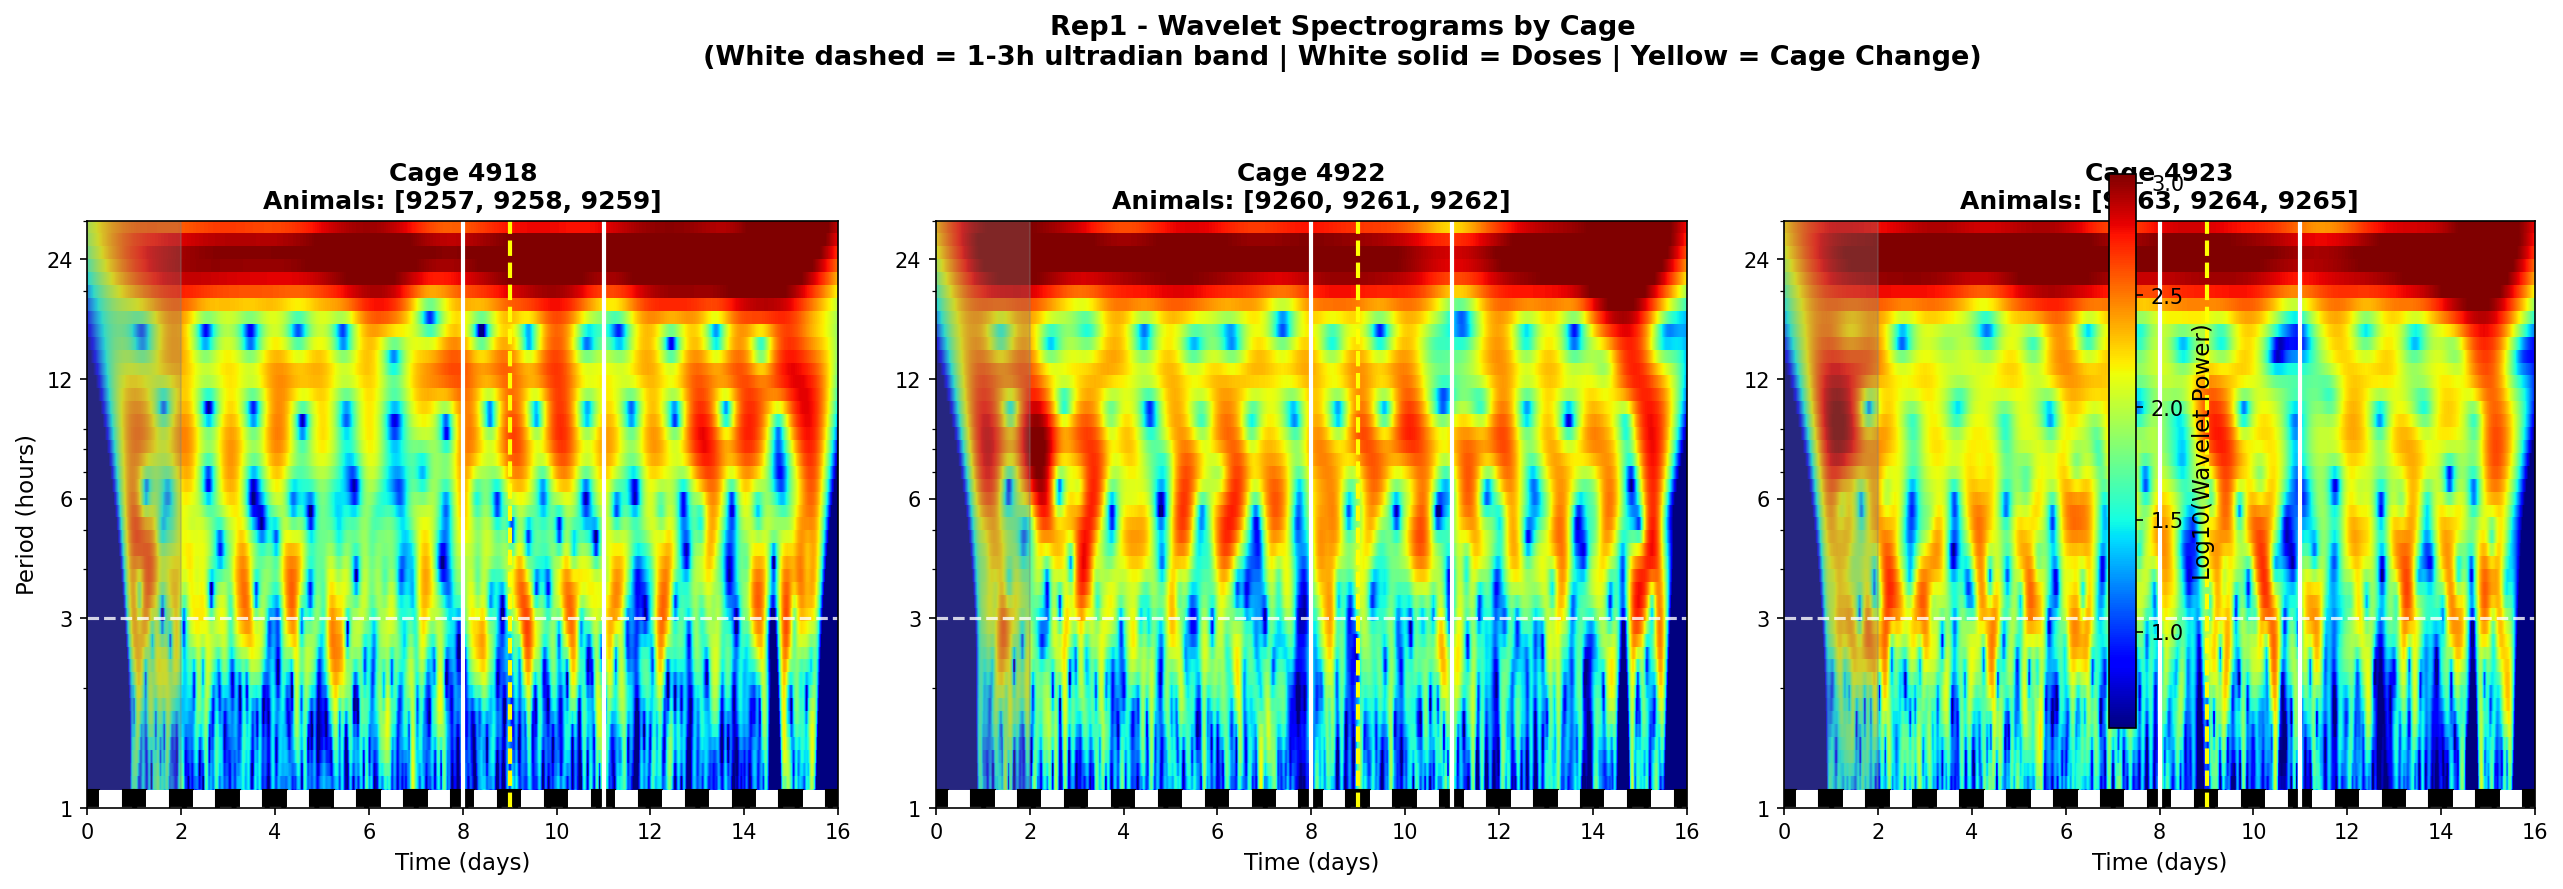

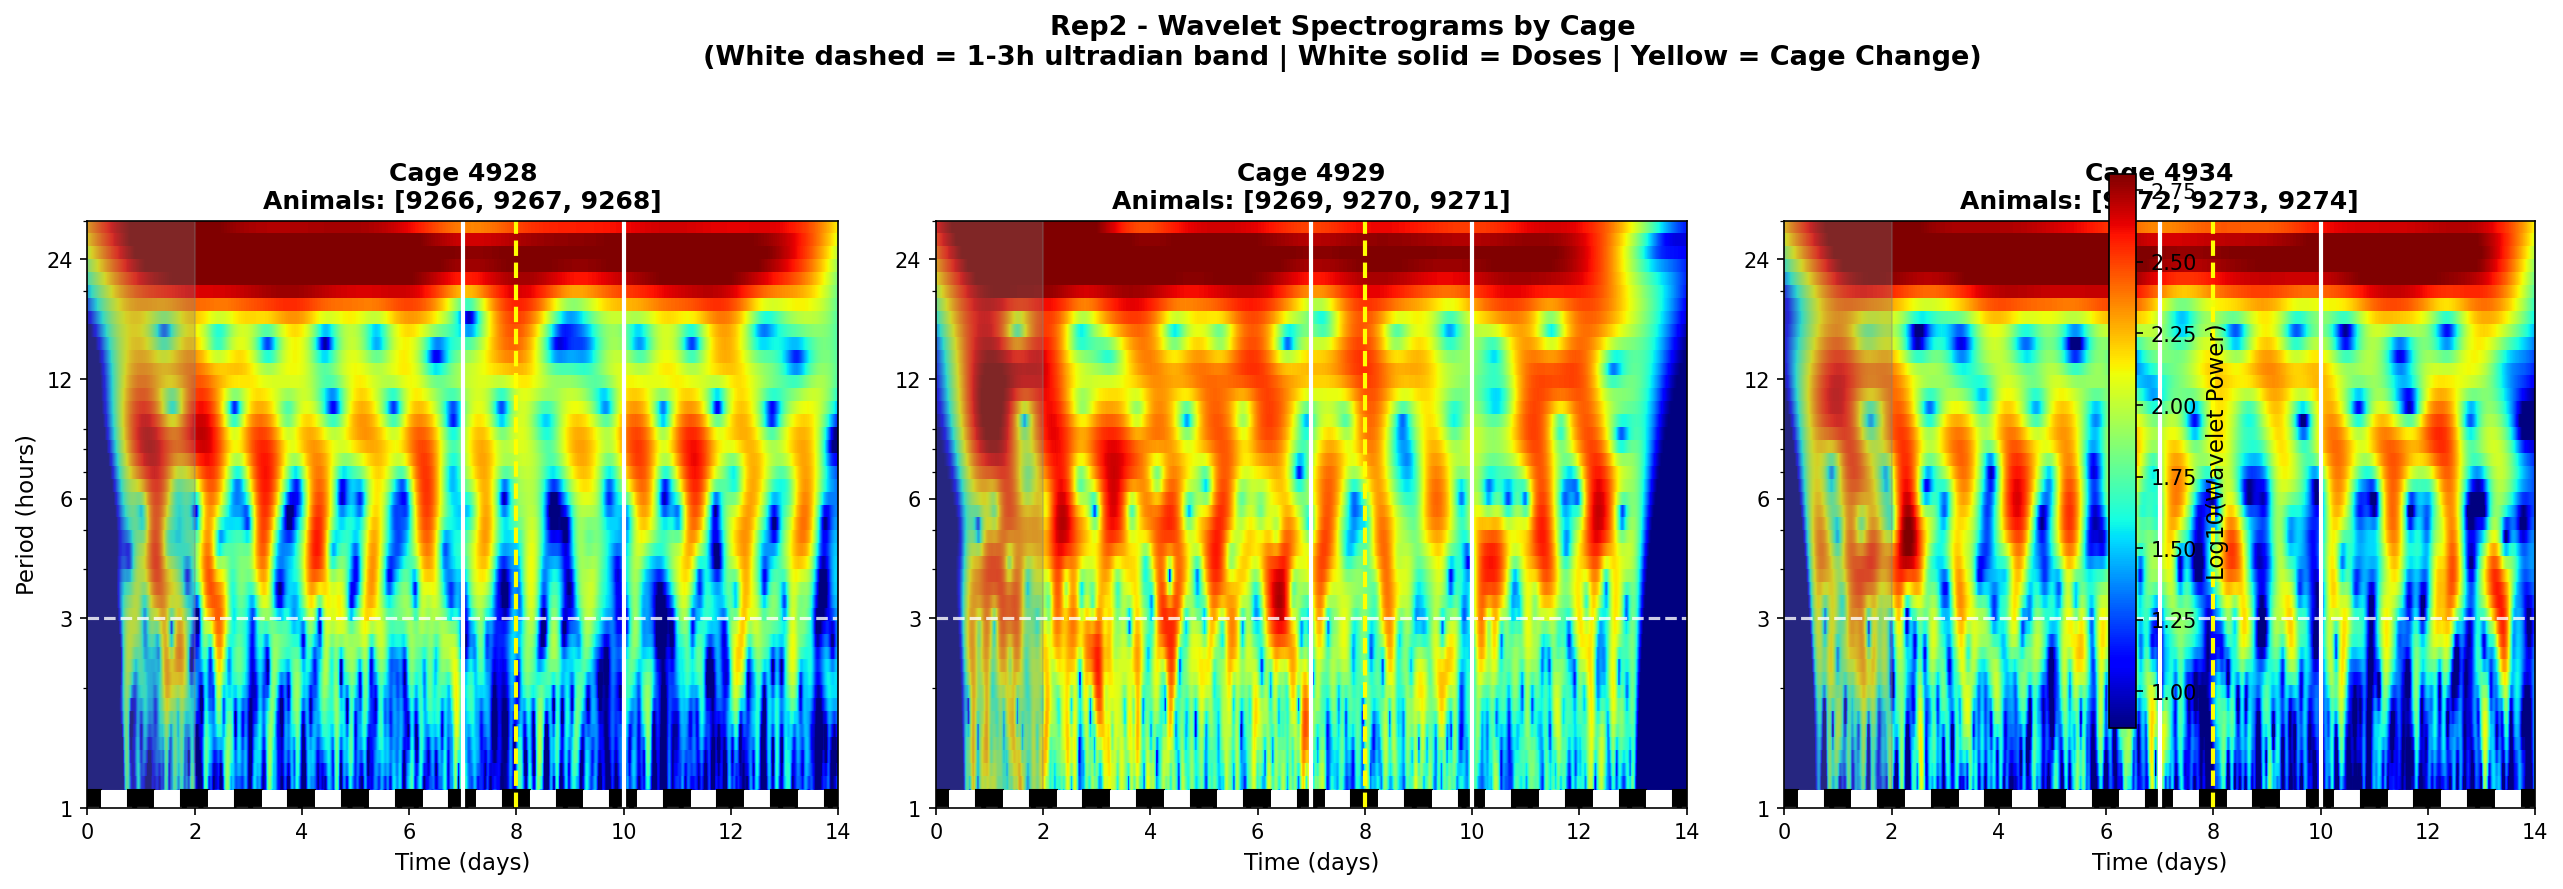

In [12]:
# =============================================================================
# SPECTROGRAM - SEPARATE PLOTS FOR EACH REPLICATE
# =============================================================================

for rep, results in all_rep_results.items():
    cfg = VEHICLE_CAGES[rep]
    animal_results = results['animal_results']
    valid_days = cfg['valid_days']
    
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    for col, cage_id in enumerate(cfg['cages']):
        ax = axes[col]
        cage_animals = [r for r in animal_results if r['cage_id'] == cage_id]
        
        # Average power across cage
        all_powers = []
        for r in cage_animals:
            animal_df = df_loco[(df_loco['replicate'] == rep) & (df_loco['animal_id'] == r['animal_id'])]
            animal_ts = bouts_to_minute_counts_calendar(animal_df, cfg['analysis_start'], cfg['n_days'])
            power, periods = compute_wavelet_transform(animal_ts, PERIODS_MINUTES)
            all_powers.append(power)
        
        mean_power = np.mean(all_powers, axis=0)
        periods_hours = periods / 60
        time_days = np.arange(mean_power.shape[1]) / MINUTES_PER_DAY
        
        # Log transform for visualization
        log_power = np.log10(mean_power + 1)
        
        # Plot with jet colormap (Smarr-style)
        im = ax.pcolormesh(time_days, periods_hours, log_power, 
                          cmap='jet', shading='auto',
                          vmin=np.percentile(log_power, 5),
                          vmax=np.percentile(log_power, 95))
        ax.set_yscale('log')
        ax.set_ylim(1, 30)
        ax.set_yticks([1, 3, 6, 12, 24])
        ax.set_yticklabels(['1', '3', '6', '12', '24'])
        
        # Mark ultradian band (1-3h)
        ax.axhline(y=1, color='white', linestyle='--', linewidth=1.5, alpha=0.8)
        ax.axhline(y=3, color='white', linestyle='--', linewidth=1.5, alpha=0.8)
        
        # Treatment markers
        ax.axvline(x=cfg['dose_1_day'], color='white', linestyle='-', linewidth=2)
        ax.axvline(x=cfg['dose_2_day'], color='white', linestyle='-', linewidth=2)
        ax.axvline(x=cfg['cage_change_day'], color='yellow', linestyle='--', linewidth=2)
        
        # Gray out excluded days
        ax.axvspan(0, valid_days[0], alpha=0.3, color='gray')
        
        # Light/dark bars at bottom
        for day in range(cfg['n_days']):
            ax.axvspan(day, day + 0.25, ymin=0, ymax=0.03, color='black')
            ax.axvspan(day + 0.25, day + 0.75, ymin=0, ymax=0.03, color='white', edgecolor='black', linewidth=0.5)
            ax.axvspan(day + 0.75, day + 1, ymin=0, ymax=0.03, color='black')
        
        ax.set_xlabel('Time (days)', fontsize=11)
        if col == 0:
            ax.set_ylabel('Period (hours)', fontsize=11)
        
        animal_ids = [r['animal_id'] for r in cage_animals]
        ax.set_title(f'Cage {cage_id}\nAnimals: {animal_ids}', fontsize=12, fontweight='bold')
        ax.set_xlim(0, cfg['n_days'])
    
    # Colorbar
    cbar = fig.colorbar(im, ax=axes.ravel().tolist(), shrink=0.8, pad=0.02)
    cbar.set_label('Log10(Wavelet Power)', fontsize=11)
    
    fig.suptitle(f'{rep} - Wavelet Spectrograms by Cage\n(White dashed = 1-3h ultradian band | White solid = Doses | Yellow = Cage Change)', 
                 fontsize=13, fontweight='bold')
    plt.tight_layout(rect=[0, 0, 0.95, 0.93])
    plt.savefig(f'morph2rep_{rep}_spectrograms.png', dpi=150, bbox_inches='tight')
    plt.show()

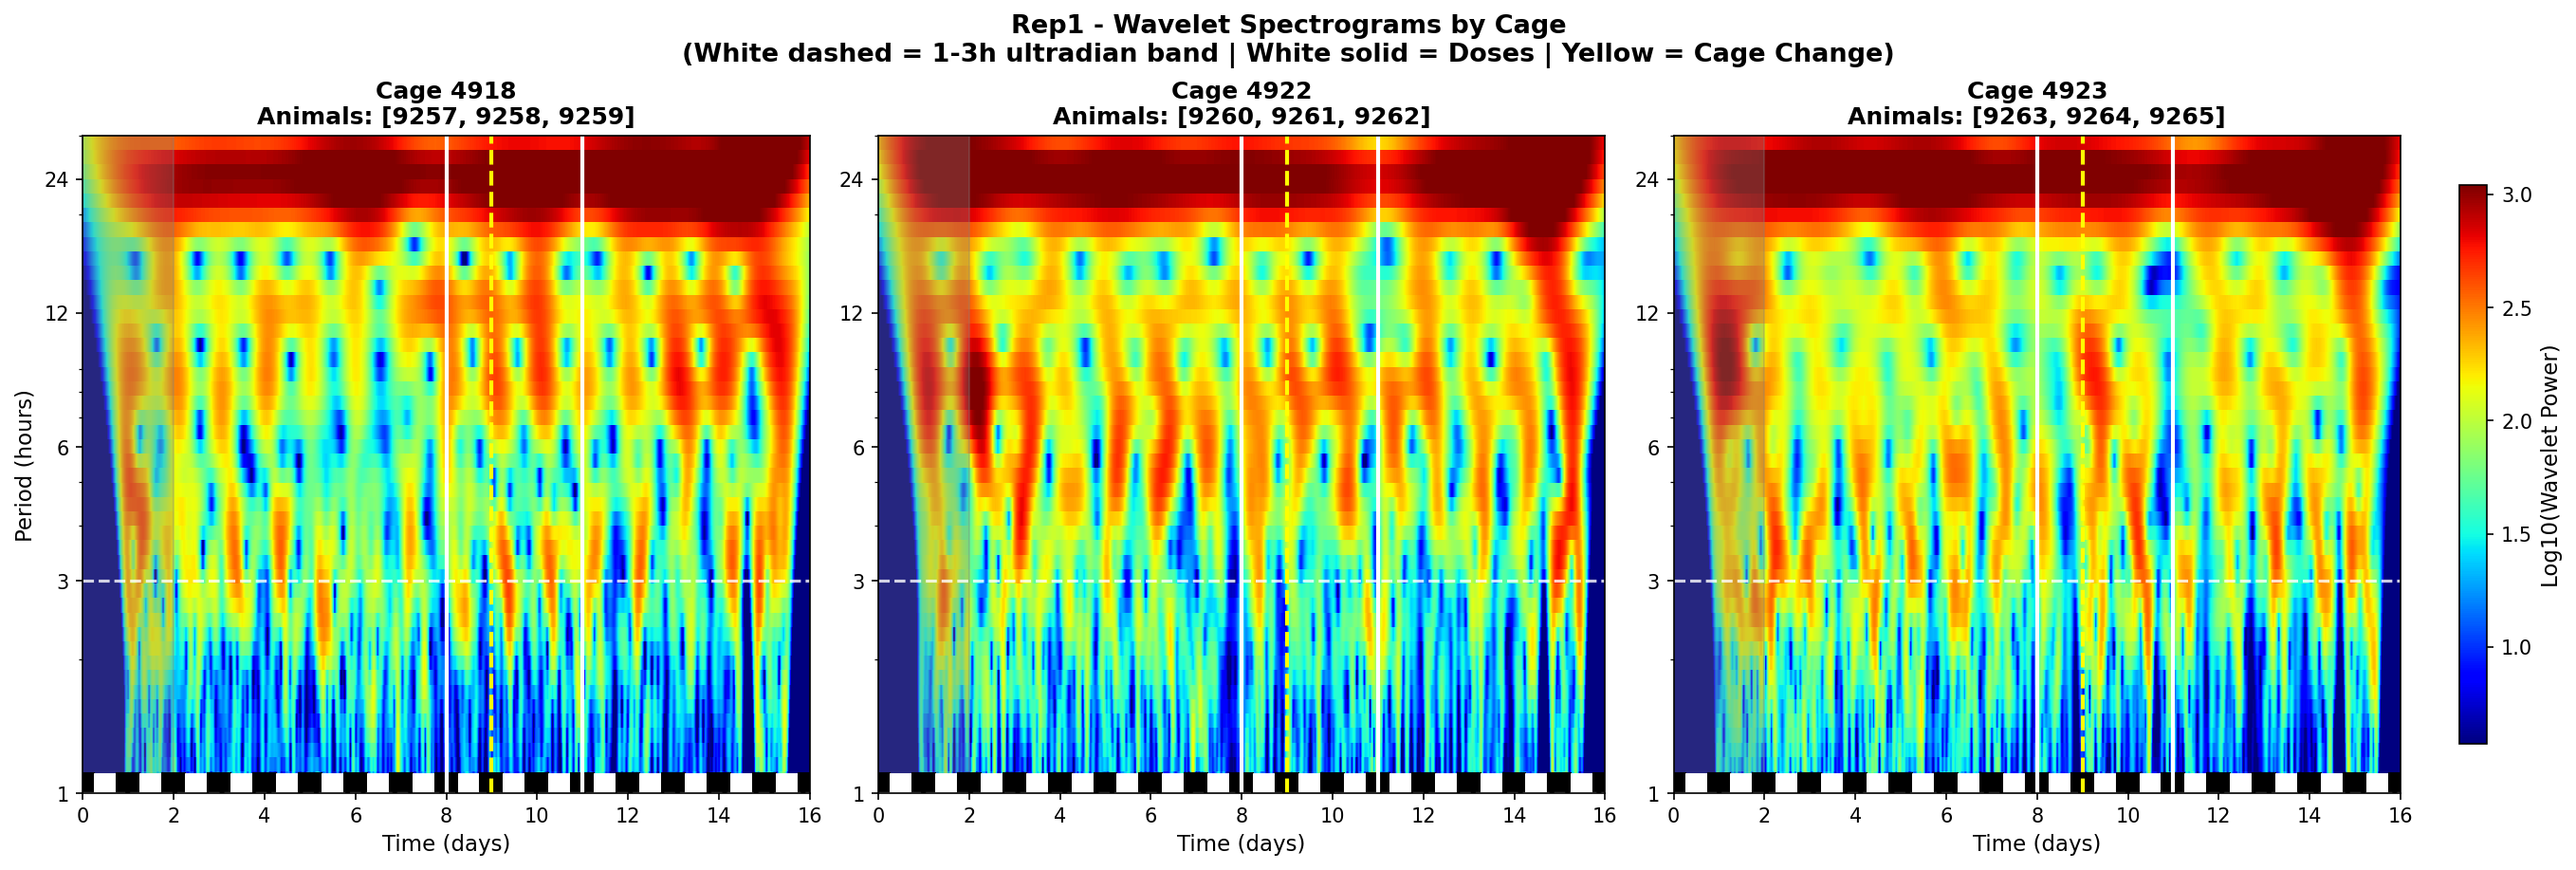

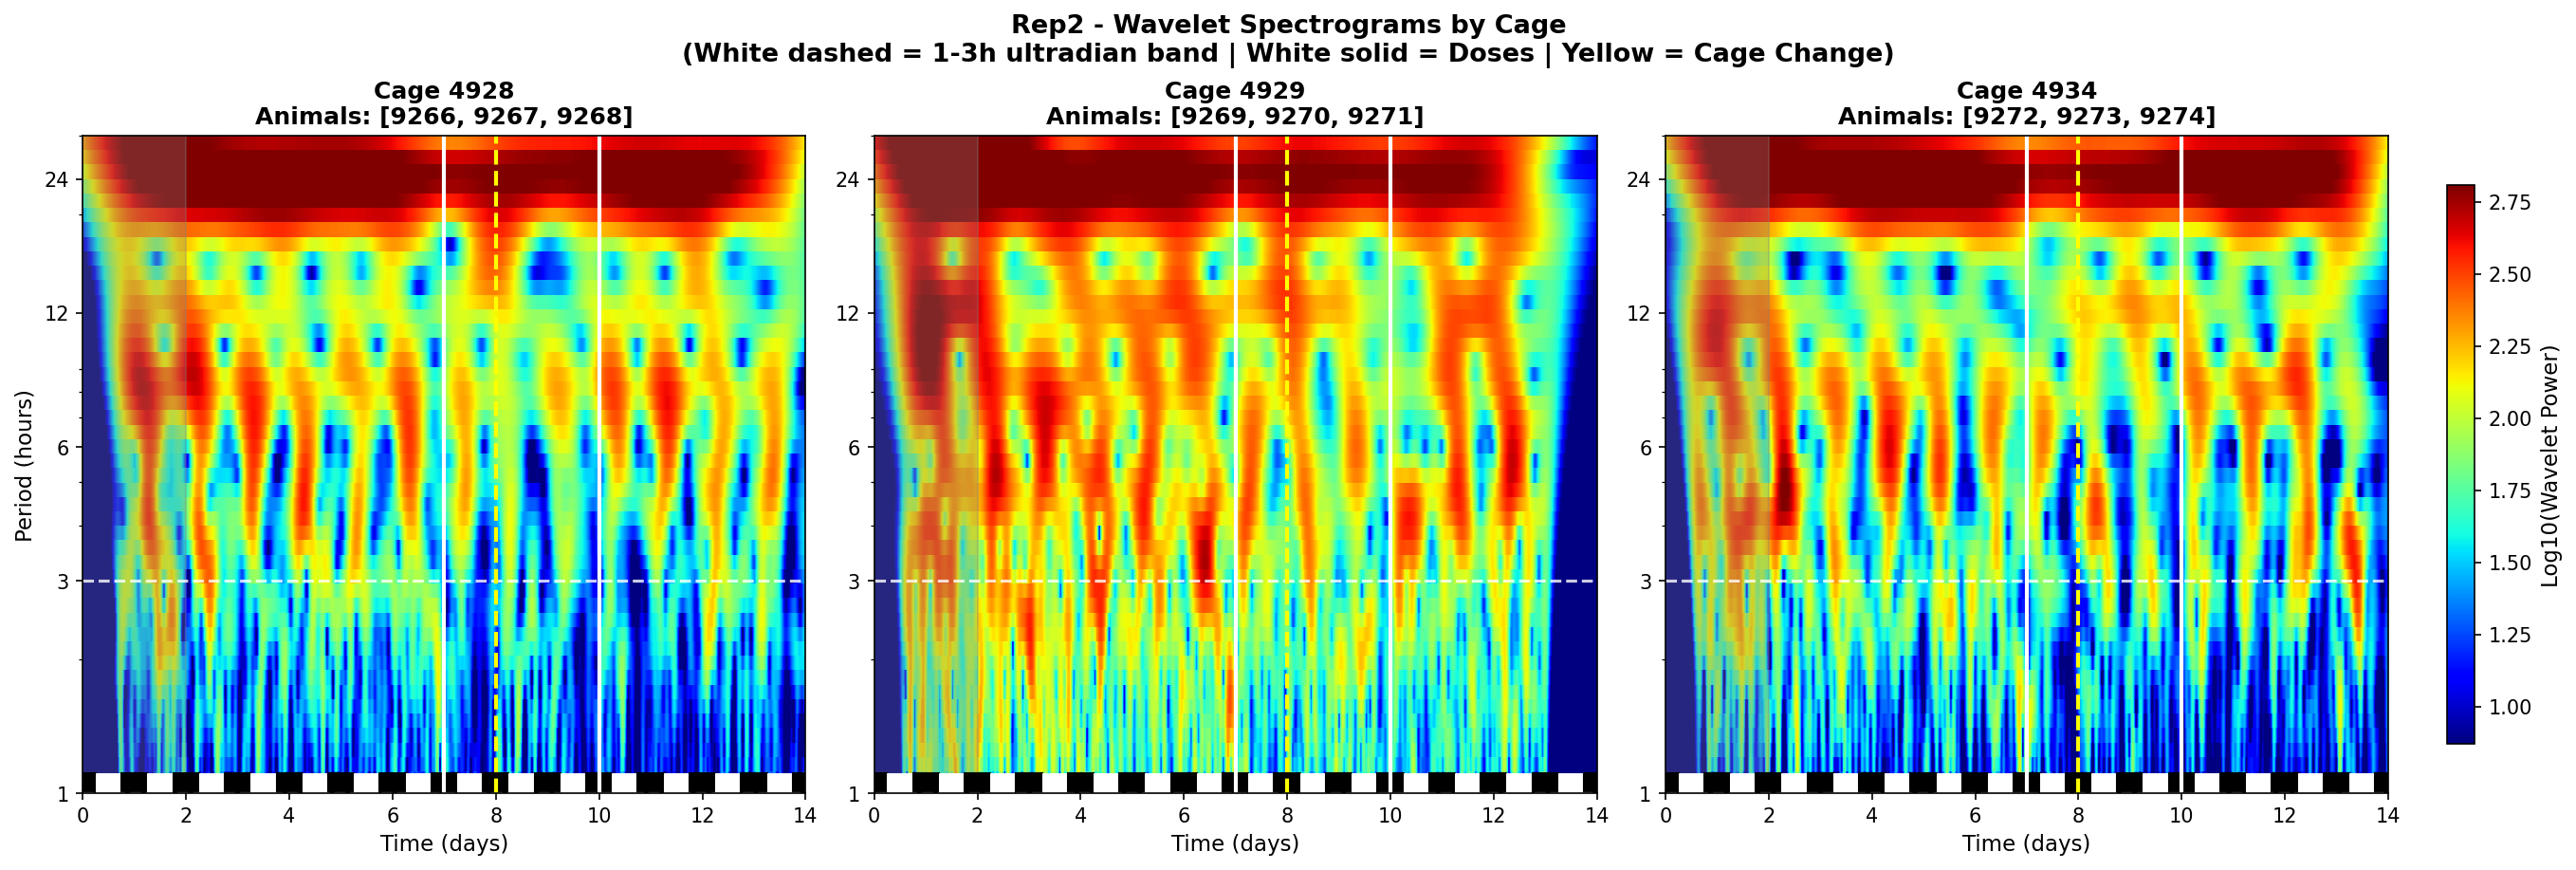

In [19]:
# =============================================================================
# SPECTROGRAM - SEPARATE PLOTS FOR EACH REPLICATE (FIXED COLORBAR OVERLAP)
# Uses constrained_layout so the colorbar no longer overlaps the subplots.
# =============================================================================

for rep, results in all_rep_results.items():
    cfg = VEHICLE_CAGES[rep]
    animal_results = results['animal_results']
    valid_days = cfg['valid_days']

    # FIX: constrained_layout handles spacing for colorbar + suptitle cleanly
    fig, axes = plt.subplots(1, 3, figsize=(18, 6), constrained_layout=True)

    for col, cage_id in enumerate(cfg['cages']):
        ax = axes[col]
        cage_animals = [r for r in animal_results if r['cage_id'] == cage_id]

        # Average power across cage
        all_powers = []
        for r in cage_animals:
            animal_df = df_loco[
                (df_loco['replicate'] == rep) &
                (df_loco['animal_id'] == r['animal_id'])
            ]
            animal_ts = bouts_to_minute_counts_calendar(
                animal_df, cfg['analysis_start'], cfg['n_days']
            )
            power, periods = compute_wavelet_transform(animal_ts, PERIODS_MINUTES)
            all_powers.append(power)

        mean_power = np.mean(all_powers, axis=0)
        periods_hours = periods / 60
        time_days = np.arange(mean_power.shape[1]) / MINUTES_PER_DAY

        # Log transform for visualization
        log_power = np.log10(mean_power + 1)

        # Plot with jet colormap (Smarr-style)
        im = ax.pcolormesh(
            time_days,
            periods_hours,
            log_power,
            cmap='jet',
            shading='auto',
            vmin=np.percentile(log_power, 5),
            vmax=np.percentile(log_power, 95)
        )

        ax.set_yscale('log')
        ax.set_ylim(1, 30)
        ax.set_yticks([1, 3, 6, 12, 24])
        ax.set_yticklabels(['1', '3', '6', '12', '24'])

        # Mark ultradian band (1-3h)
        ax.axhline(y=1, color='white', linestyle='--', linewidth=1.5, alpha=0.8)
        ax.axhline(y=3, color='white', linestyle='--', linewidth=1.5, alpha=0.8)

        # Treatment markers
        ax.axvline(x=cfg['dose_1_day'], color='white', linestyle='-', linewidth=2)
        ax.axvline(x=cfg['dose_2_day'], color='white', linestyle='-', linewidth=2)
        ax.axvline(x=cfg['cage_change_day'], color='yellow', linestyle='--', linewidth=2)

        # Gray out excluded days
        ax.axvspan(0, valid_days[0], alpha=0.3, color='gray')

        # Light/dark bars at bottom
        for day in range(cfg['n_days']):
            ax.axvspan(day, day + 0.25, ymin=0, ymax=0.03, color='black')
            ax.axvspan(day + 0.25, day + 0.75, ymin=0, ymax=0.03,
                       color='white', edgecolor='black', linewidth=0.5)
            ax.axvspan(day + 0.75, day + 1, ymin=0, ymax=0.03, color='black')

        ax.set_xlabel('Time (days)', fontsize=11)
        if col == 0:
            ax.set_ylabel('Period (hours)', fontsize=11)

        animal_ids = [r['animal_id'] for r in cage_animals]
        ax.set_title(f'Cage {cage_id}\nAnimals: {animal_ids}',
                     fontsize=12, fontweight='bold')

        ax.set_xlim(0, cfg['n_days'])

    # FIX: colorbar placed cleanly at figure level, spaced by constrained_layout
    cbar = fig.colorbar(
        im,
        ax=axes,            # apply to all 3 axes
        location="right",   # keep it on the right
        shrink=0.85,
        pad=0.02
    )
    cbar.set_label('Log10(Wavelet Power)', fontsize=11)

    fig.suptitle(
        f'{rep} - Wavelet Spectrograms by Cage\n'
        '(White dashed = 1-3h ultradian band | White solid = Doses | Yellow = Cage Change)',
        fontsize=13, fontweight='bold'
    )

    # IMPORTANT: do NOT call plt.tight_layout when using constrained_layout
    plt.savefig(f'morph2rep_{rep}_spectrograms.png', dpi=150, bbox_inches='tight')
    plt.show()


---
## Section 6: Summary

In [13]:
# =============================================================================
# SUMMARY
# =============================================================================
print("="*70)
print("SUMMARY: MORPH2REP ESTROUS CYCLE DETECTION (Calendar Days)")
print("="*70)

print("\n--- Configuration ---")
print(f"{'Replicate':<10} {'Date Range':<25} {'Valid Days':<15} {'Excluded'}")
print("-"*70)
for rep, cfg in VEHICLE_CAGES.items():
    valid = f"Days {cfg['valid_days'][0]}-{cfg['valid_days'][1]}"
    excluded = f"Day 1" if cfg['valid_days'][0] > 1 else "None"
    print(f"{rep:<10} {cfg['analysis_start']} to {cfg['analysis_end']:<10} {valid:<15} {excluded}")

print("\n--- Results ---")
print(f"\n{'Metric':<35} {'Rep1':<15} {'Rep2':<15}")
print("-"*65)

rep1 = all_rep_results['Rep1']
rep2 = all_rep_results['Rep2']

print(f"{'Animals analyzed':<35} {rep1['n_total']:<15} {rep2['n_total']:<15}")
print(f"{'Strong 4-day cycling':<35} {rep1['n_strong']}/{rep1['n_total']:<15} {rep2['n_strong']}/{rep2['n_total']:<15}")
print(f"{'Moderate evidence':<35} {rep1['n_moderate']}/{rep1['n_total']:<15} {rep2['n_moderate']}/{rep2['n_total']:<15}")

p1 = f"p={rep1['p_chi']:.4f}" if rep1['p_chi'] else "N/A"
p2 = f"p={rep2['p_chi']:.4f}" if rep2['p_chi'] else "N/A"
print(f"{'Phase clustering':<35} {p1:<15} {p2:<15}")

print("\n--- Treatment Timeline (Calendar Days) ---")
print(f"\n{'Event':<15} {'Rep1':<30} {'Rep2':<30}")
print("-"*75)
print(f"{'Dose 1':<15} Day {VEHICLE_CAGES['Rep1']['dose_1_day']} ({VEHICLE_CAGES['Rep1']['dose_1'].strftime('%b %d, %I%p')}){'  ':<5} Day {VEHICLE_CAGES['Rep2']['dose_1_day']} ({VEHICLE_CAGES['Rep2']['dose_1'].strftime('%b %d, %I%p')})")
print(f"{'Cage Change':<15} Day {VEHICLE_CAGES['Rep1']['cage_change_day']} ({VEHICLE_CAGES['Rep1']['cage_change'].strftime('%b %d, %I%p')}){'  ':<5} Day {VEHICLE_CAGES['Rep2']['cage_change_day']} ({VEHICLE_CAGES['Rep2']['cage_change'].strftime('%b %d, %I%p')})")
print(f"{'Dose 2':<15} Day {VEHICLE_CAGES['Rep1']['dose_2_day']} ({VEHICLE_CAGES['Rep1']['dose_2'].strftime('%b %d, %I%p')}){'  ':<5} Day {VEHICLE_CAGES['Rep2']['dose_2_day']} ({VEHICLE_CAGES['Rep2']['dose_2'].strftime('%b %d, %I%p')})")

SUMMARY: MORPH2REP ESTROUS CYCLE DETECTION (Calendar Days)

--- Configuration ---
Replicate  Date Range                Valid Days      Excluded
----------------------------------------------------------------------
Rep1       2025-01-07 to 2025-01-22 Days 2-16       Day 1
Rep2       2025-01-22 to 2025-02-04 Days 2-14       Day 1

--- Results ---

Metric                              Rep1            Rep2           
-----------------------------------------------------------------
Animals analyzed                    9               9              
Strong 4-day cycling                6/9               5/9              
Moderate evidence                   2/9               1/9              
Phase clustering                    p=0.0444        p=0.0675       

--- Treatment Timeline (Calendar Days) ---

Event           Rep1                           Rep2                          
---------------------------------------------------------------------------
Dose 1          Day 8 (Jan 14, 06AM)  

In [14]:
# =============================================================================
# LIST OF SAVED FIGURES
# =============================================================================
print("\n" + "="*60)
print("SAVED FIGURES:")
print("="*60)
print("  1. morph2rep_calendar_data_completeness.png")
print("  2. morph2rep_Rep1_calendar_bars.png")
print("  3. morph2rep_Rep2_calendar_bars.png")
print("  4. morph2rep_calendar_heatmap.png")


SAVED FIGURES:
  1. morph2rep_calendar_data_completeness.png
  2. morph2rep_Rep1_calendar_bars.png
  3. morph2rep_Rep2_calendar_bars.png
  4. morph2rep_calendar_heatmap.png


---
## Conclusions

### Time Alignment Choice

We used **calendar day alignment** (midnight to midnight) rather than Smarr's circadian time alignment (6PM to 6PM) because:
1. Direct mapping to treatment schedule dates
2. Simpler interpretation
3. Preserves more data (Day 16 in Rep1 has 13 hours of usable data)
4. Daily averaging minimizes the impact of specific hour boundaries

### Data Quality

- **Rep1:** Day 1 excluded (only 2 hours of recording); Days 2-16 valid
- **Rep2:** Day 1 excluded (only 10 hours of recording); Days 2-14 valid

### Estrous Cycling Evidence

Results from calendar day analysis show similar patterns to the time-shifted approach:
- **Rep1:** Modest evidence of cycling, with individual animals showing 4-day patterns but no strong phase synchronization
- **Rep2:** Weaker evidence, with LOW days tending to cluster late in the recording period

The lack of strong phase clustering in both replicates suggests that while individual females may be cycling, they are not synchronized to a common phase—consistent with the expected "staggered" condition in group-housed females without male pheromone exposure.

INVESTIGATING HANDLING EFFECTS ON ULTRADIAN POWER

Rep1:
--------------------------------------------------
Event days: {'Dose 1': 8, 'Cage Change': 9, 'Dose 2': 11}

Mean ultradian power:
  Event days (± 1 day):  99.8 (n=45)
  Non-event days:        116.8 (n=90)
  Ratio: 0.85
  Mann-Whitney U (event < non-event): p=0.0286

LOW days on event days:
  Event days span: 5/15 days (33.3% of valid days)
  LOW days on event days: 16/39 (41.0%)
  Enrichment: 1.2x expected

Rep2:
--------------------------------------------------
Event days: {'Dose 1': 7, 'Cage Change': 8, 'Dose 2': 10}

Mean ultradian power:
  Event days (± 1 day):  77.4 (n=45)
  Non-event days:        98.4 (n=72)
  Ratio: 0.79
  Mann-Whitney U (event < non-event): p=0.0015

LOW days on event days:
  Event days span: 5/13 days (38.5% of valid days)
  LOW days on event days: 14/28 (50.0%)
  Enrichment: 1.3x expected


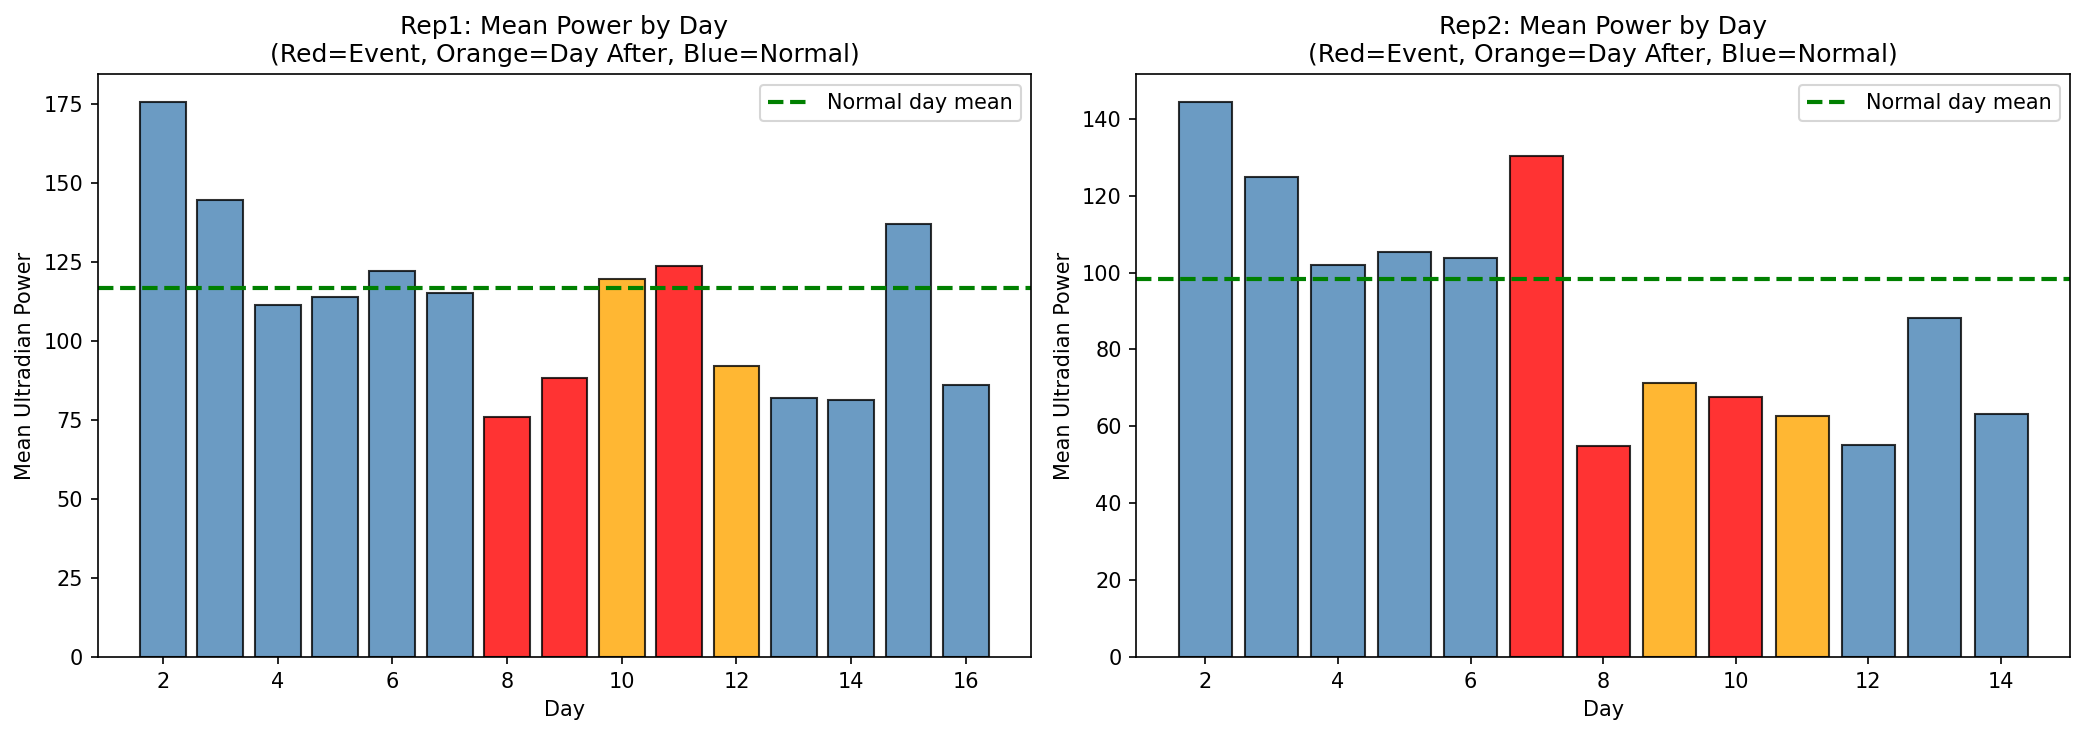

In [15]:
# =============================================================================
# INVESTIGATE: DO LOW DAYS CLUSTER AROUND HANDLING EVENTS?
# =============================================================================

print("="*70)
print("INVESTIGATING HANDLING EFFECTS ON ULTRADIAN POWER")
print("="*70)

for rep, results in all_rep_results.items():
    cfg = VEHICLE_CAGES[rep]
    animal_results = results['animal_results']
    cycle_results = results['cycle_results']
    
    print(f"\n{rep}:")
    print("-"*50)
    
    # Define event days
    event_days = {
        'Dose 1': cfg['dose_1_day'],
        'Cage Change': cfg['cage_change_day'],
        'Dose 2': cfg['dose_2_day'],
    }
    
    print(f"Event days: {event_days}")
    
    # Collect power values for event days vs non-event days
    event_day_powers = []
    non_event_day_powers = []
    
    # Also check day AFTER each event (stress may persist)
    event_and_next = set()
    for day in event_days.values():
        event_and_next.add(day)
        event_and_next.add(day + 1)
    
    valid_days = cfg['valid_days']
    
    for r in animal_results:
        day_powers = r['day_powers']
        for day in range(valid_days[0], valid_days[1] + 1):
            idx = day - 1
            if idx < len(day_powers) and not np.isnan(day_powers[idx]):
                if day in event_and_next:
                    event_day_powers.append(day_powers[idx])
                else:
                    non_event_day_powers.append(day_powers[idx])
    
    # Compare
    mean_event = np.mean(event_day_powers)
    mean_non_event = np.mean(non_event_day_powers)
    
    print(f"\nMean ultradian power:")
    print(f"  Event days (± 1 day):  {mean_event:.1f} (n={len(event_day_powers)})")
    print(f"  Non-event days:        {mean_non_event:.1f} (n={len(non_event_day_powers)})")
    print(f"  Ratio: {mean_event/mean_non_event:.2f}")
    
    # Statistical test
    from scipy.stats import mannwhitneyu
    stat, p = mannwhitneyu(event_day_powers, non_event_day_powers, alternative='less')
    print(f"  Mann-Whitney U (event < non-event): p={p:.4f}")
    
    # Count LOW days on event days vs expected
    all_low_days = []
    for cr in cycle_results:
        all_low_days.extend(cr['low_days'])
    
    low_on_event = sum(1 for d in all_low_days if d in event_and_next)
    total_low = len(all_low_days)
    
    n_event_days = len(event_and_next)
    n_valid_days = valid_days[1] - valid_days[0] + 1
    expected_pct = n_event_days / n_valid_days
    actual_pct = low_on_event / total_low if total_low > 0 else 0
    
    print(f"\nLOW days on event days:")
    print(f"  Event days span: {n_event_days}/{n_valid_days} days ({expected_pct*100:.1f}% of valid days)")
    print(f"  LOW days on event days: {low_on_event}/{total_low} ({actual_pct*100:.1f}%)")
    print(f"  Enrichment: {actual_pct/expected_pct:.1f}x expected" if expected_pct > 0 else "")


# =============================================================================
# VISUALIZE: POWER BY DAY TYPE
# =============================================================================
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for col, (rep, results) in enumerate(all_rep_results.items()):
    ax = axes[col]
    cfg = VEHICLE_CAGES[rep]
    animal_results = results['animal_results']
    valid_days = cfg['valid_days']
    
    # Event days
    event_days_set = {cfg['dose_1_day'], cfg['cage_change_day'], cfg['dose_2_day']}
    event_next_set = {d + 1 for d in event_days_set}
    
    # Collect mean power per day across animals
    day_means = []
    day_types = []
    
    for day in range(valid_days[0], valid_days[1] + 1):
        powers = [r['day_powers'][day-1] for r in animal_results 
                  if day-1 < len(r['day_powers']) and not np.isnan(r['day_powers'][day-1])]
        if powers:
            day_means.append(np.mean(powers))
            if day in event_days_set:
                day_types.append('Event')
            elif day in event_next_set:
                day_types.append('Day After')
            else:
                day_types.append('Normal')
    
    days = list(range(valid_days[0], valid_days[0] + len(day_means)))
    colors = {'Event': 'red', 'Day After': 'orange', 'Normal': 'steelblue'}
    bar_colors = [colors[t] for t in day_types]
    
    ax.bar(days, day_means, color=bar_colors, edgecolor='black', alpha=0.8)
    ax.axhline(y=np.mean([m for m, t in zip(day_means, day_types) if t == 'Normal']), 
               color='green', linestyle='--', linewidth=2, label='Normal day mean')
    
    ax.set_xlabel('Day')
    ax.set_ylabel('Mean Ultradian Power')
    ax.set_title(f'{rep}: Mean Power by Day\n(Red=Event, Orange=Day After, Blue=Normal)')
    ax.legend()

plt.tight_layout()
plt.savefig('morph2rep_handling_effects.png', dpi=150, bbox_inches='tight')
plt.show()

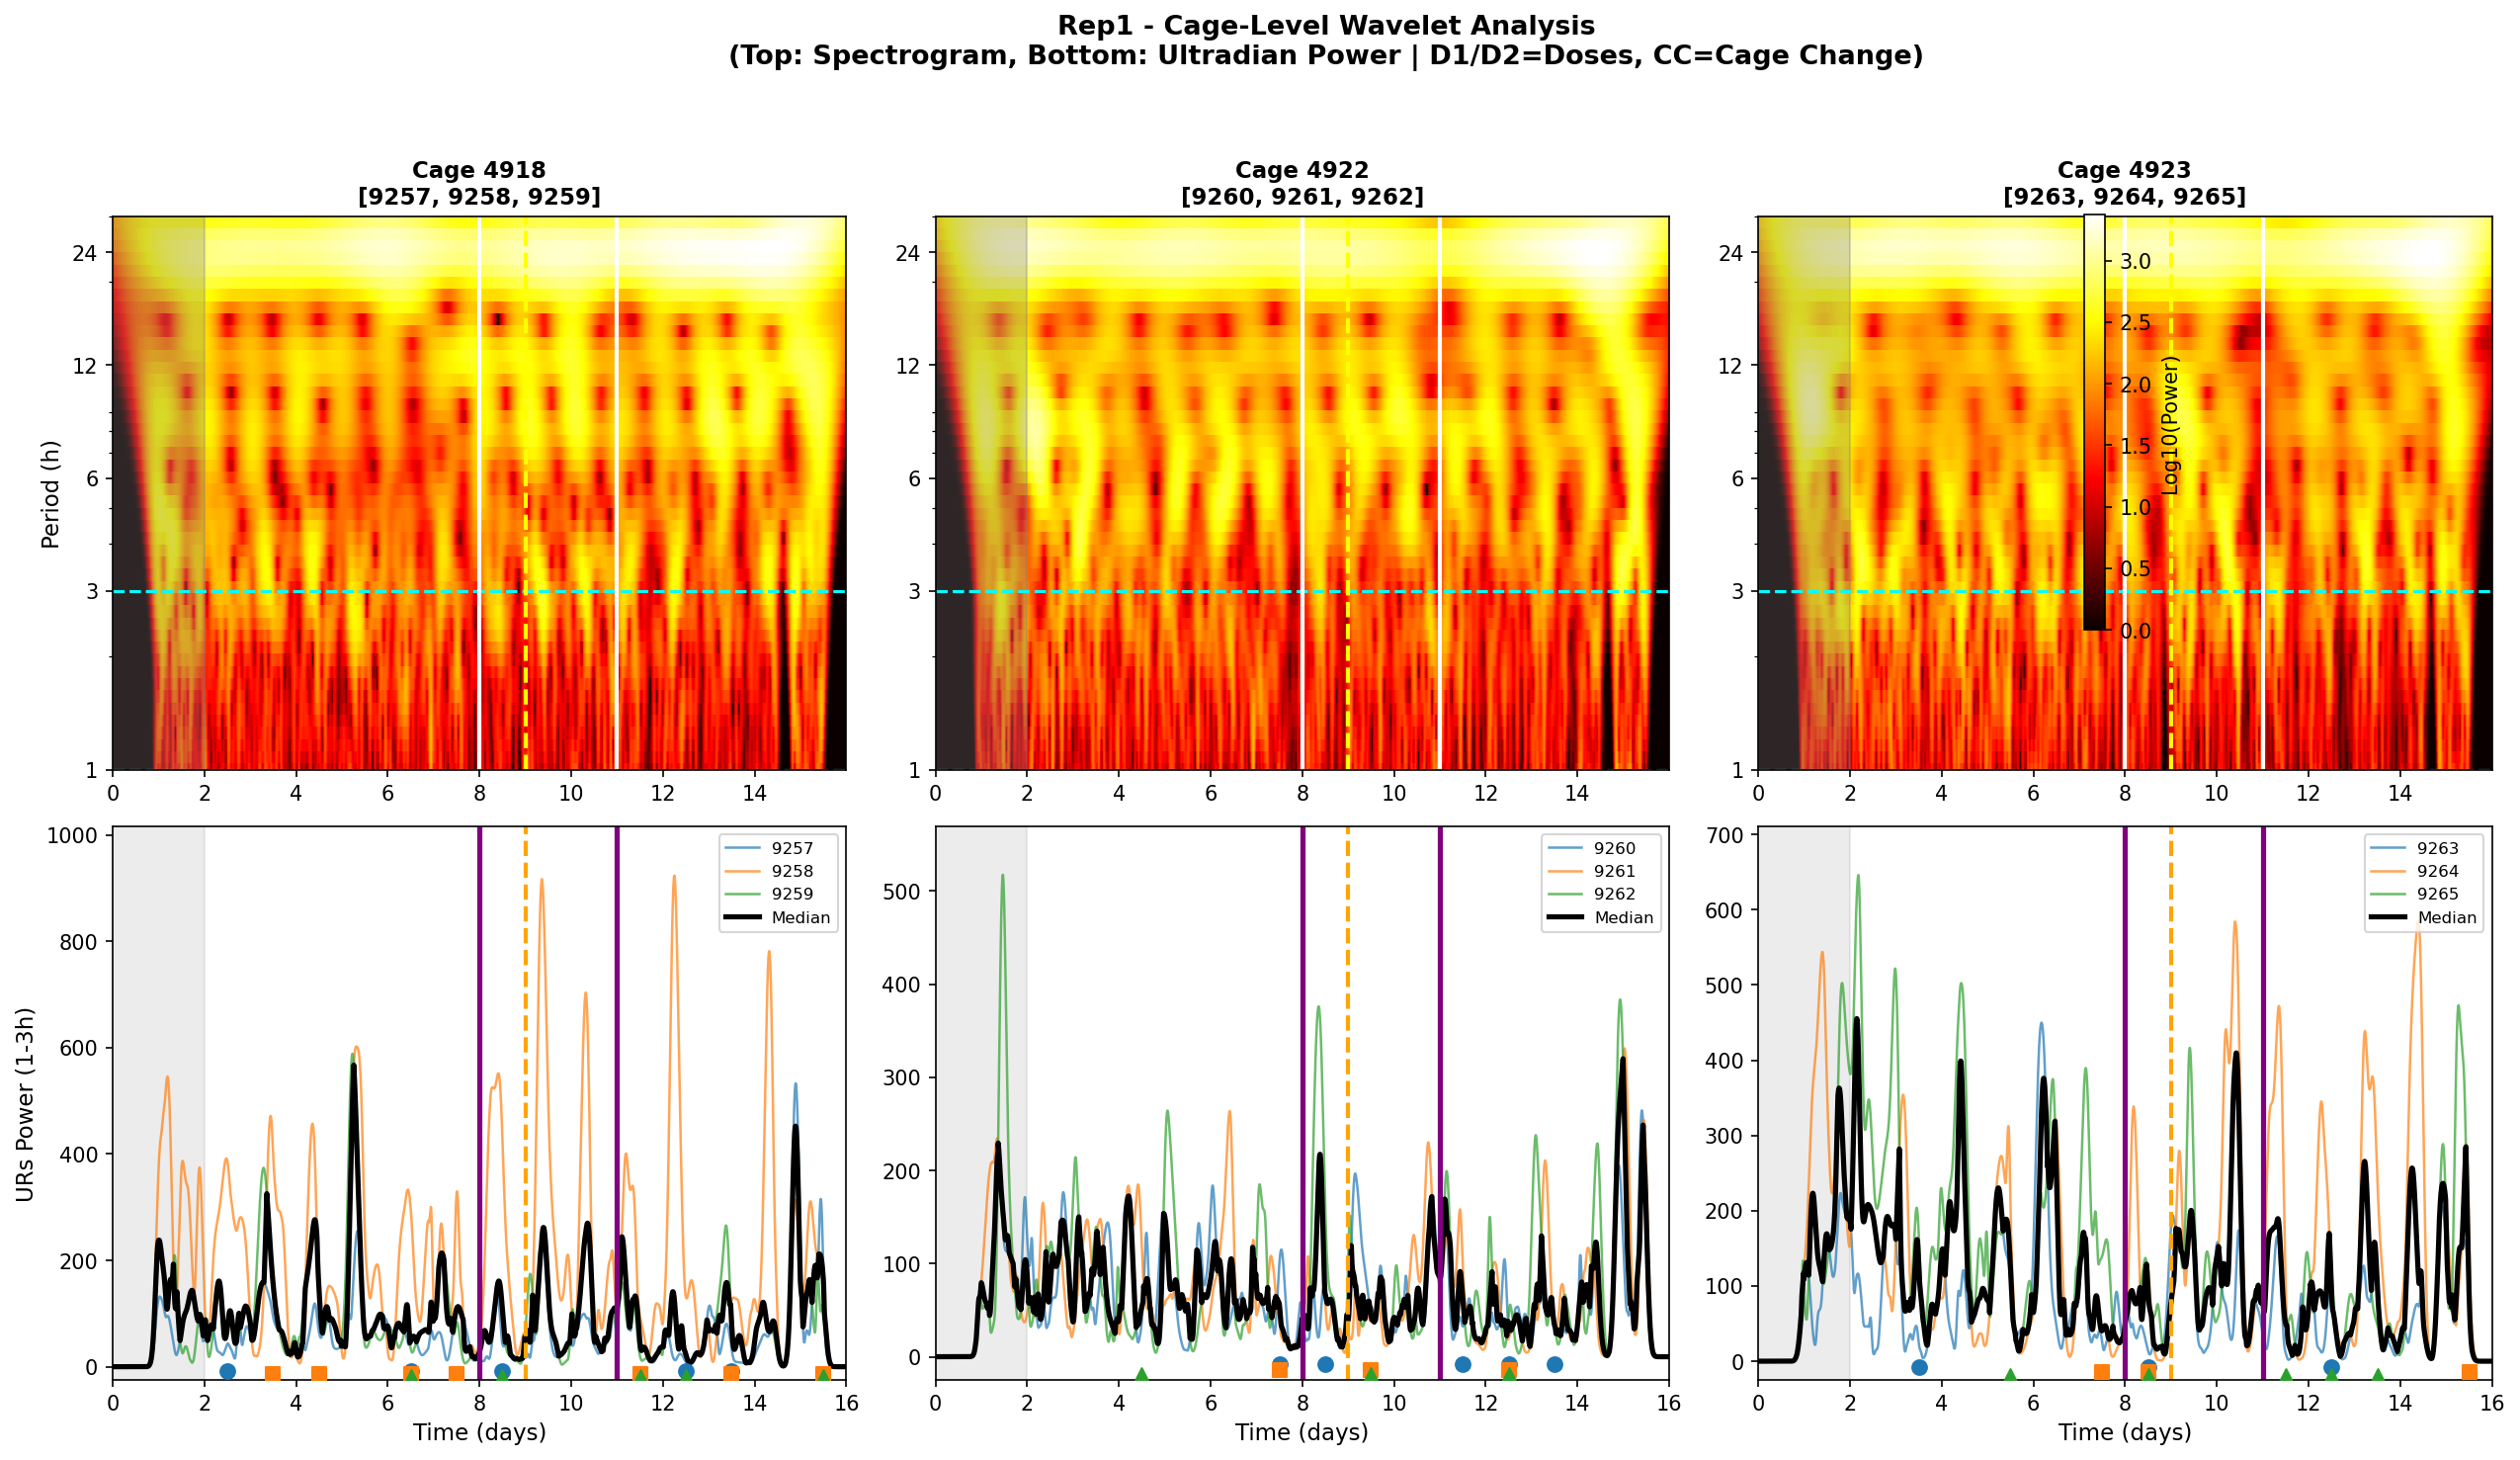

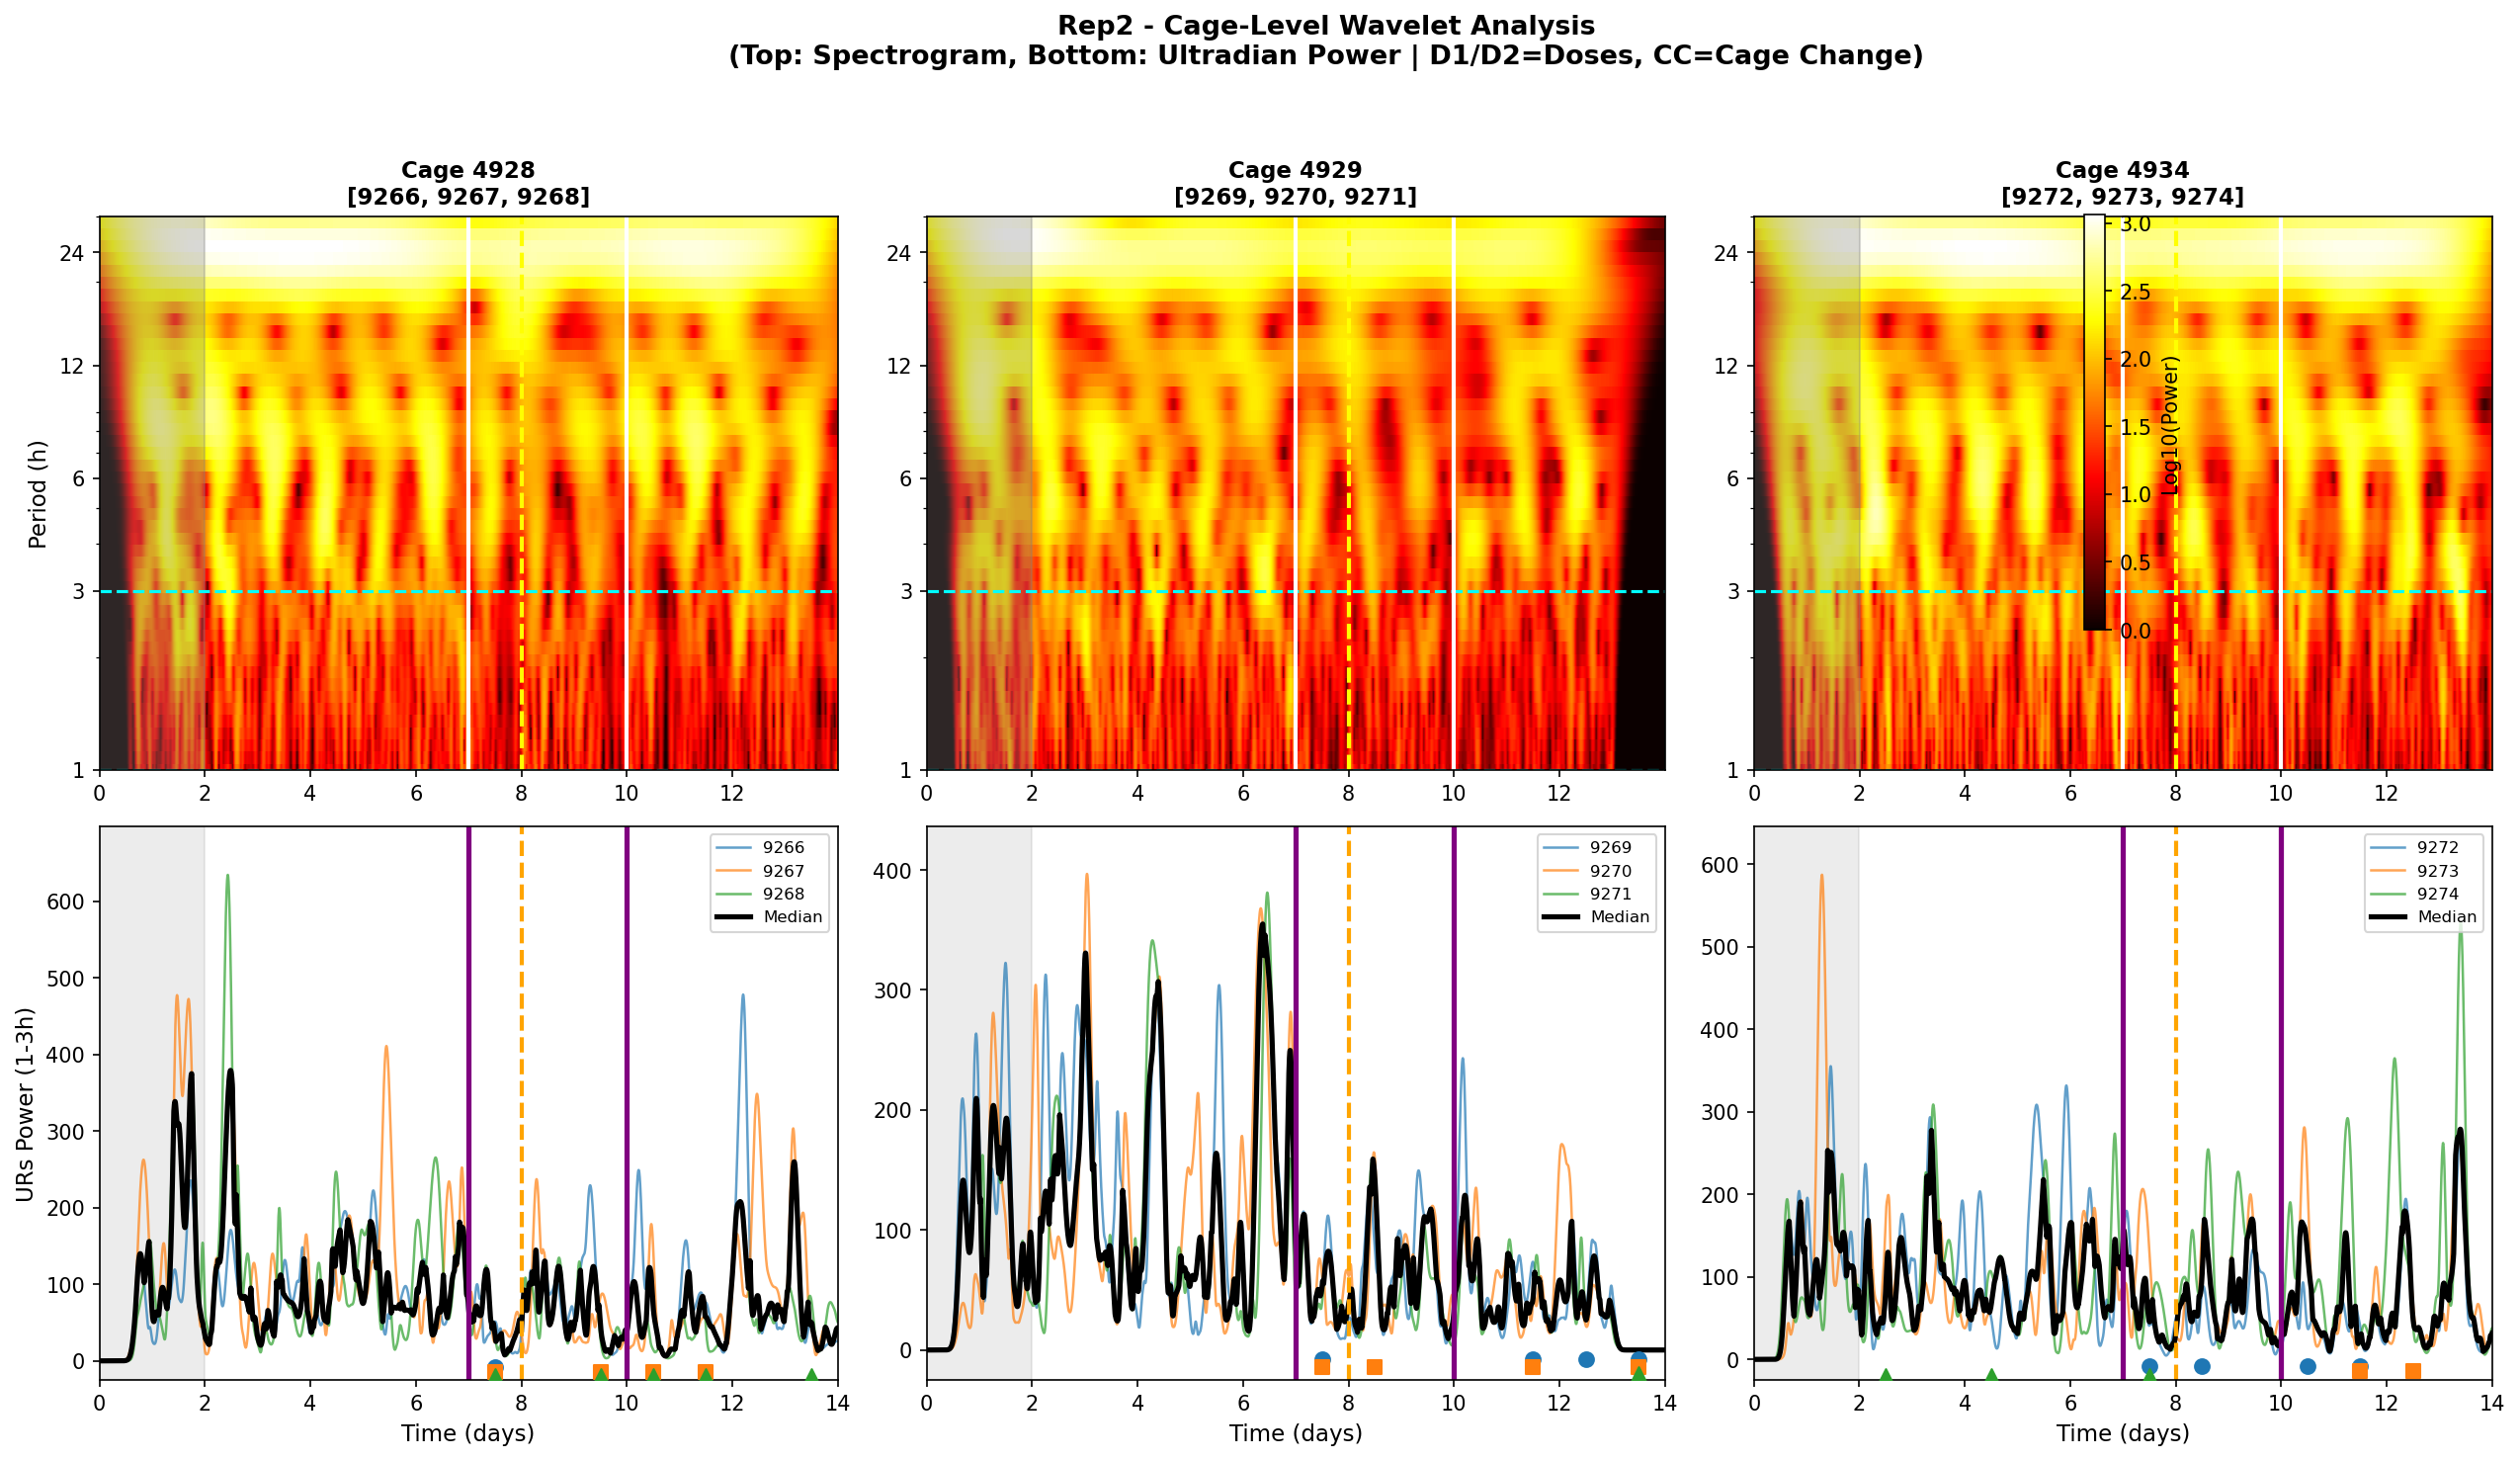

In [16]:
# =============================================================================
# COMBINED FIGURE: SPECTROGRAM + ULTRADIAN PER CAGE (Smarr-style panels)
# =============================================================================

for rep, results in all_rep_results.items():
    cfg = VEHICLE_CAGES[rep]
    animal_results = results['animal_results']
    cycle_results = results['cycle_results']
    valid_days = cfg['valid_days']
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    
    for col, cage_id in enumerate(cfg['cages']):
        cage_animals = [r for r in animal_results if r['cage_id'] == cage_id]
        cage_cycles = [c for c in cycle_results if c['cage_id'] == cage_id]
        
        # ----- TOP ROW: Spectrogram -----
        ax_spec = axes[0, col]
        
        all_powers = []
        for r in cage_animals:
            animal_df = df_loco[(df_loco['replicate'] == rep) & (df_loco['animal_id'] == r['animal_id'])]
            animal_ts = bouts_to_minute_counts_calendar(animal_df, cfg['analysis_start'], cfg['n_days'])
            power, periods = compute_wavelet_transform(animal_ts, PERIODS_MINUTES)
            all_powers.append(power)
        
        mean_power = np.mean(all_powers, axis=0)
        periods_hours = periods / 60
        time_days = np.arange(mean_power.shape[1]) / MINUTES_PER_DAY
        
        im = ax_spec.pcolormesh(time_days, periods_hours, np.log10(mean_power + 1), 
                                cmap='hot', shading='auto')
        ax_spec.set_yscale('log')
        ax_spec.set_ylim(1, 30)
        ax_spec.set_yticks([1, 3, 6, 12, 24])
        ax_spec.set_yticklabels(['1', '3', '6', '12', '24'])
        
        # Ultradian band
        ax_spec.axhline(y=1, color='cyan', linestyle='--', linewidth=1.5)
        ax_spec.axhline(y=3, color='cyan', linestyle='--', linewidth=1.5)
        
        # Treatment markers
        ax_spec.axvline(x=cfg['dose_1_day'], color='white', linestyle='-', linewidth=2)
        ax_spec.axvline(x=cfg['dose_2_day'], color='white', linestyle='-', linewidth=2)
        ax_spec.axvline(x=cfg['cage_change_day'], color='yellow', linestyle='--', linewidth=2)
        
        ax_spec.axvspan(0, valid_days[0], alpha=0.3, color='gray')
        
        if col == 0:
            ax_spec.set_ylabel('Period (h)', fontsize=11)
        
        animal_ids = [r['animal_id'] for r in cage_animals]
        ax_spec.set_title(f'Cage {cage_id}\n{animal_ids}', fontsize=11, fontweight='bold')
        
        # ----- BOTTOM ROW: Ultradian Power -----
        ax_ur = axes[1, col]
        
        colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
        markers = ['o', 's', '^']
        
        all_ultradian = []
        for i, r in enumerate(cage_animals):
            ultradian = r['ultradian_ts']
            ultradian_smooth = pd.Series(ultradian).rolling(60, center=True, min_periods=1).mean().values
            time_days = np.arange(len(ultradian_smooth)) / MINUTES_PER_DAY
            
            ax_ur.plot(time_days, ultradian_smooth, color=colors[i], alpha=0.7, 
                      linewidth=1.2, label=f'{r["animal_id"]}')
            all_ultradian.append(ultradian_smooth)
            
            # LOW day markers
            cr = next((c for c in cage_cycles if c['animal_id'] == r['animal_id']), None)
            if cr:
                for low_day in cr['low_days']:
                    ax_ur.scatter(low_day - 0.5, -8 - i*6, marker=markers[i], 
                                 color=colors[i], s=50, zorder=5)
        
        # Median
        median_ultradian = np.median(all_ultradian, axis=0)
        ax_ur.plot(time_days, median_ultradian, color='black', linewidth=2.5, label='Median')
        
        # Treatment markers
        ymax = np.max([np.max(u) for u in all_ultradian]) * 1.1
        ax_ur.axvline(x=cfg['dose_1_day'], color='purple', linestyle='-', linewidth=2.5)
        ax_ur.axvline(x=cfg['dose_2_day'], color='purple', linestyle='-', linewidth=2.5)
        ax_ur.axvline(x=cfg['cage_change_day'], color='orange', linestyle='--', linewidth=2)
        
        ax_ur.axvspan(0, valid_days[0], alpha=0.15, color='gray')
        
        ax_ur.set_xlabel('Time (days)', fontsize=11)
        if col == 0:
            ax_ur.set_ylabel('URs Power (1-3h)', fontsize=11)
        
        ax_ur.set_xlim(0, cfg['n_days'])
        ax_ur.set_ylim(-25, ymax)
        ax_ur.legend(loc='upper right', fontsize=8)
    
    # Colorbar for spectrogram
    cbar = fig.colorbar(im, ax=axes[0, :], shrink=0.8, pad=0.02, location='right')
    cbar.set_label('Log10(Power)', fontsize=10)
    
    fig.suptitle(f'{rep} - Cage-Level Wavelet Analysis\n(Top: Spectrogram, Bottom: Ultradian Power | D1/D2=Doses, CC=Cage Change)', 
                 fontsize=13, fontweight='bold')
    plt.tight_layout(rect=[0, 0, 0.95, 0.95])
    plt.savefig(f'morph2rep_{rep}_cage_smarr.png', dpi=150, bbox_inches='tight')
    plt.show()

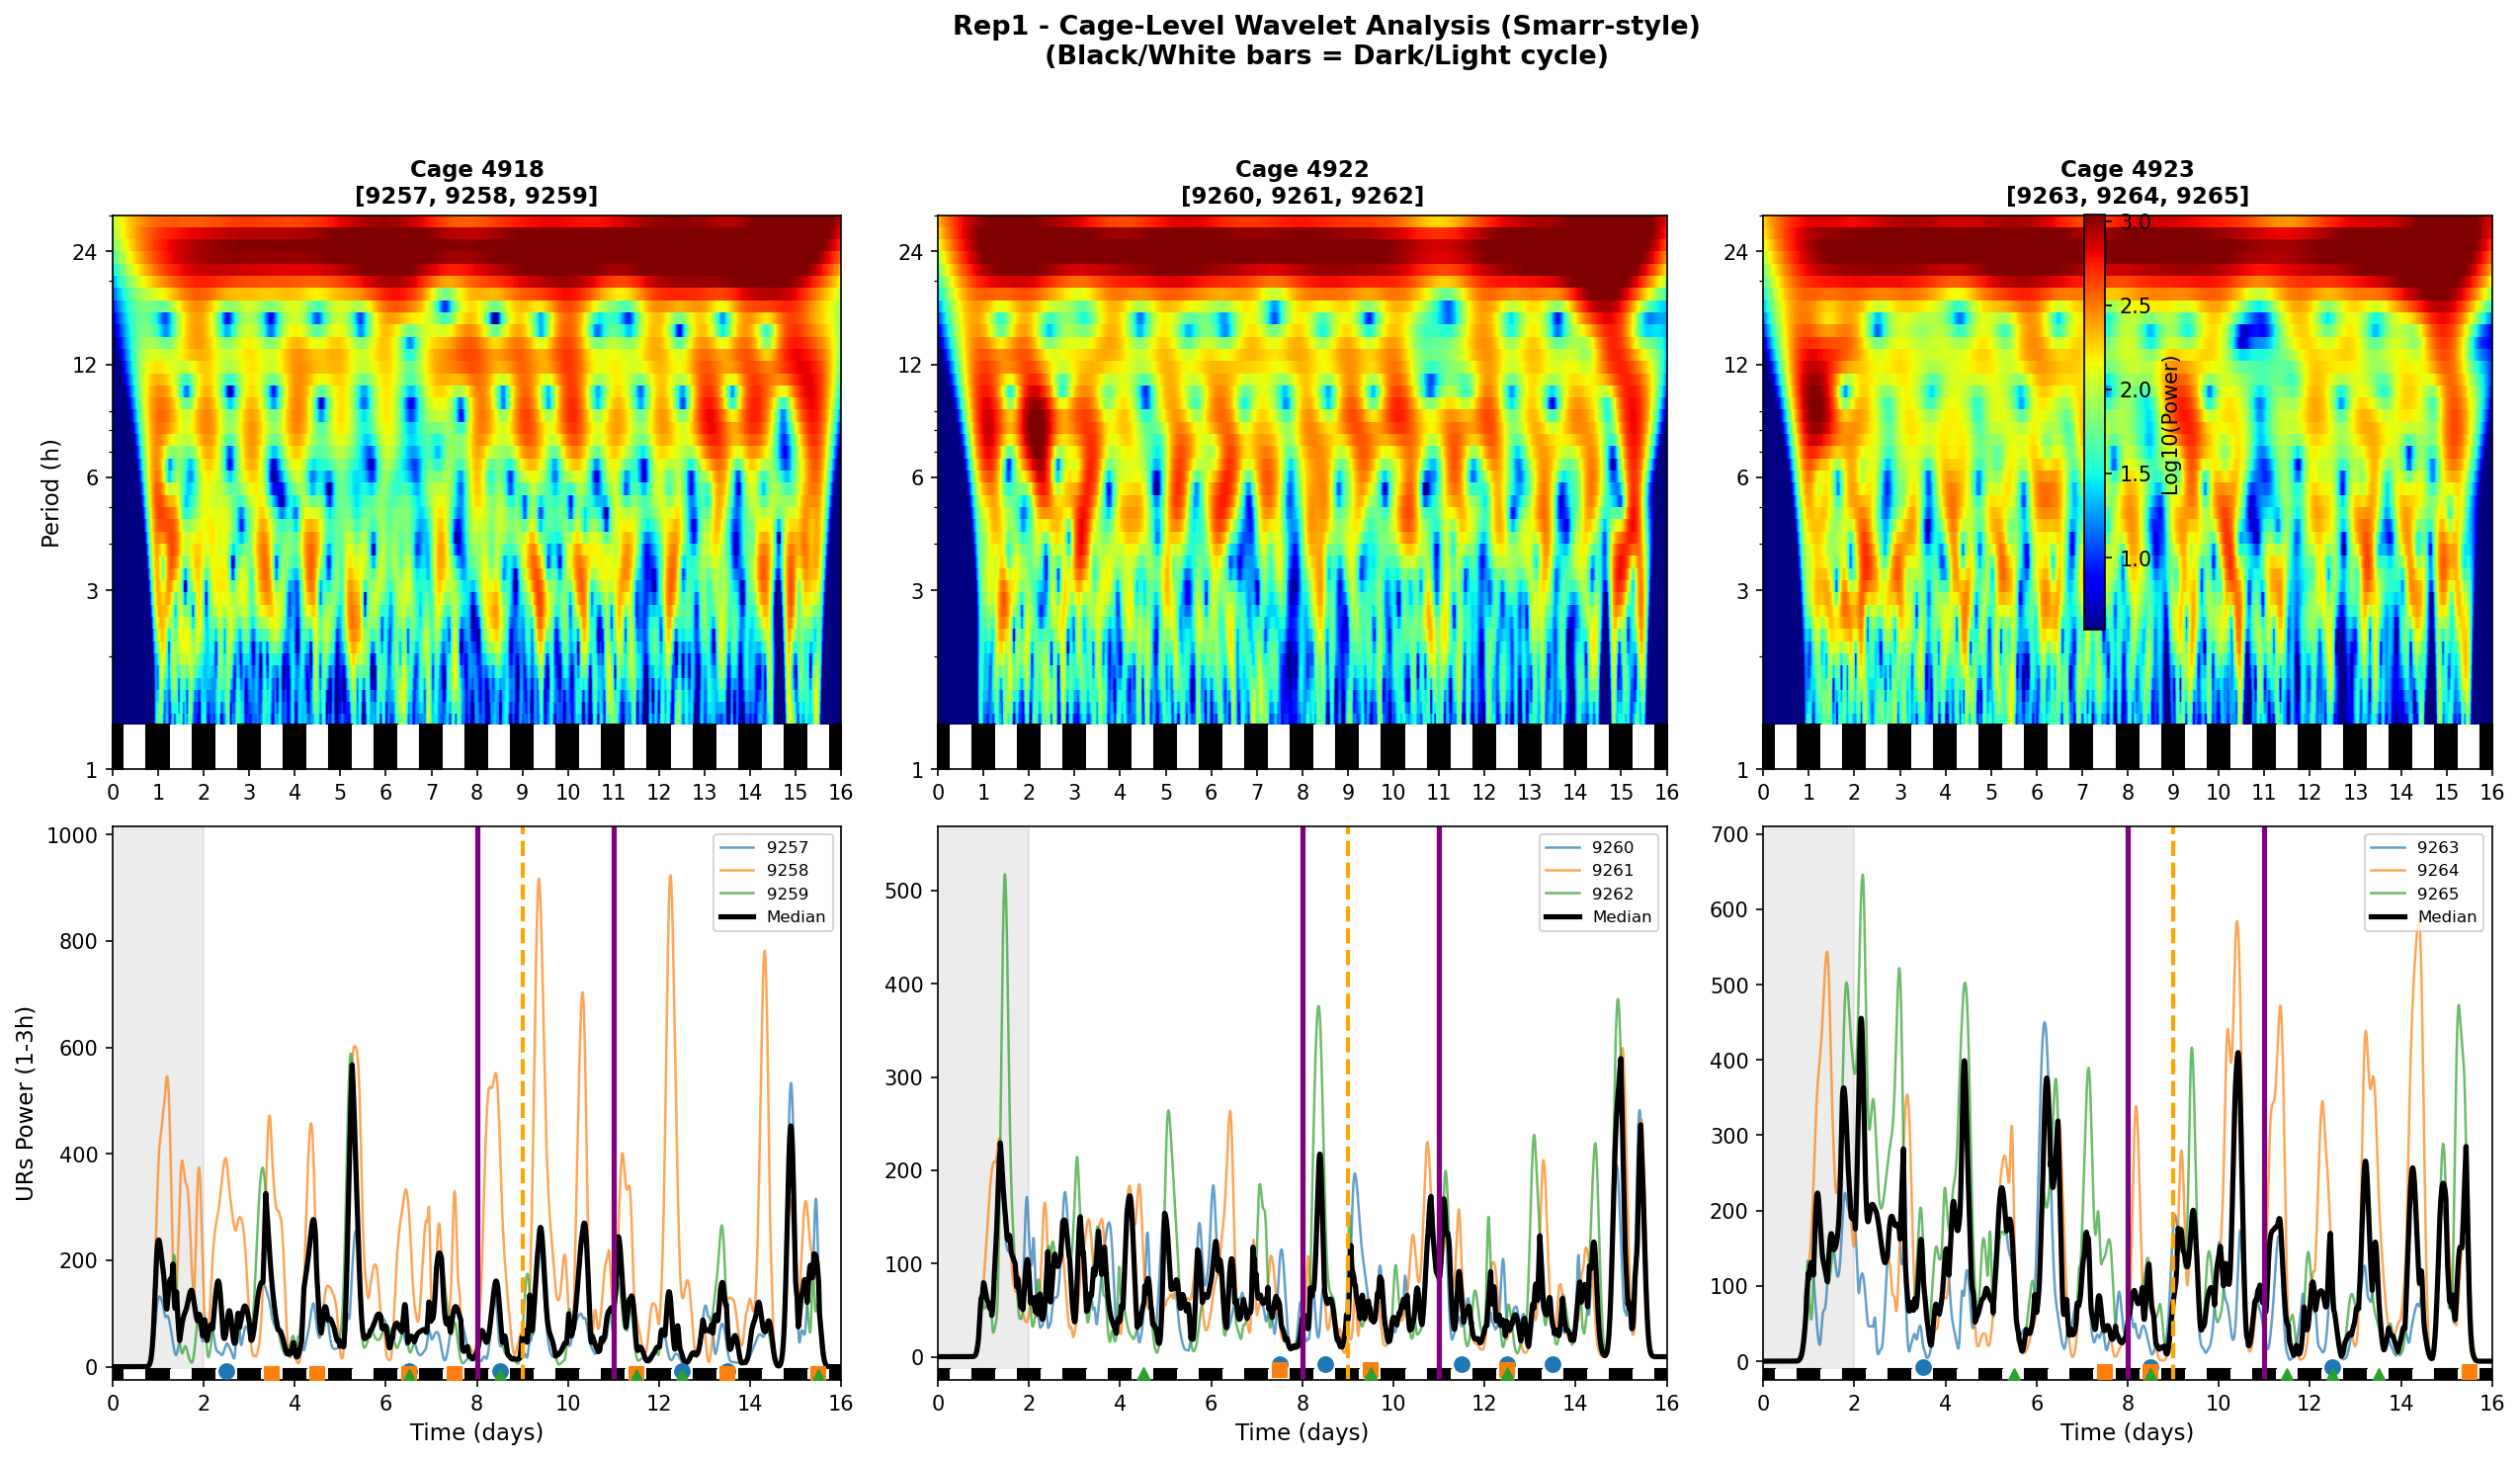

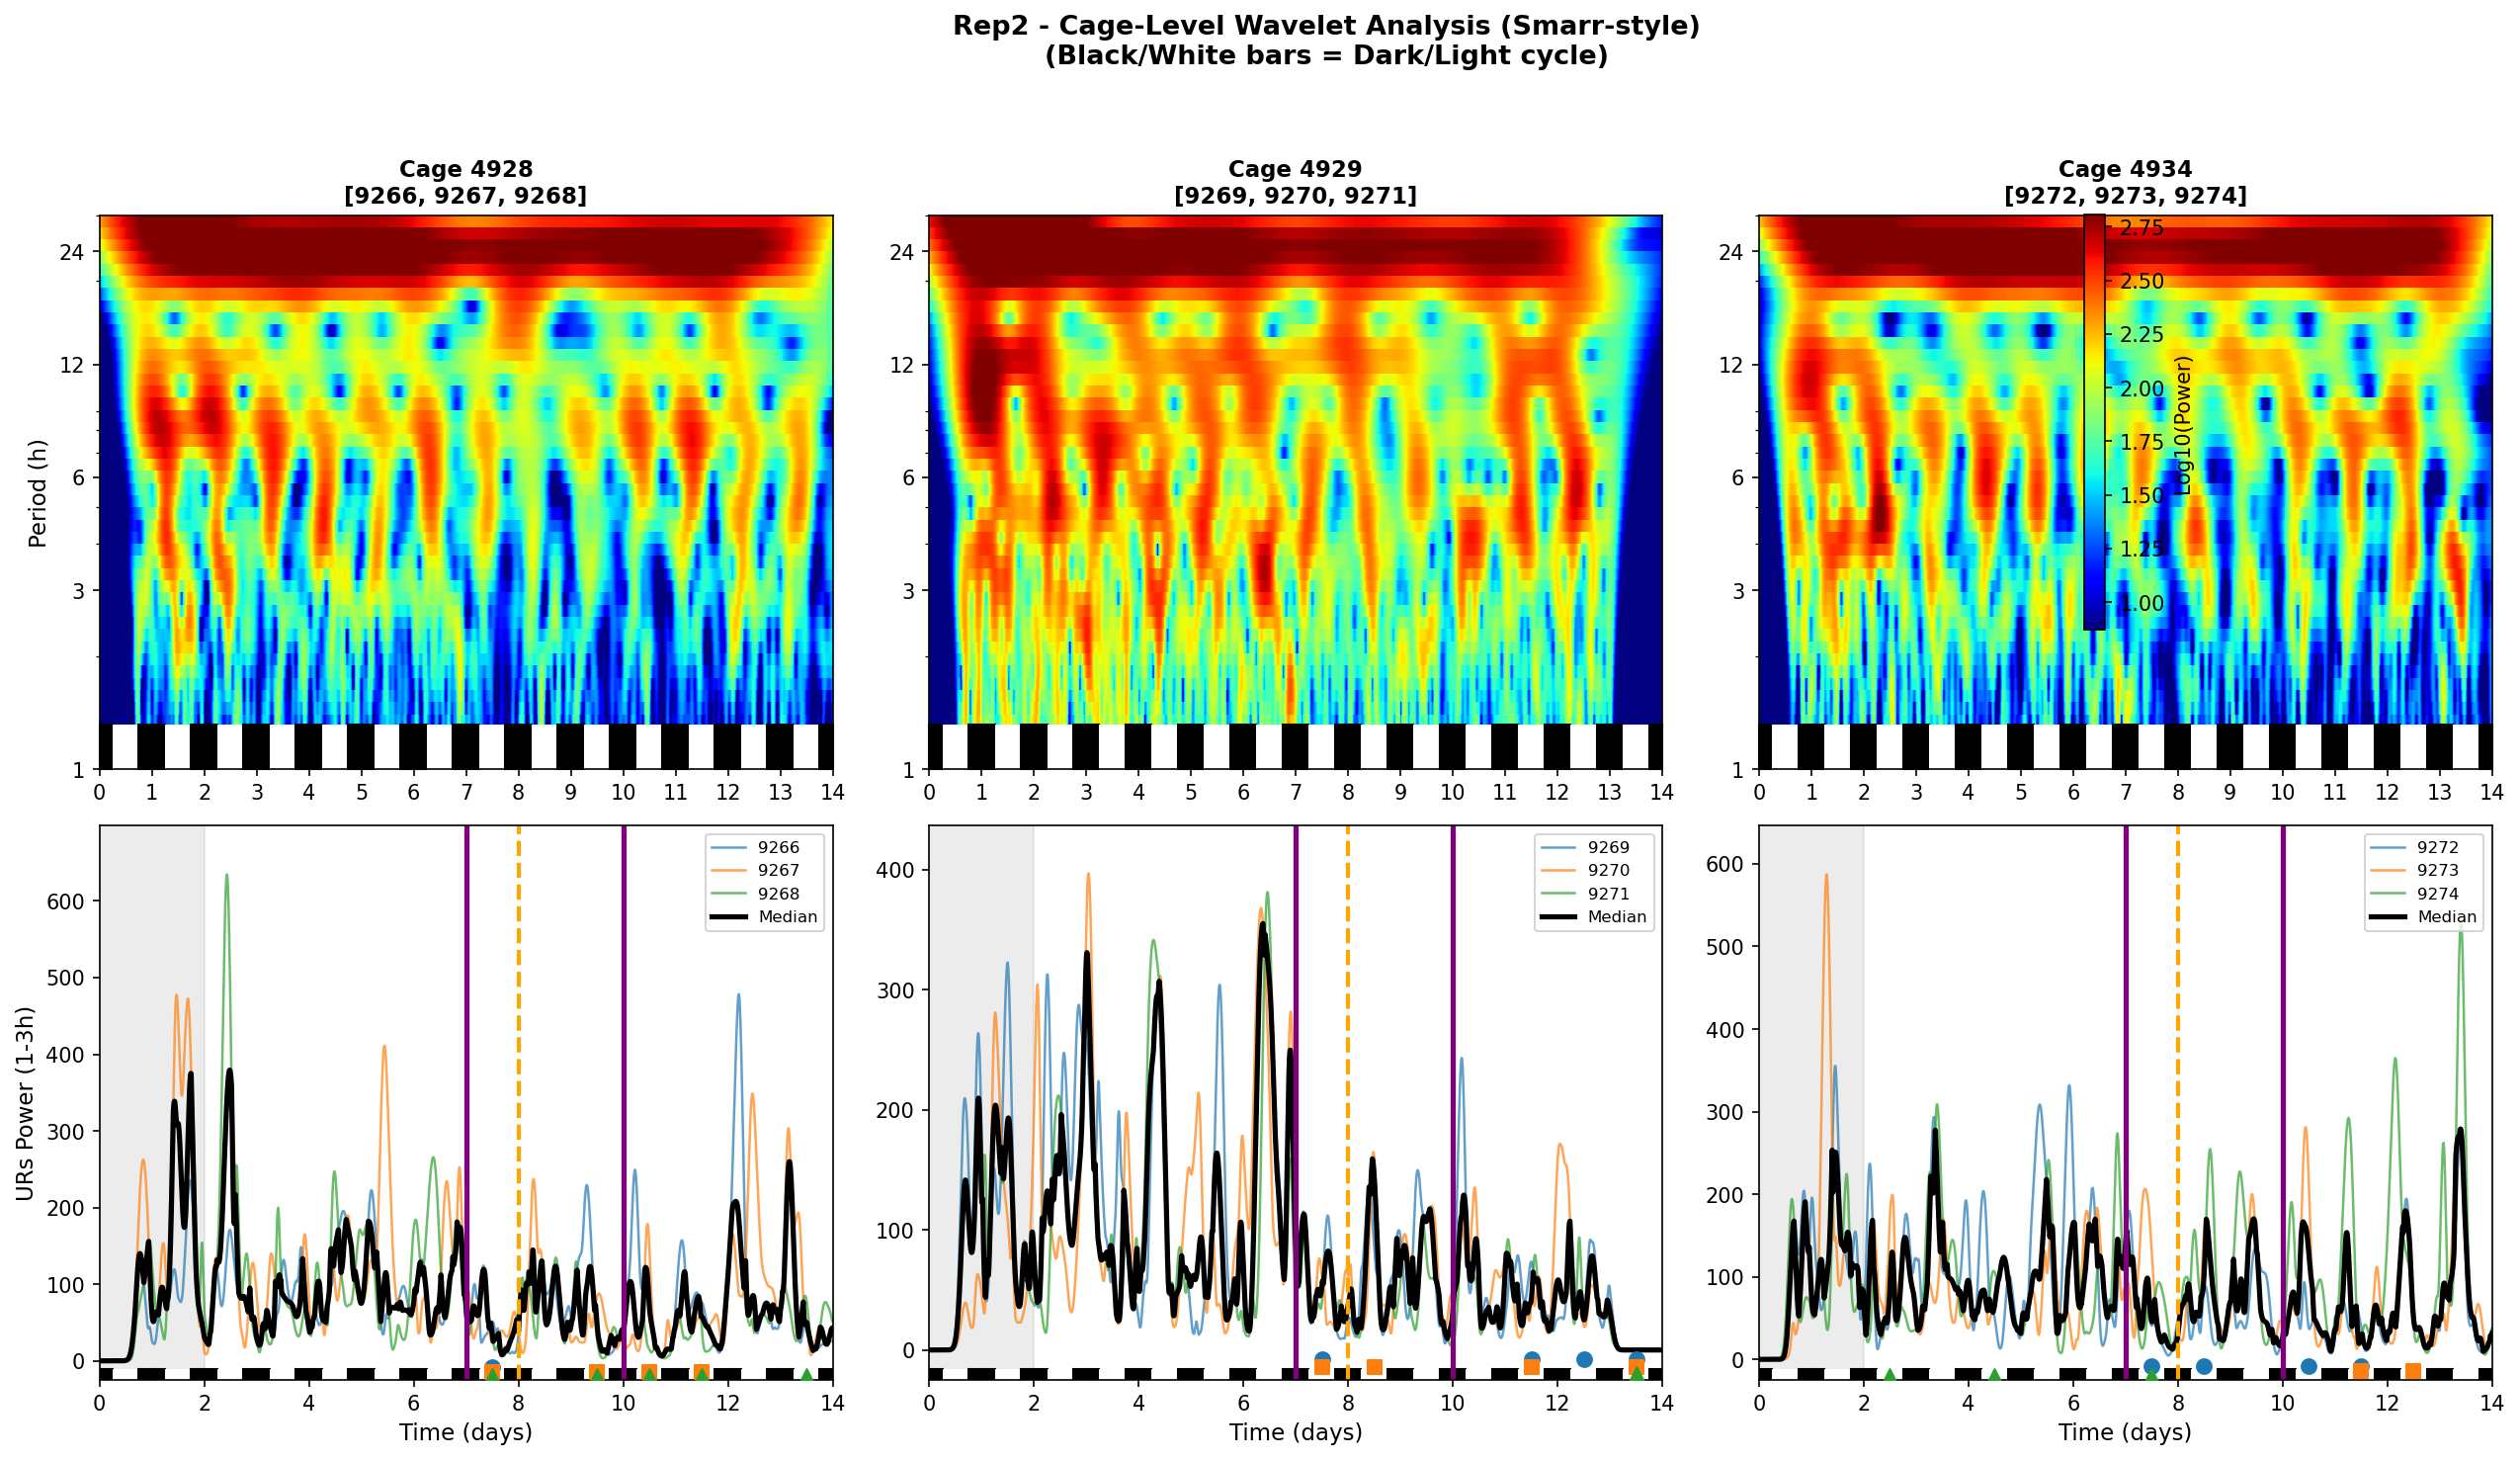

In [17]:
# =============================================================================
# SMARR-STYLE SPECTROGRAM - CORRECTED COLORMAP AND STYLING
# =============================================================================

for rep, results in all_rep_results.items():
    cfg = VEHICLE_CAGES[rep]
    animal_results = results['animal_results']
    cycle_results = results['cycle_results']
    valid_days = cfg['valid_days']
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    
    for col, cage_id in enumerate(cfg['cages']):
        cage_animals = [r for r in animal_results if r['cage_id'] == cage_id]
        cage_cycles = [c for c in cycle_results if c['cage_id'] == cage_id]
        
        # ----- TOP ROW: Spectrogram (Smarr-style) -----
        ax_spec = axes[0, col]
        
        all_powers = []
        for r in cage_animals:
            animal_df = df_loco[(df_loco['replicate'] == rep) & (df_loco['animal_id'] == r['animal_id'])]
            animal_ts = bouts_to_minute_counts_calendar(animal_df, cfg['analysis_start'], cfg['n_days'])
            power, periods = compute_wavelet_transform(animal_ts, PERIODS_MINUTES)
            all_powers.append(power)
        
        mean_power = np.mean(all_powers, axis=0)
        periods_hours = periods / 60
        time_hours = np.arange(mean_power.shape[1]) / 60  # Convert to hours for CT-style x-axis
        
        # Use jet colormap like Smarr (or 'turbo' for modern equivalent)
        # Normalize power for better visualization
        log_power = np.log10(mean_power + 1)
        
        im = ax_spec.pcolormesh(time_hours, periods_hours, log_power, 
                                cmap='jet', shading='auto', 
                                vmin=np.percentile(log_power, 5),
                                vmax=np.percentile(log_power, 95))
        ax_spec.set_yscale('log')
        ax_spec.set_ylim(1, 30)
        ax_spec.set_yticks([1, 3, 6, 12, 24])
        ax_spec.set_yticklabels(['1', '3', '6', '12', '24'])
        
        # Add light/dark cycle bars at bottom (like Smarr)
        bar_height = 0.08  # Fraction of y-axis
        for day in range(cfg['n_days']):
            day_start_hours = day * 24
            # Light phase: 6AM-6PM (hours 6-18 of each day)
            # Dark phase: 6PM-6AM (hours 0-6 and 18-24)
            
            # Dark phase (first half: 0-6)
            ax_spec.axvspan(day_start_hours, day_start_hours + 6, 
                           ymin=0, ymax=bar_height, color='black', clip_on=False)
            # Light phase (6-18)
            ax_spec.axvspan(day_start_hours + 6, day_start_hours + 18, 
                           ymin=0, ymax=bar_height, color='white', edgecolor='black', 
                           linewidth=0.5, clip_on=False)
            # Dark phase (second half: 18-24)
            ax_spec.axvspan(day_start_hours + 18, day_start_hours + 24, 
                           ymin=0, ymax=bar_height, color='black', clip_on=False)
        
        # X-axis in hours with CT-style labels
        day_ticks = np.arange(0, cfg['n_days'] + 1) * 24
        ax_spec.set_xticks(day_ticks)
        ax_spec.set_xticklabels([f'{d}' for d in range(cfg['n_days'] + 1)])
        ax_spec.set_xlim(0, cfg['n_days'] * 24)
        
        if col == 0:
            ax_spec.set_ylabel('Period (h)', fontsize=11)
        
        animal_ids = [r['animal_id'] for r in cage_animals]
        ax_spec.set_title(f'Cage {cage_id}\n{animal_ids}', fontsize=11, fontweight='bold')
        
        # ----- BOTTOM ROW: Ultradian Power -----
        ax_ur = axes[1, col]
        
        colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
        markers = ['o', 's', '^']
        
        all_ultradian = []
        for i, r in enumerate(cage_animals):
            ultradian = r['ultradian_ts']
            ultradian_smooth = pd.Series(ultradian).rolling(60, center=True, min_periods=1).mean().values
            time_days = np.arange(len(ultradian_smooth)) / MINUTES_PER_DAY
            
            ax_ur.plot(time_days, ultradian_smooth, color=colors[i], alpha=0.7, 
                      linewidth=1.2, label=f'{r["animal_id"]}')
            all_ultradian.append(ultradian_smooth)
            
            # LOW day markers
            cr = next((c for c in cage_cycles if c['animal_id'] == r['animal_id']), None)
            if cr:
                for low_day in cr['low_days']:
                    ax_ur.scatter(low_day - 0.5, -8 - i*6, marker=markers[i], 
                                 color=colors[i], s=50, zorder=5)
        
        # Median
        median_ultradian = np.median(all_ultradian, axis=0)
        ax_ur.plot(time_days, median_ultradian, color='black', linewidth=2.5, label='Median')
        
        # Treatment markers
        ymax = np.max([np.max(u) for u in all_ultradian]) * 1.1
        ax_ur.axvline(x=cfg['dose_1_day'], color='purple', linestyle='-', linewidth=2.5)
        ax_ur.axvline(x=cfg['dose_2_day'], color='purple', linestyle='-', linewidth=2.5)
        ax_ur.axvline(x=cfg['cage_change_day'], color='orange', linestyle='--', linewidth=2)
        
        ax_ur.axvspan(0, valid_days[0], alpha=0.15, color='gray')
        
        # Light/dark bars for ultradian plot too
        for day in range(cfg['n_days']):
            ax_ur.axvspan(day, day + 0.25, ymin=0, ymax=0.02, color='black')
            ax_ur.axvspan(day + 0.25, day + 0.75, ymin=0, ymax=0.02, color='white', edgecolor='black', linewidth=0.5)
            ax_ur.axvspan(day + 0.75, day + 1, ymin=0, ymax=0.02, color='black')
        
        ax_ur.set_xlabel('Time (days)', fontsize=11)
        if col == 0:
            ax_ur.set_ylabel('URs Power (1-3h)', fontsize=11)
        
        ax_ur.set_xlim(0, cfg['n_days'])
        ax_ur.set_ylim(-25, ymax)
        ax_ur.legend(loc='upper right', fontsize=8)
    
    # Colorbar
    cbar = fig.colorbar(im, ax=axes[0, :], shrink=0.8, pad=0.02, location='right')
    cbar.set_label('Log10(Power)', fontsize=10)
    
    fig.suptitle(f'{rep} - Cage-Level Wavelet Analysis (Smarr-style)\n(Black/White bars = Dark/Light cycle)', 
                 fontsize=13, fontweight='bold')
    plt.tight_layout(rect=[0, 0, 0.95, 0.95])
    plt.savefig(f'morph2rep_{rep}_smarr_corrected.png', dpi=150, bbox_inches='tight')
    plt.show()

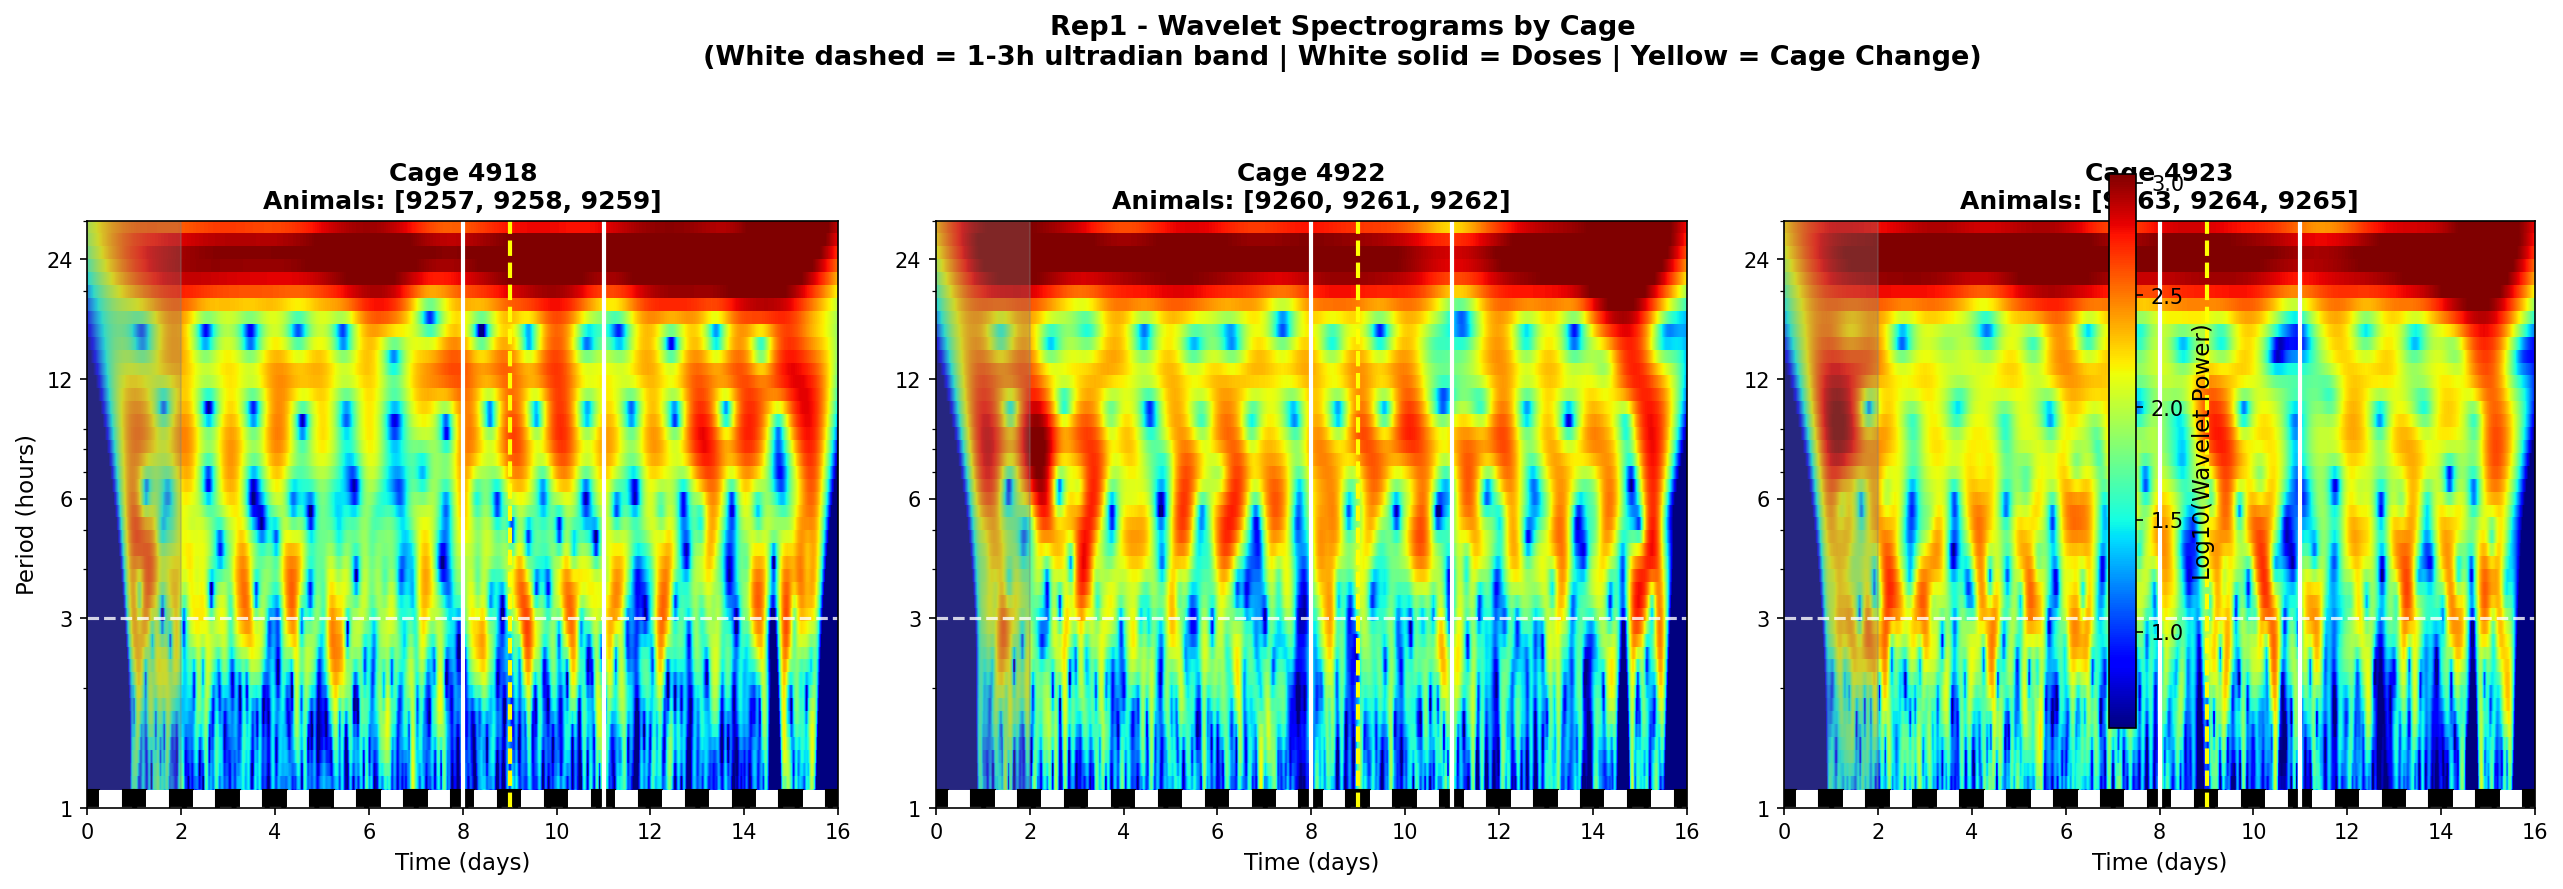

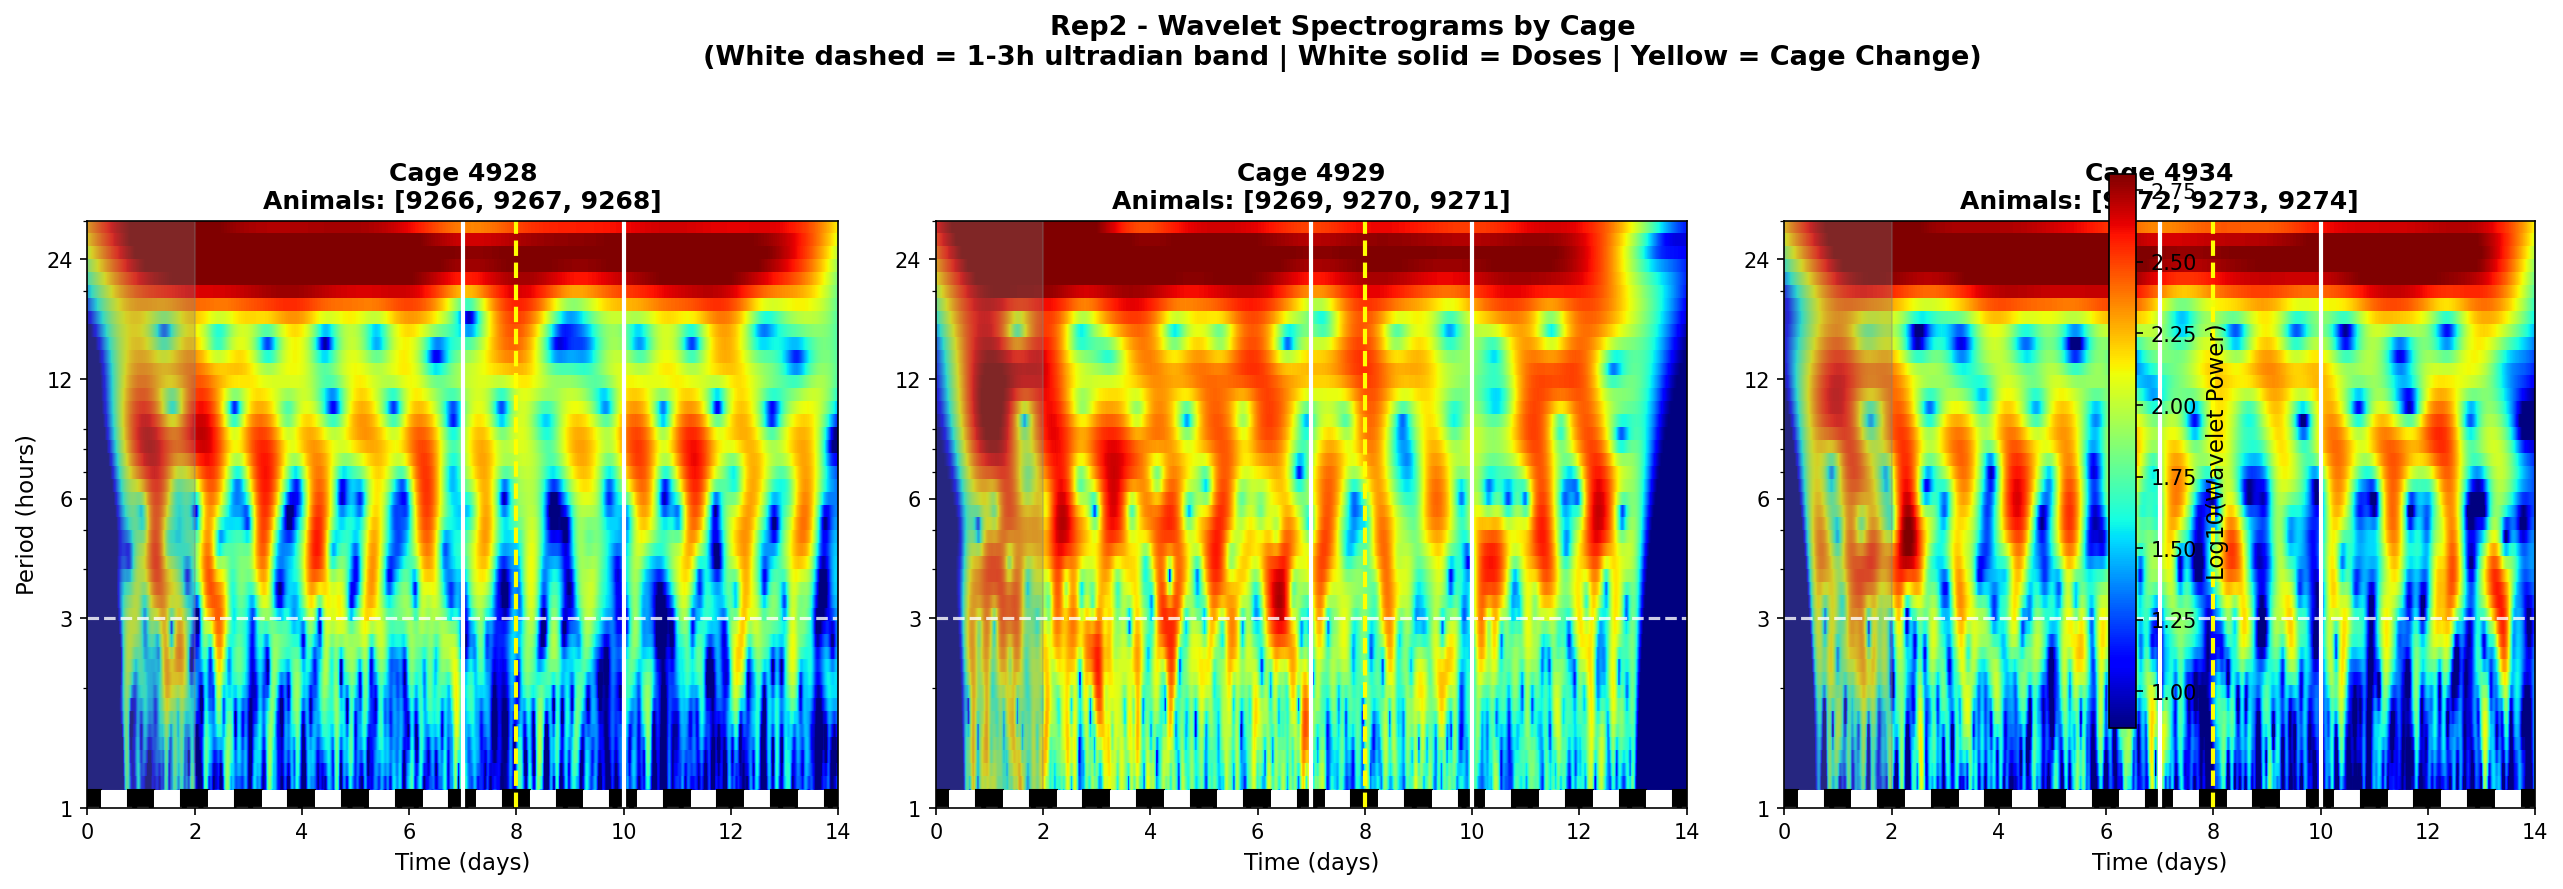

In [18]:
# =============================================================================
# SPECTROGRAM - SEPARATE PLOTS FOR EACH REPLICATE
# =============================================================================

for rep, results in all_rep_results.items():
    cfg = VEHICLE_CAGES[rep]
    animal_results = results['animal_results']
    valid_days = cfg['valid_days']
    
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    for col, cage_id in enumerate(cfg['cages']):
        ax = axes[col]
        cage_animals = [r for r in animal_results if r['cage_id'] == cage_id]
        
        # Average power across cage
        all_powers = []
        for r in cage_animals:
            animal_df = df_loco[(df_loco['replicate'] == rep) & (df_loco['animal_id'] == r['animal_id'])]
            animal_ts = bouts_to_minute_counts_calendar(animal_df, cfg['analysis_start'], cfg['n_days'])
            power, periods = compute_wavelet_transform(animal_ts, PERIODS_MINUTES)
            all_powers.append(power)
        
        mean_power = np.mean(all_powers, axis=0)
        periods_hours = periods / 60
        time_days = np.arange(mean_power.shape[1]) / MINUTES_PER_DAY
        
        # Log transform for visualization
        log_power = np.log10(mean_power + 1)
        
        # Plot with jet colormap (Smarr-style)
        im = ax.pcolormesh(time_days, periods_hours, log_power, 
                          cmap='jet', shading='auto',
                          vmin=np.percentile(log_power, 5),
                          vmax=np.percentile(log_power, 95))
        ax.set_yscale('log')
        ax.set_ylim(1, 30)
        ax.set_yticks([1, 3, 6, 12, 24])
        ax.set_yticklabels(['1', '3', '6', '12', '24'])
        
        # Mark ultradian band (1-3h)
        ax.axhline(y=1, color='white', linestyle='--', linewidth=1.5, alpha=0.8)
        ax.axhline(y=3, color='white', linestyle='--', linewidth=1.5, alpha=0.8)
        
        # Treatment markers
        ax.axvline(x=cfg['dose_1_day'], color='white', linestyle='-', linewidth=2)
        ax.axvline(x=cfg['dose_2_day'], color='white', linestyle='-', linewidth=2)
        ax.axvline(x=cfg['cage_change_day'], color='yellow', linestyle='--', linewidth=2)
        
        # Gray out excluded days
        ax.axvspan(0, valid_days[0], alpha=0.3, color='gray')
        
        # Light/dark bars at bottom
        for day in range(cfg['n_days']):
            ax.axvspan(day, day + 0.25, ymin=0, ymax=0.03, color='black')
            ax.axvspan(day + 0.25, day + 0.75, ymin=0, ymax=0.03, color='white', edgecolor='black', linewidth=0.5)
            ax.axvspan(day + 0.75, day + 1, ymin=0, ymax=0.03, color='black')
        
        ax.set_xlabel('Time (days)', fontsize=11)
        if col == 0:
            ax.set_ylabel('Period (hours)', fontsize=11)
        
        animal_ids = [r['animal_id'] for r in cage_animals]
        ax.set_title(f'Cage {cage_id}\nAnimals: {animal_ids}', fontsize=12, fontweight='bold')
        ax.set_xlim(0, cfg['n_days'])
    
    # Colorbar
    cbar = fig.colorbar(im, ax=axes.ravel().tolist(), shrink=0.8, pad=0.02)
    cbar.set_label('Log10(Wavelet Power)', fontsize=11)
    
    fig.suptitle(f'{rep} - Wavelet Spectrograms by Cage\n(White dashed = 1-3h ultradian band | White solid = Doses | Yellow = Cage Change)', 
                 fontsize=13, fontweight='bold')
    plt.tight_layout(rect=[0, 0, 0.95, 0.93])
    plt.savefig(f'morph2rep_{rep}_spectrograms.png', dpi=150, bbox_inches='tight')
    plt.show()

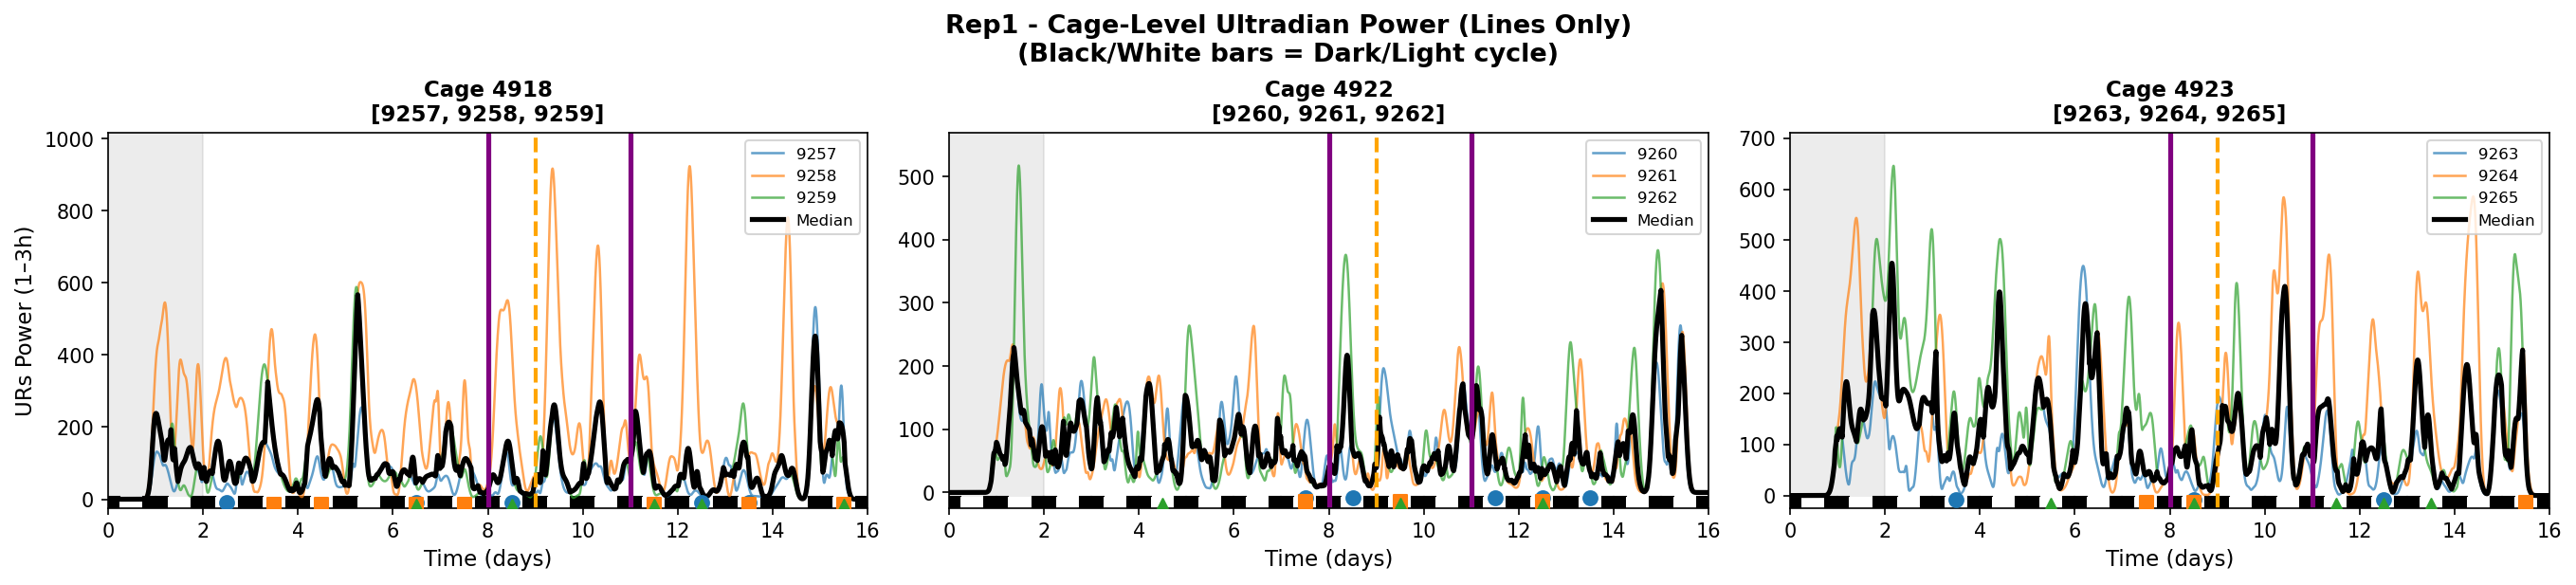

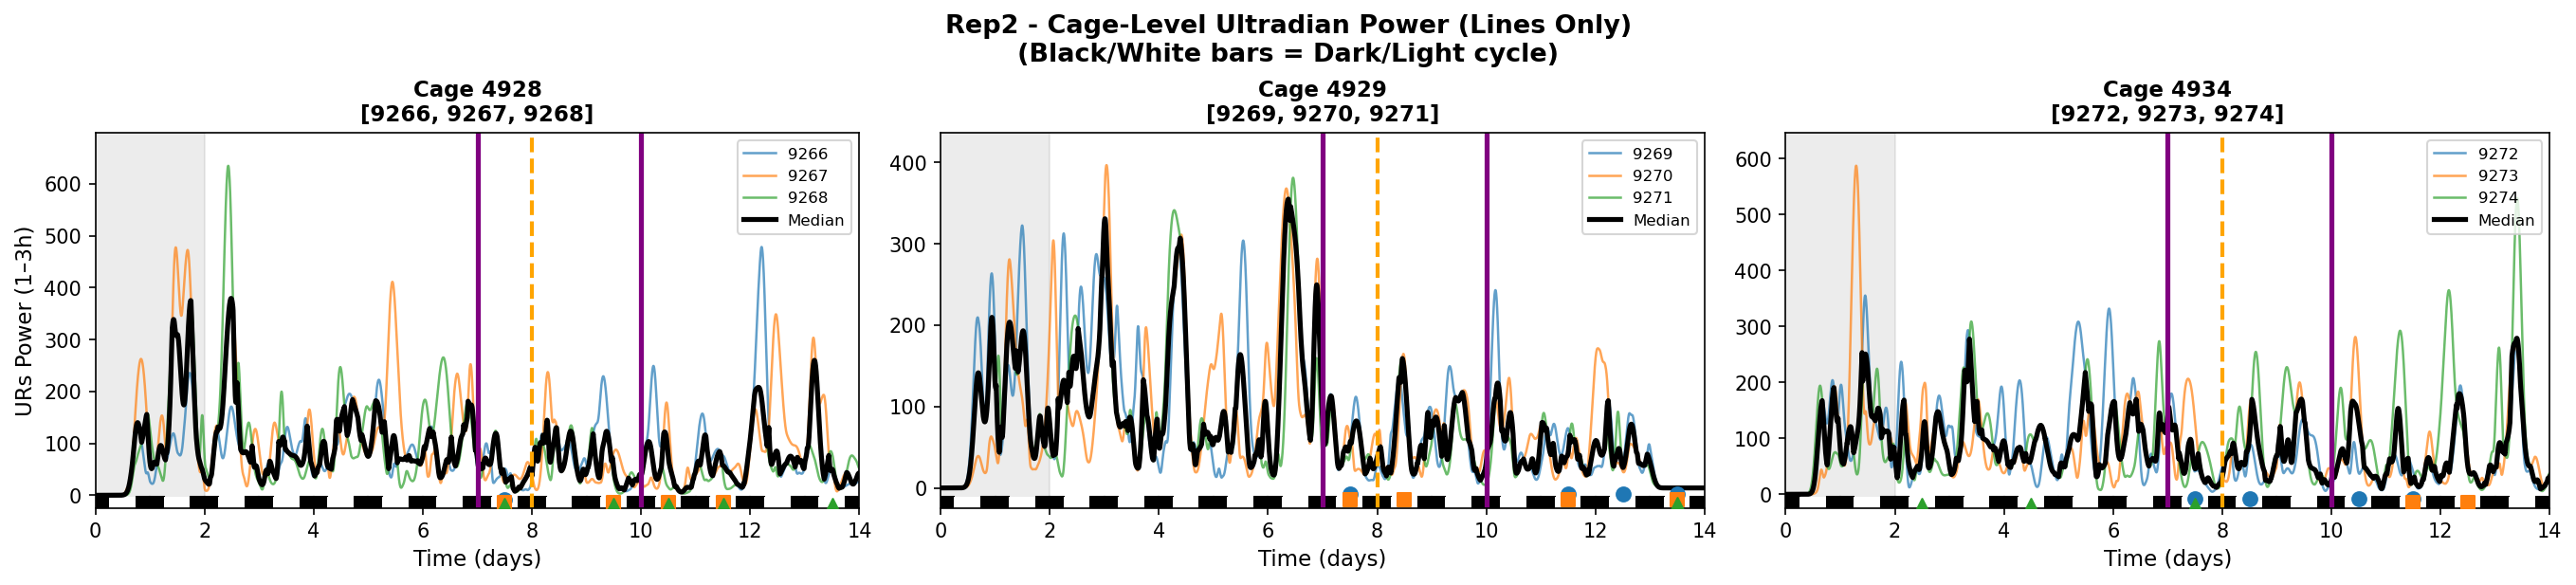

In [20]:
# =============================================================================
# SMARR-STYLE (LINES ONLY) — REMOVE WAVELET POWER SPECTROGRAM, KEEP LINE PLOTS
# =============================================================================

for rep, results in all_rep_results.items():
    cfg = VEHICLE_CAGES[rep]
    animal_results = results['animal_results']
    cycle_results = results['cycle_results']
    valid_days = cfg['valid_days']

    # One row, three columns (one line plot per cage)
    fig, axes = plt.subplots(1, 3, figsize=(18, 4), constrained_layout=True)

    # If axes comes back as a single Axes when cages=1, force list-like
    if not isinstance(axes, (list, np.ndarray)):
        axes = [axes]

    for col, cage_id in enumerate(cfg['cages']):
        ax = axes[col]
        cage_animals = [r for r in animal_results if r['cage_id'] == cage_id]
        cage_cycles = [c for c in cycle_results if c['cage_id'] == cage_id]

        colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
        markers = ['o', 's', '^']

        all_ultradian = []

        for i, r in enumerate(cage_animals):
            ultradian = r['ultradian_ts']
            ultradian_smooth = (
                pd.Series(ultradian)
                .rolling(60, center=True, min_periods=1)
                .mean()
                .values
            )
            time_days = np.arange(len(ultradian_smooth)) / MINUTES_PER_DAY

            ax.plot(
                time_days,
                ultradian_smooth,
                color=colors[i % len(colors)],
                alpha=0.7,
                linewidth=1.2,
                label=f'{r["animal_id"]}'
            )
            all_ultradian.append(ultradian_smooth)

            # LOW day markers (same as before)
            cr = next((c for c in cage_cycles if c['animal_id'] == r['animal_id']), None)
            if cr:
                for low_day in cr['low_days']:
                    ax.scatter(
                        low_day - 0.5,
                        -8 - i * 6,
                        marker=markers[i % len(markers)],
                        color=colors[i % len(colors)],
                        s=50,
                        zorder=5
                    )

        # Median across animals in cage
        if len(all_ultradian) > 0:
            median_ultradian = np.median(np.vstack(all_ultradian), axis=0)
            ax.plot(time_days, median_ultradian, color='black', linewidth=2.5, label='Median')

            ymax = np.max([np.max(u) for u in all_ultradian]) * 1.1
        else:
            ymax = 1

        # Treatment markers
        ax.axvline(x=cfg['dose_1_day'], color='purple', linestyle='-', linewidth=2.5)
        ax.axvline(x=cfg['dose_2_day'], color='purple', linestyle='-', linewidth=2.5)
        ax.axvline(x=cfg['cage_change_day'], color='orange', linestyle='--', linewidth=2)

        # Gray out excluded days
        ax.axvspan(0, valid_days[0], alpha=0.15, color='gray')

        # Light/dark bars at bottom
        for day in range(cfg['n_days']):
            ax.axvspan(day, day + 0.25, ymin=0, ymax=0.03, color='black')
            ax.axvspan(
                day + 0.25, day + 0.75,
                ymin=0, ymax=0.03,
                color='white', edgecolor='black', linewidth=0.5
            )
            ax.axvspan(day + 0.75, day + 1, ymin=0, ymax=0.03, color='black')

        ax.set_xlim(0, cfg['n_days'])
        ax.set_ylim(-25, ymax)
        ax.set_xlabel('Time (days)', fontsize=11)
        if col == 0:
            ax.set_ylabel('URs Power (1–3h)', fontsize=11)

        animal_ids = [r['animal_id'] for r in cage_animals]
        ax.set_title(f'Cage {cage_id}\n{animal_ids}', fontsize=11, fontweight='bold')
        ax.legend(loc='upper right', fontsize=8)

    fig.suptitle(
        f'{rep} - Cage-Level Ultradian Power (Lines Only)\n(Black/White bars = Dark/Light cycle)',
        fontsize=13,
        fontweight='bold'
    )

    plt.savefig(f'morph2rep_{rep}_lines_only.png', dpi=150, bbox_inches='tight')
    plt.show()


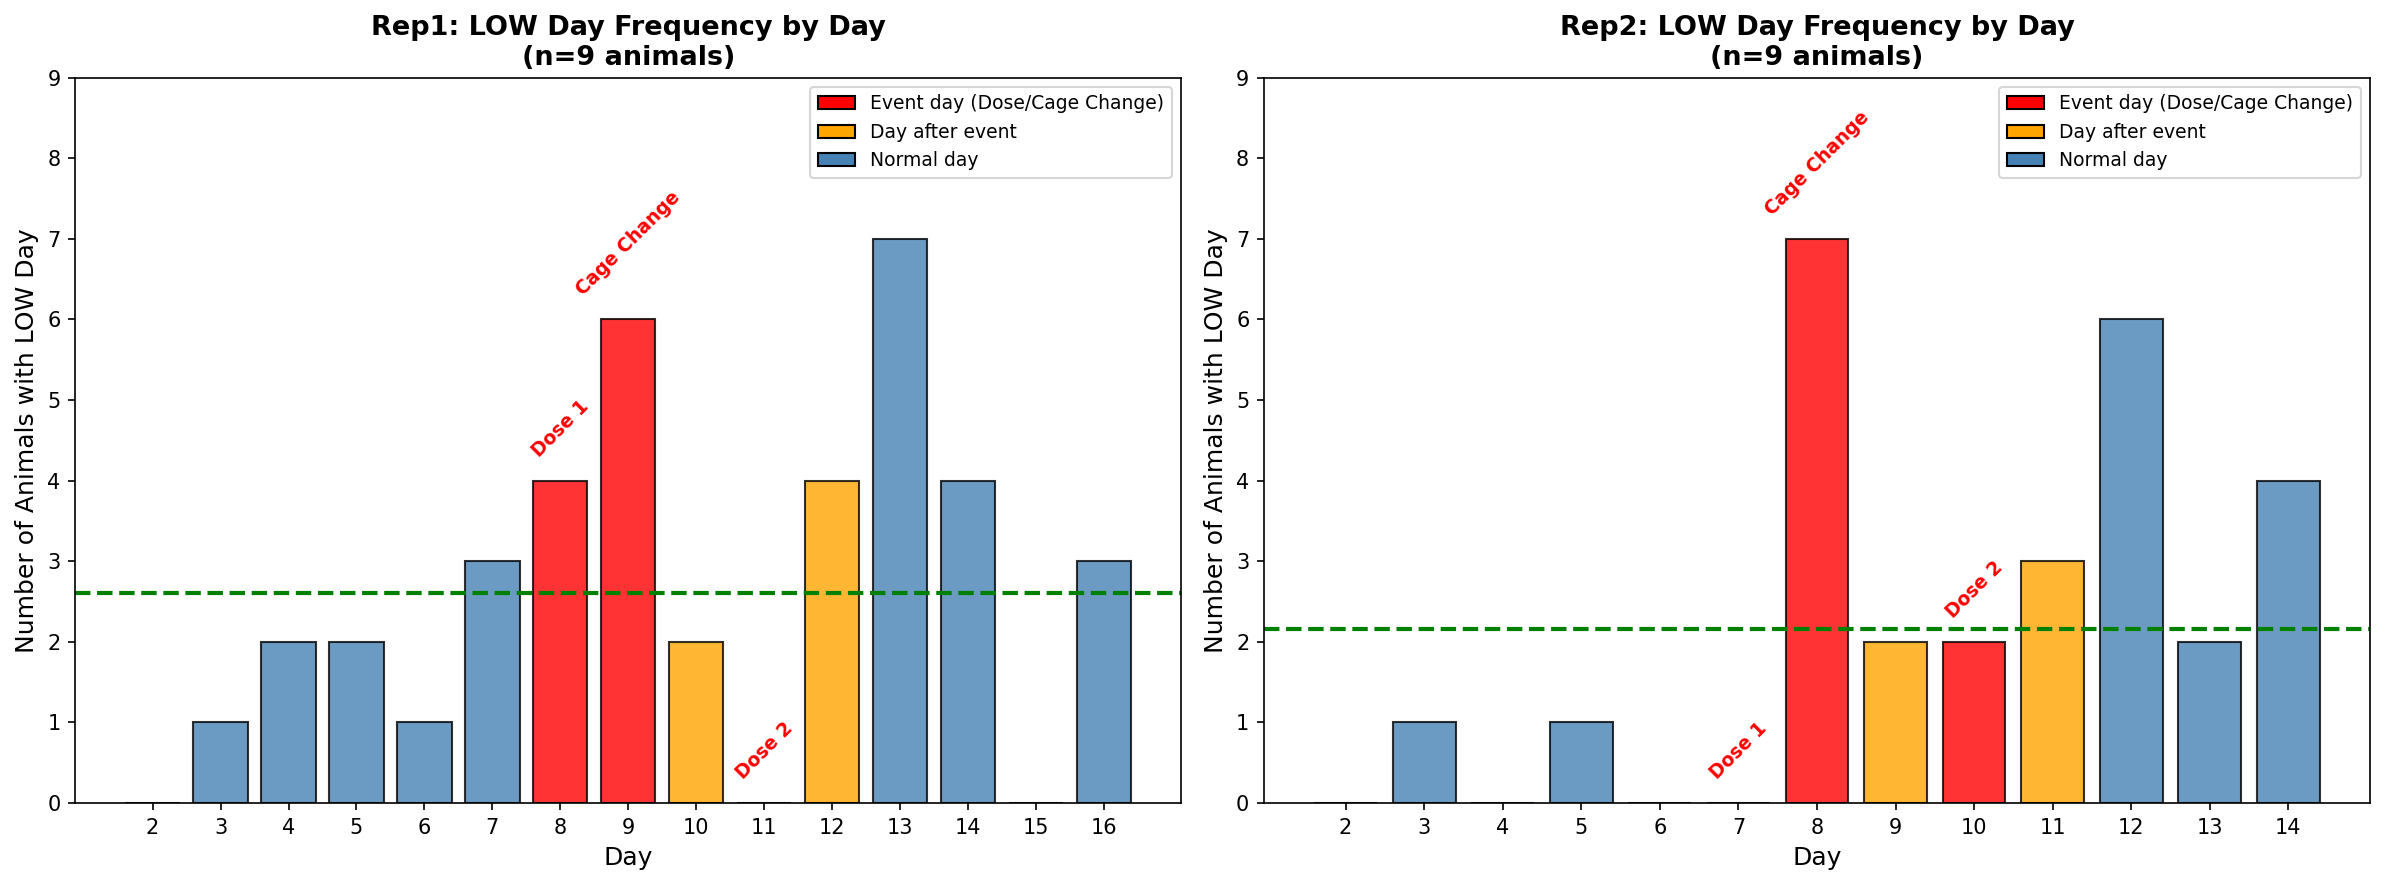

In [21]:
# =============================================================================
# VISUALIZATION: HANDLING EVENTS CONFOUND ANALYSIS
# =============================================================================

# -----------------------------------------------------------------------------
# FIGURE 1: LOW Day Frequency by Day (with event markers)
# -----------------------------------------------------------------------------

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

for col, (rep, results) in enumerate(all_rep_results.items()):
    ax = axes[col]
    cfg = VEHICLE_CAGES[rep]
    cycle_results = results['cycle_results']
    valid_days = cfg['valid_days']
    
    # Collect all LOW days
    all_low = []
    for cr in cycle_results:
        all_low.extend(cr['low_days'])
    
    low_counter = Counter(all_low)
    
    # Create bar chart
    days = list(range(valid_days[0], valid_days[1] + 1))
    counts = [low_counter.get(d, 0) for d in days]
    
    # Color bars by event type
    colors = []
    event_days = {cfg['dose_1_day']: 'Dose 1', 
                  cfg['cage_change_day']: 'Cage Change', 
                  cfg['dose_2_day']: 'Dose 2'}
    day_after_events = {d + 1: f'Day after {name}' for d, name in event_days.items()}
    
    for d in days:
        if d in event_days:
            colors.append('red')
        elif d in day_after_events:
            colors.append('orange')
        else:
            colors.append('steelblue')
    
    bars = ax.bar(days, counts, color=colors, edgecolor='black', alpha=0.8)
    
    # Add event labels
    for d, name in event_days.items():
        if d in days:
            ax.annotate(name, xy=(d, low_counter.get(d, 0) + 0.3), 
                       ha='center', fontsize=9, fontweight='bold', color='red',
                       rotation=45)
    
    # Legend
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor='red', edgecolor='black', label='Event day (Dose/Cage Change)'),
        Patch(facecolor='orange', edgecolor='black', label='Day after event'),
        Patch(facecolor='steelblue', edgecolor='black', label='Normal day')
    ]
    ax.legend(handles=legend_elements, loc='upper right', fontsize=9)
    
    ax.set_xlabel('Day', fontsize=12)
    ax.set_ylabel('Number of Animals with LOW Day', fontsize=12)
    ax.set_title(f'{rep}: LOW Day Frequency by Day\n(n=9 animals)', fontsize=13, fontweight='bold')
    ax.set_xticks(days)
    ax.set_ylim(0, max(counts) + 2)
    
    # Add horizontal line for expected if uniform
    expected = len(all_low) / len(days)
    ax.axhline(y=expected, color='green', linestyle='--', linewidth=2, 
               label=f'Expected if uniform ({expected:.1f})')

plt.tight_layout()
plt.savefig('handling_confound_low_day_frequency.png', dpi=150, bbox_inches='tight')
plt.show()

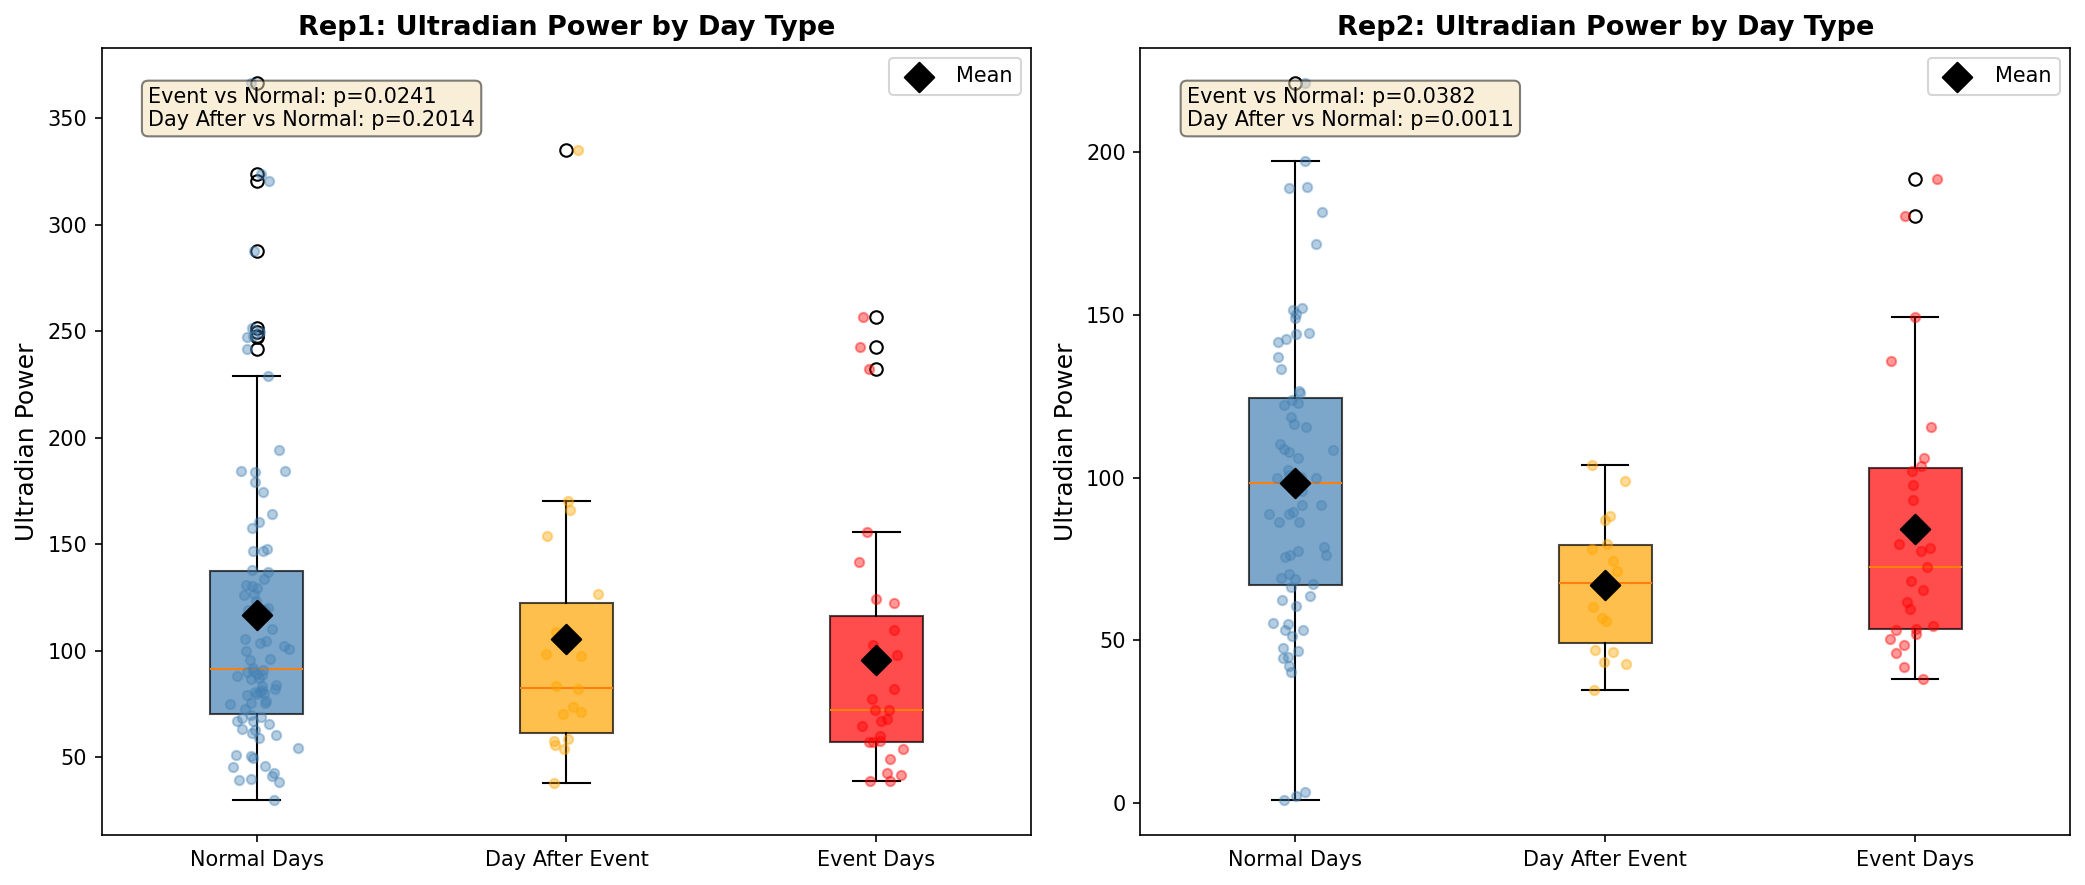

In [22]:
# -----------------------------------------------------------------------------
# FIGURE 2: Mean Ultradian Power - Event Days vs Normal Days
# -----------------------------------------------------------------------------

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

for col, (rep, results) in enumerate(all_rep_results.items()):
    ax = axes[col]
    cfg = VEHICLE_CAGES[rep]
    animal_results = results['animal_results']
    valid_days = cfg['valid_days']
    
    # Define event days
    event_days_set = {cfg['dose_1_day'], cfg['cage_change_day'], cfg['dose_2_day']}
    day_after_set = {d + 1 for d in event_days_set}
    
    # Collect power by day type
    event_powers = []
    day_after_powers = []
    normal_powers = []
    
    for r in animal_results:
        day_powers = r['day_powers']
        for day in range(valid_days[0], valid_days[1] + 1):
            idx = day - 1
            if idx < len(day_powers) and not np.isnan(day_powers[idx]):
                if day in event_days_set:
                    event_powers.append(day_powers[idx])
                elif day in day_after_set:
                    day_after_powers.append(day_powers[idx])
                else:
                    normal_powers.append(day_powers[idx])
    
    # Create box plot
    data = [normal_powers, day_after_powers, event_powers]
    labels = ['Normal Days', 'Day After Event', 'Event Days']
    colors_box = ['steelblue', 'orange', 'red']
    
    bp = ax.boxplot(data, labels=labels, patch_artist=True)
    
    for patch, color in zip(bp['boxes'], colors_box):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)
    
    # Add individual points
    for i, (d, color) in enumerate(zip(data, colors_box)):
        x = np.random.normal(i + 1, 0.04, size=len(d))
        ax.scatter(x, d, alpha=0.4, color=color, s=20, zorder=3)
    
    # Add means
    means = [np.mean(d) for d in data]
    ax.scatter([1, 2, 3], means, color='black', marker='D', s=100, zorder=5, label='Mean')
    
    # Statistics annotation
    from scipy.stats import mannwhitneyu
    stat, p_event = mannwhitneyu(event_powers, normal_powers, alternative='less')
    stat, p_after = mannwhitneyu(day_after_powers, normal_powers, alternative='less')
    
    ax.text(0.05, 0.95, f'Event vs Normal: p={p_event:.4f}\nDay After vs Normal: p={p_after:.4f}', 
            transform=ax.transAxes, fontsize=10, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    ax.set_ylabel('Ultradian Power', fontsize=12)
    ax.set_title(f'{rep}: Ultradian Power by Day Type', fontsize=13, fontweight='bold')
    ax.legend(loc='upper right')

plt.tight_layout()
plt.savefig('handling_confound_power_comparison.png', dpi=150, bbox_inches='tight')
plt.show()